# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [7]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.dates import DateFormatter

import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from importlib import reload
import dask.dataframe as dd

np.warnings = warnings

In [12]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

In [13]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

# 1. Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [14]:
path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [15]:
# load transaction dataset
df_patients_full = pd.read_csv(path_patients)
df_admissions_full = pd.read_csv(path_admissions)
df_diagnoses_icd_full = pd.read_csv(path_diagnoses_icd)
df_labevents_full = pd.read_csv(path_labevents)
df_microbiologyevents_full = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd_full = pd.read_csv(path_desc_icd)
df_desc_labitems_full = pd.read_csv(path_desc_labitems)
df_desc_items_full = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [16]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients_full['DOB'] = pd.to_datetime(df_patients_full['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents_full['CHARTTIME'] = pd.to_datetime(df_labevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents_full['CHARTDATE'] = pd.to_datetime(df_microbiologyevents_full['CHARTDATE'], format='%Y-%m-%d %H:%M:%S')
df_microbiologyevents_full['CHARTTIME'] = pd.to_datetime(df_microbiologyevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [17]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd_full[df_desc_icd_full.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd_full['IS_SEPSIS'] = df_diagnoses_icd_full.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [18]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd_full[(df_diagnoses_icd_full['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd_full['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

In [19]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic_full = pd.read_csv(pathname_demographic)
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic_full = pd.merge(df_admissions_full, df_patients_full[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic_full['AGE'] = (((df_demographic_full['ADMITTIME'].dt.date - df_demographic_full['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic_full['IS_SEPSIS'] = df_demographic_full.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd_full), axis=1)
    util.save_csv(df_demographic_full, ROOT_DIR / 'data' / 'demographic_full.csv')

# convert admittime and dischtime to datetime
df_demographic_full['ADMITTIME'] = pd.to_datetime(df_demographic_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic_full['DISCHTIME'] = pd.to_datetime(df_demographic_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

In [20]:
count_over100 = len(df_demographic_full[df_demographic_full.AGE>100])
p_over100 = len(df_demographic_full[df_demographic_full.AGE>100])/len(df_demographic_full)*100
median_age = int(df_demographic_full['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


## 2.1 Data Exploration

### 1.2.1 EDA of datasets by using Sweetviz library


#### 1. Labevents dataset

                                             |          | [  0%]   00:00 -> (? left)


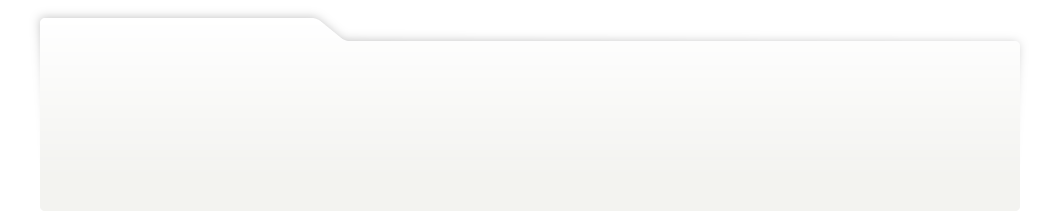
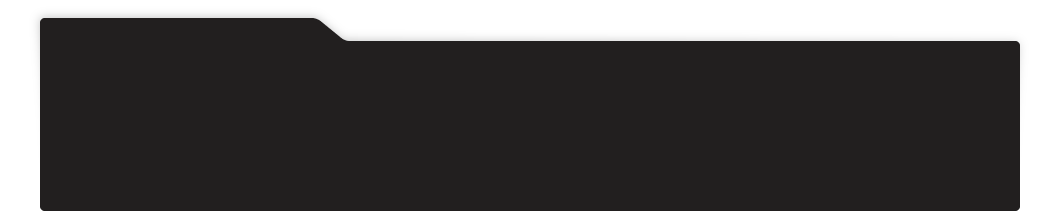
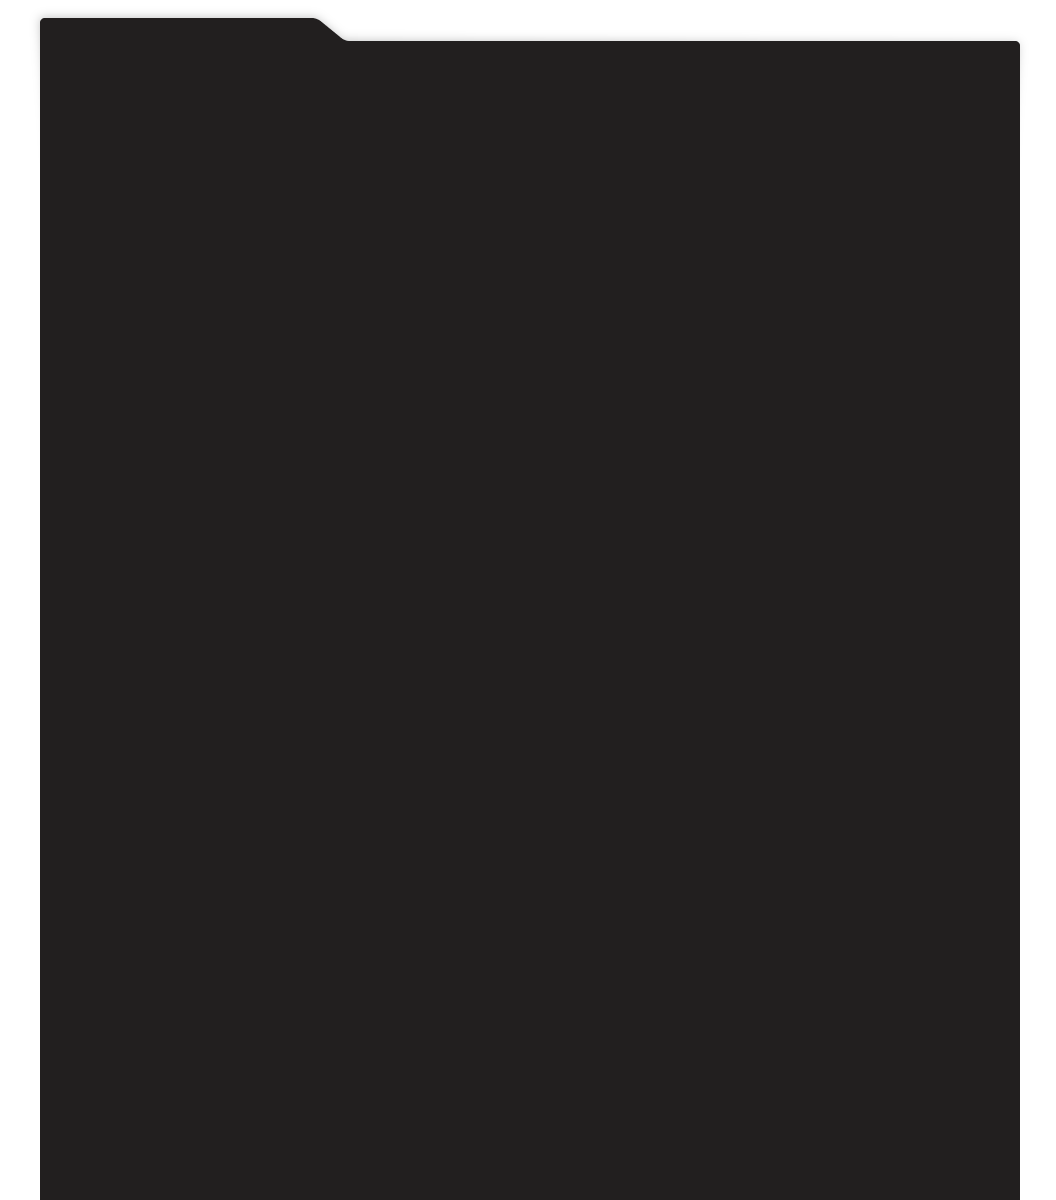
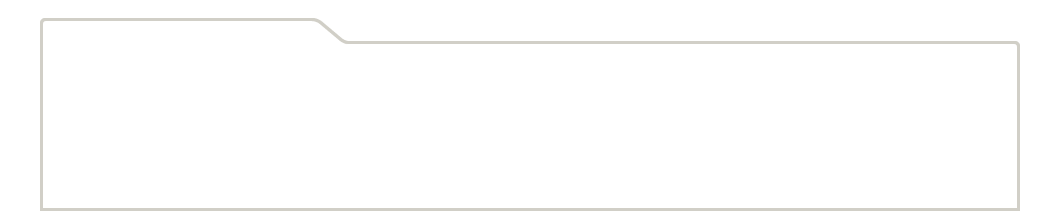
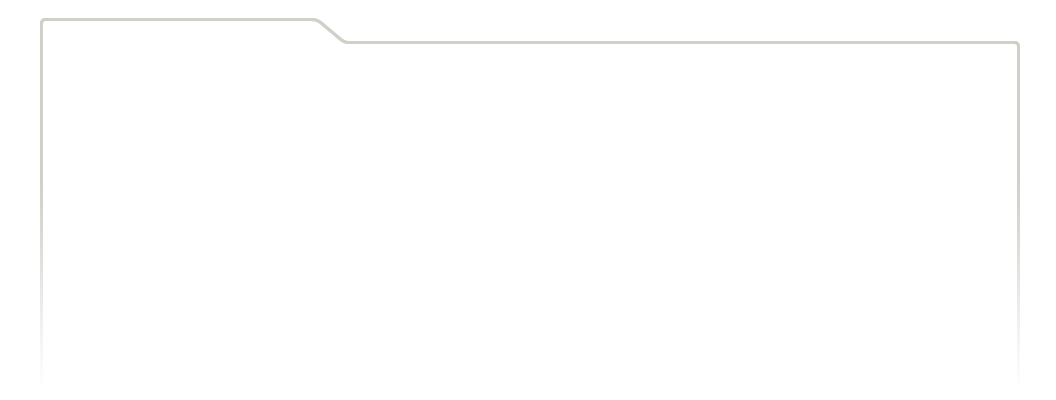
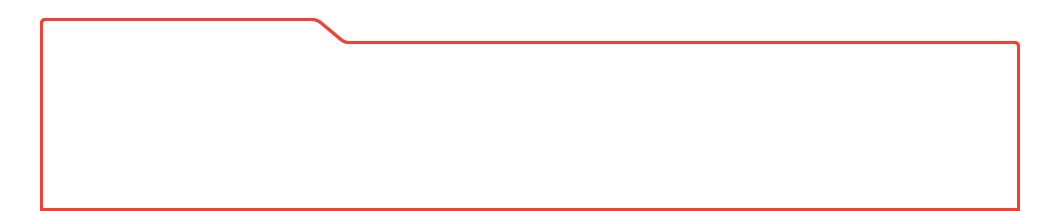
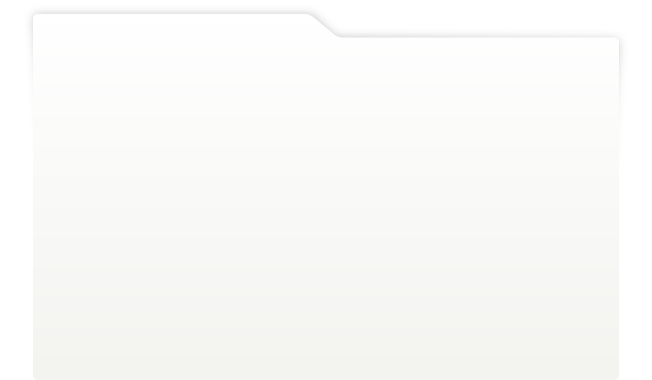
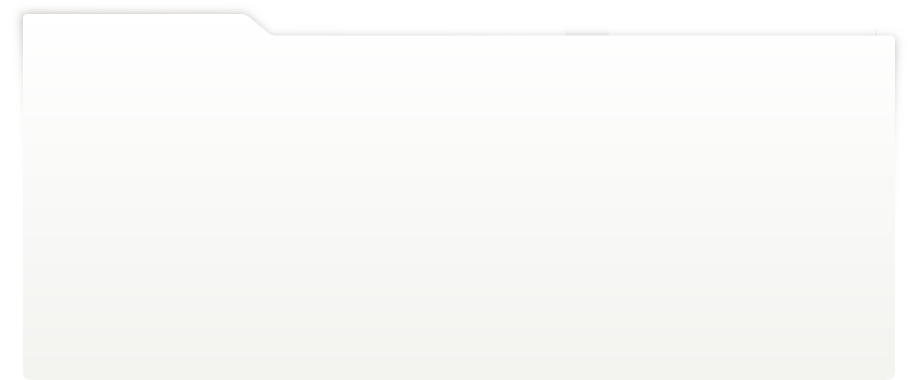
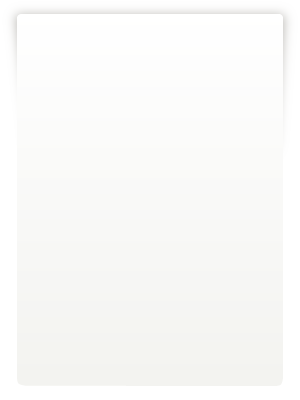
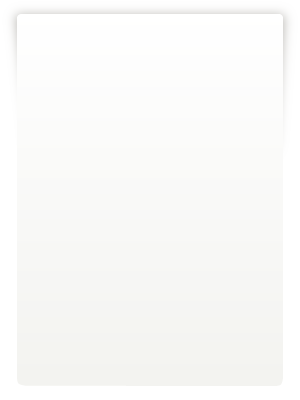
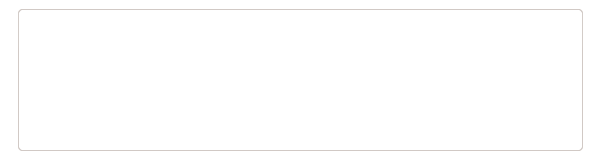
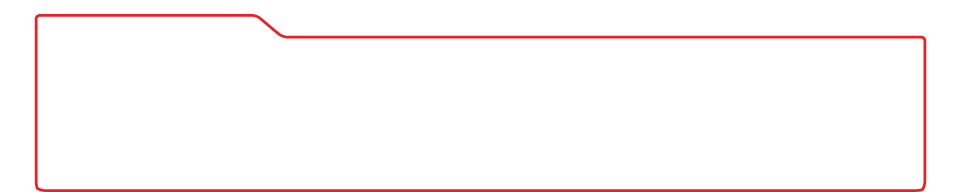
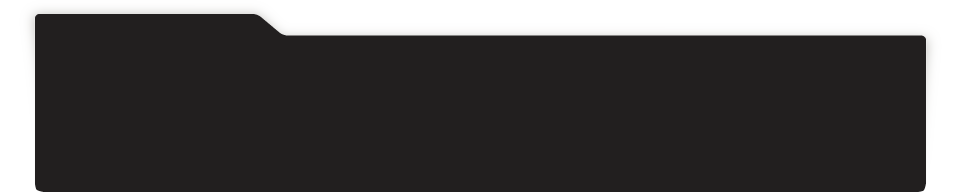
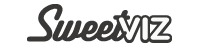
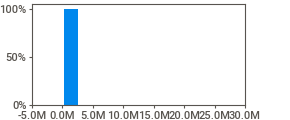
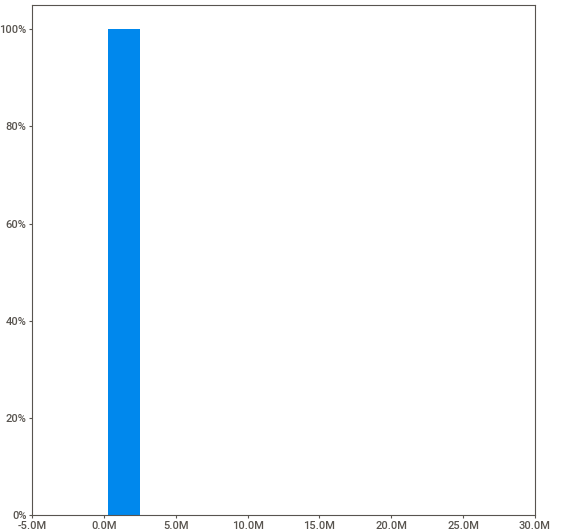
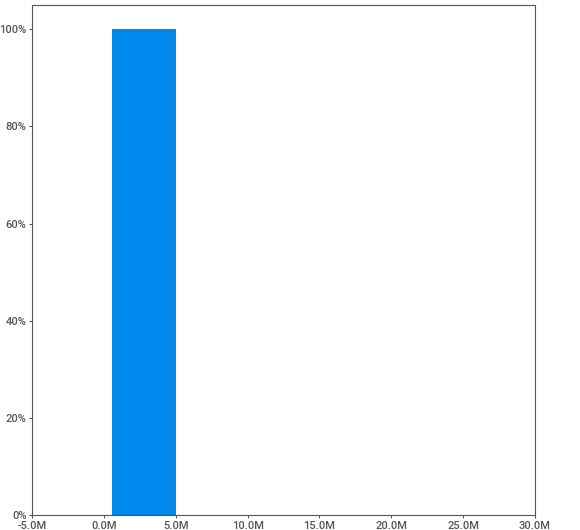
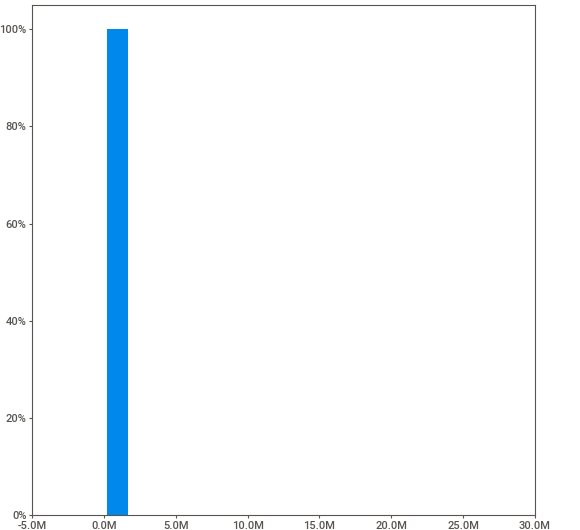
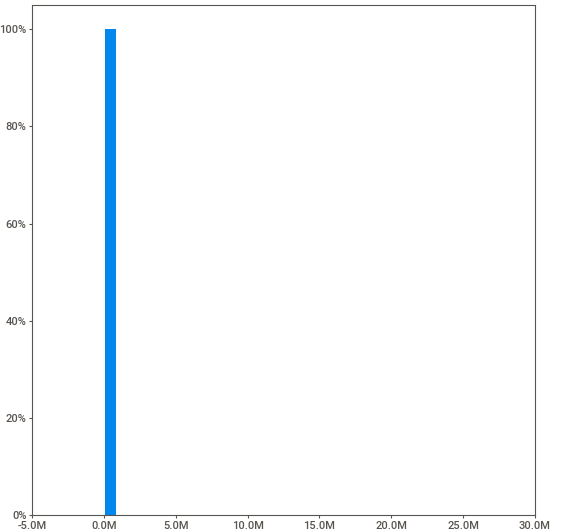
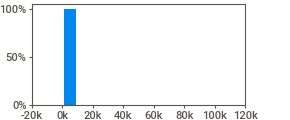
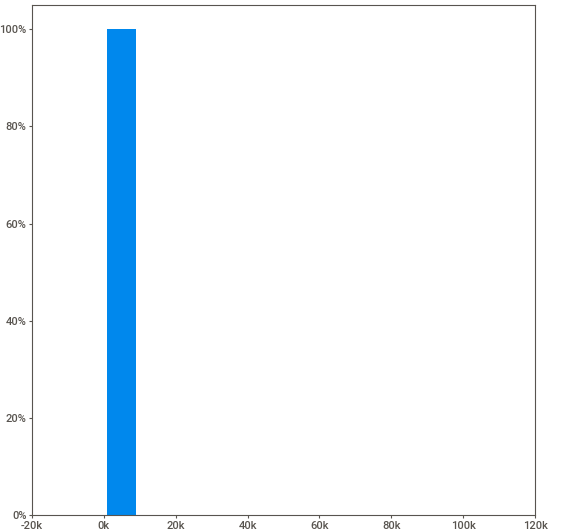
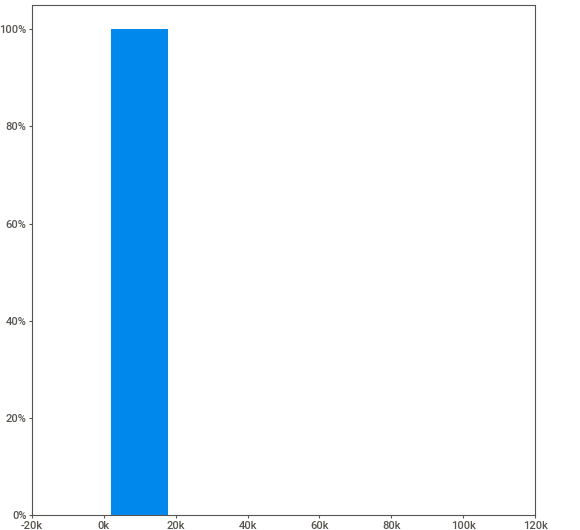
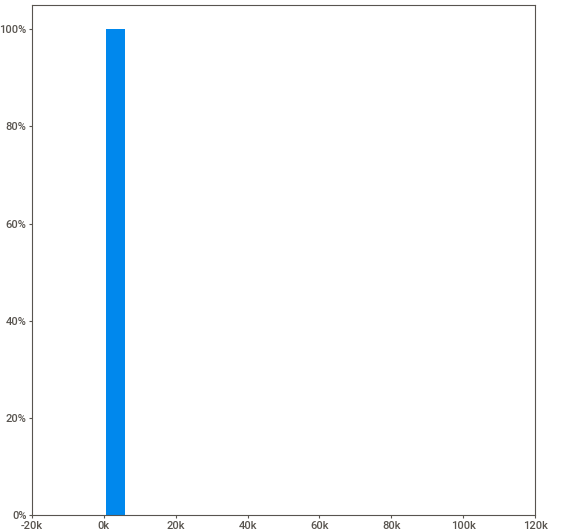
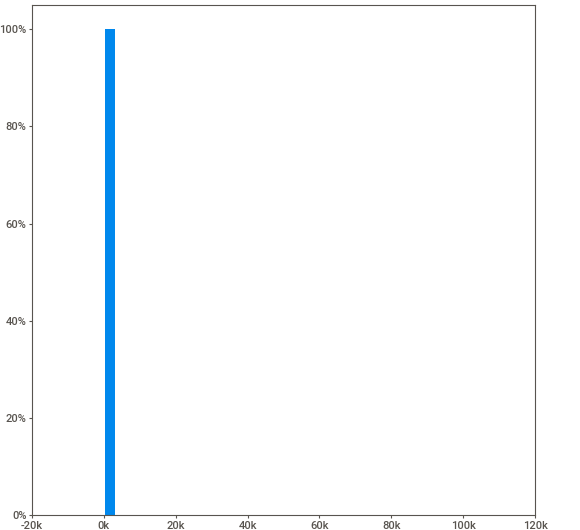
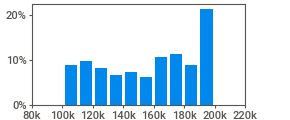
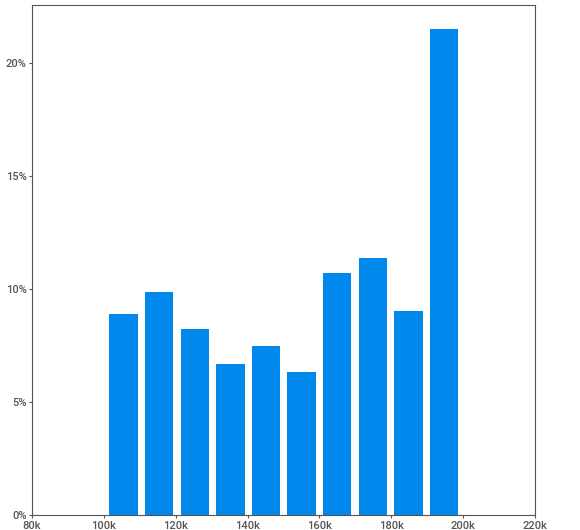
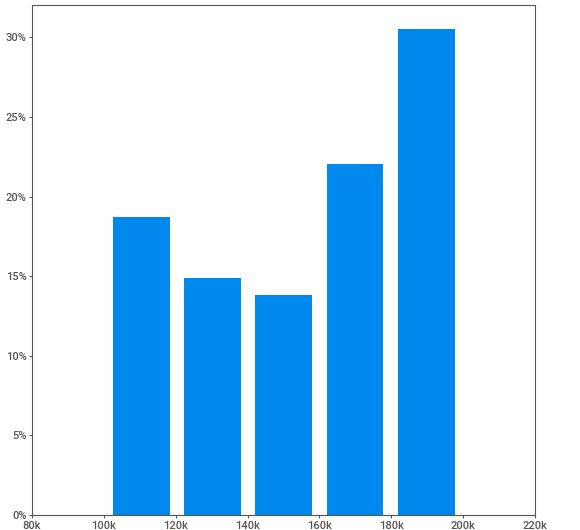
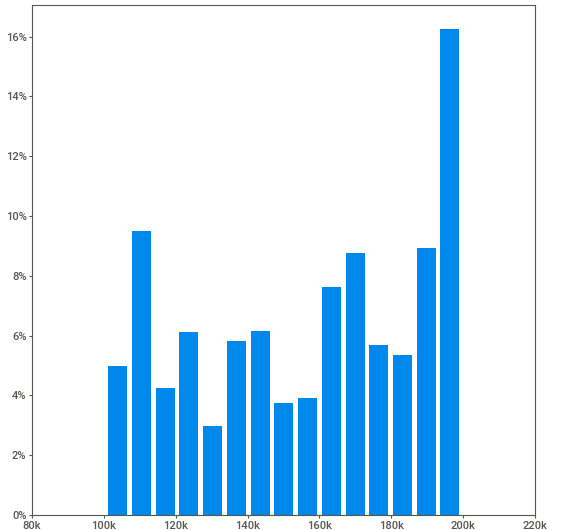
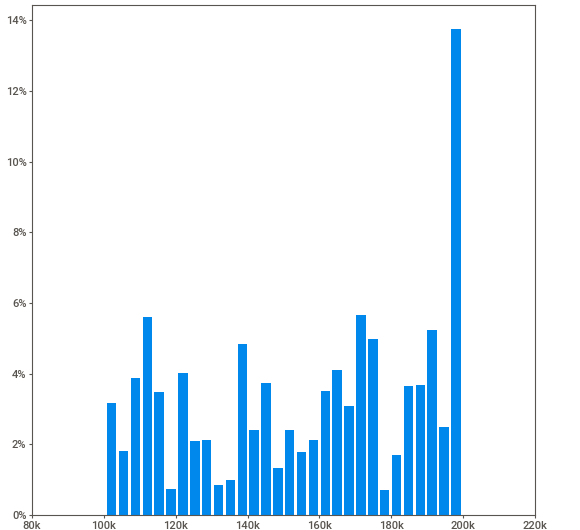
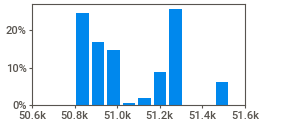
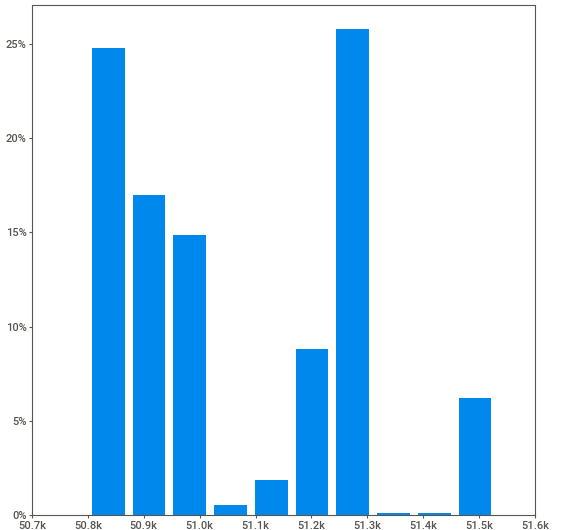
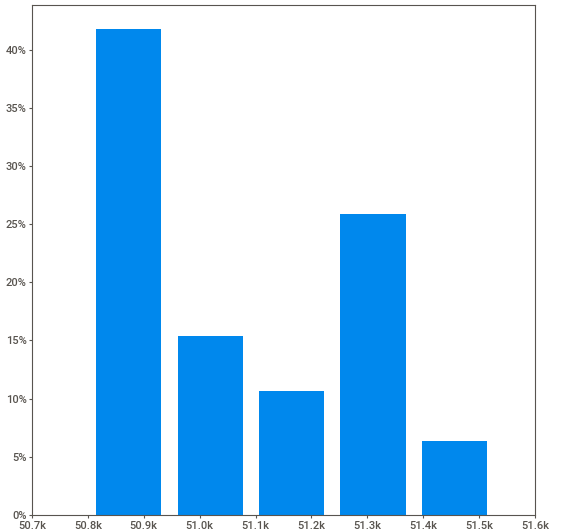
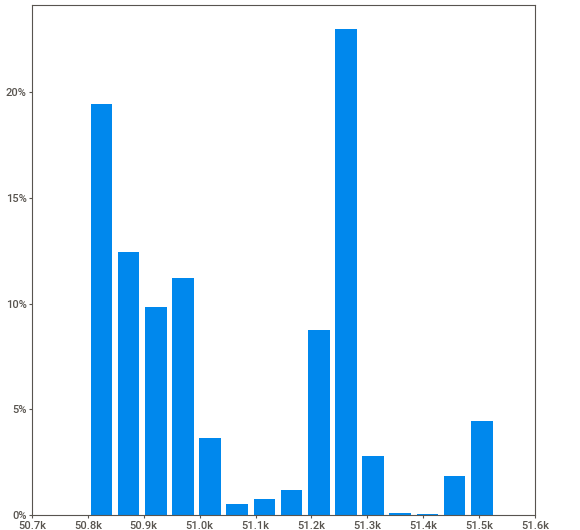
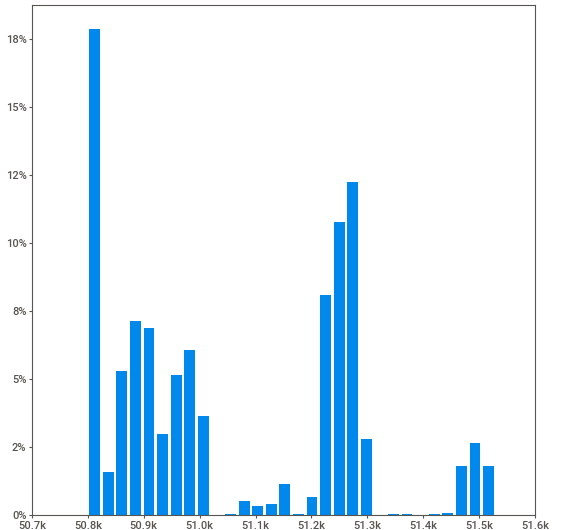
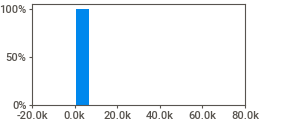
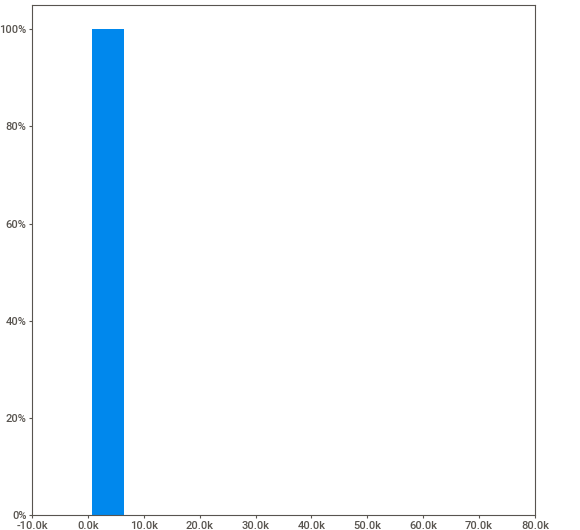
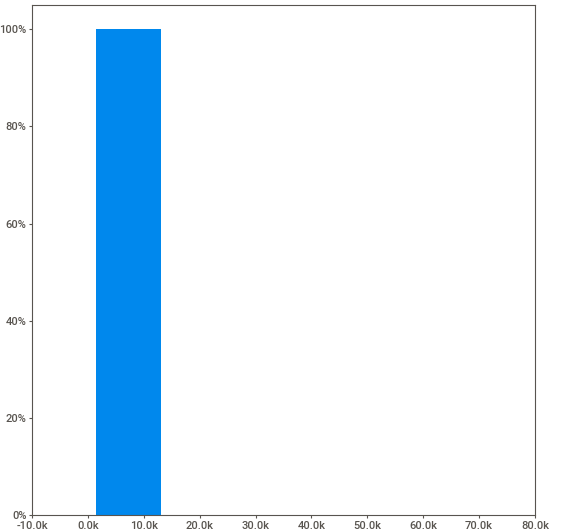
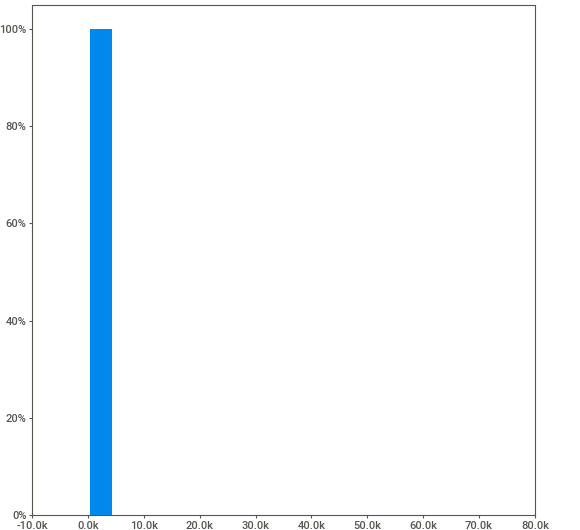
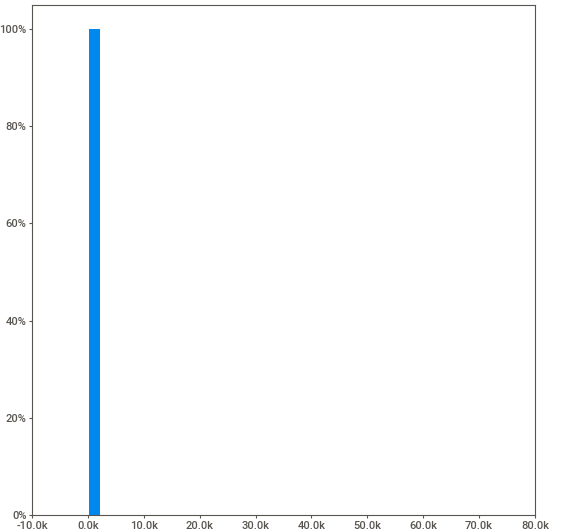
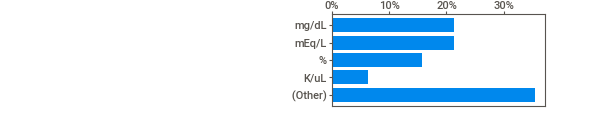
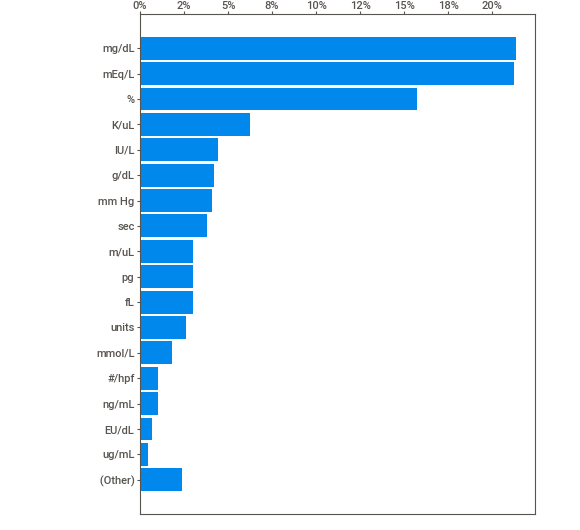
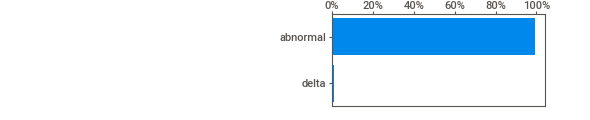
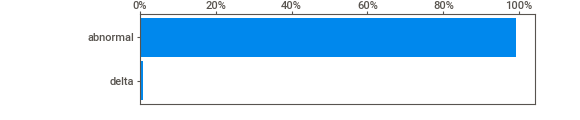
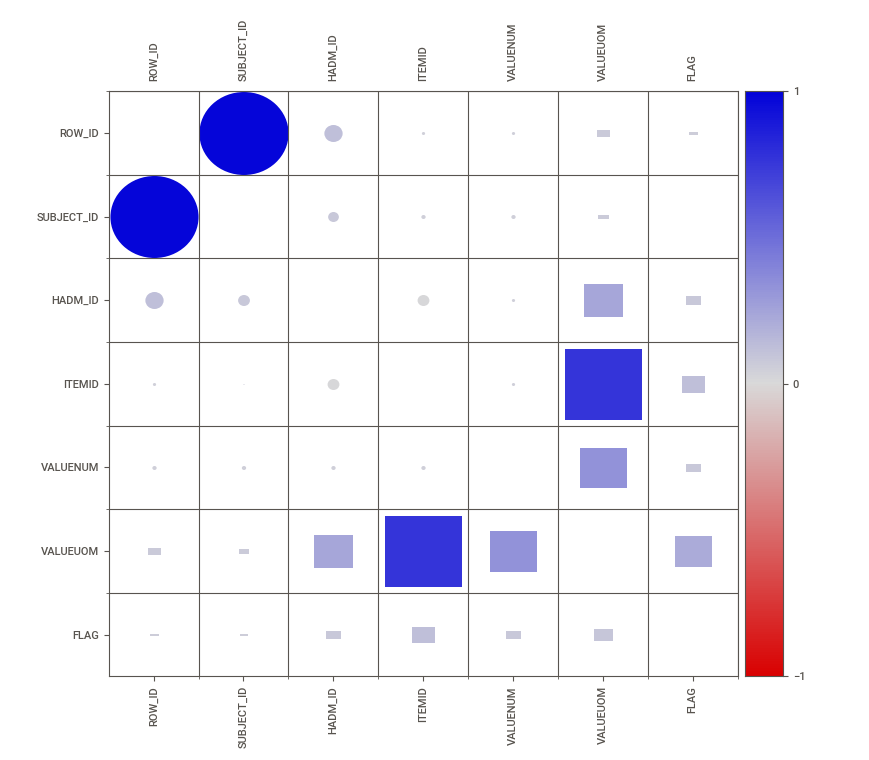
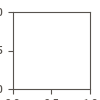

In [22]:
labevents_report=sv.analyze(df_labevents_full.iloc[:100000])
labevents_report.show_notebook()

The summary of "Labevents" dataset shows that:
1. For HADM_ID column there are 26% missing rows and it has 215 unique HADM_ID.
2. ITEMID column doesn't have any missing values and has 413 unique values.
3. FLAG column has 2 distinct values such as abnormal and normal (NA). There are 34905 abnormal flag whereas 65095 normal flags.


#### 2. Diagnoses dataset

                                             |          | [  0%]   00:00 -> (? left)


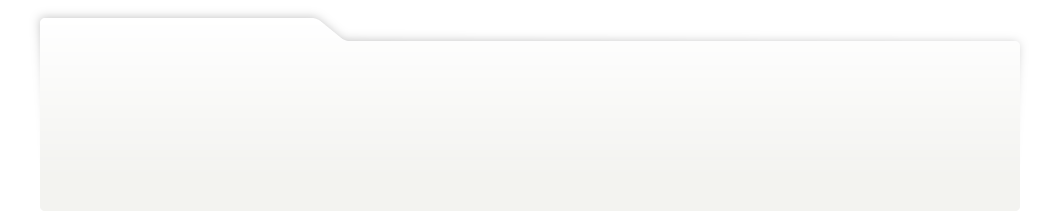
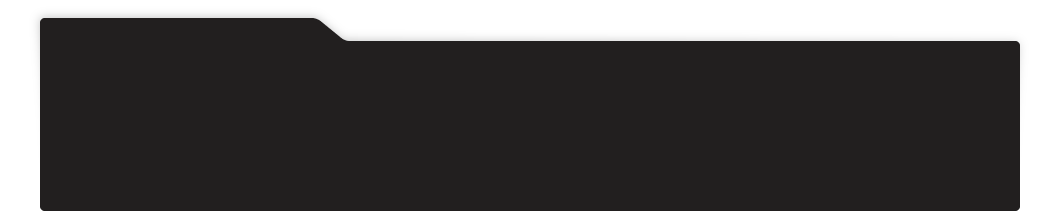
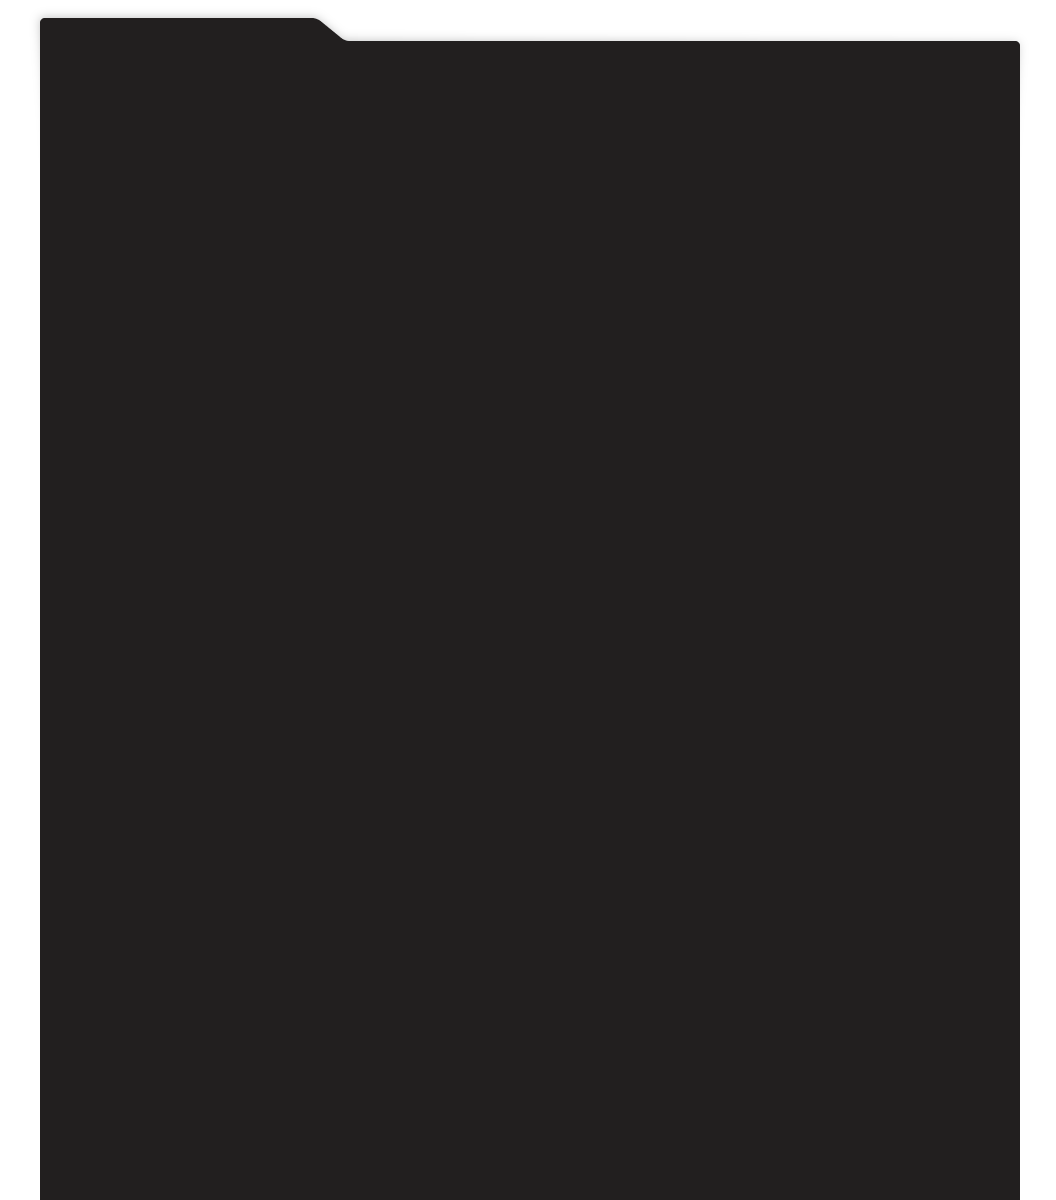
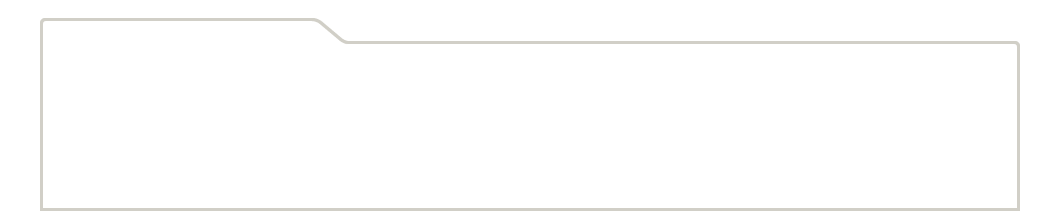
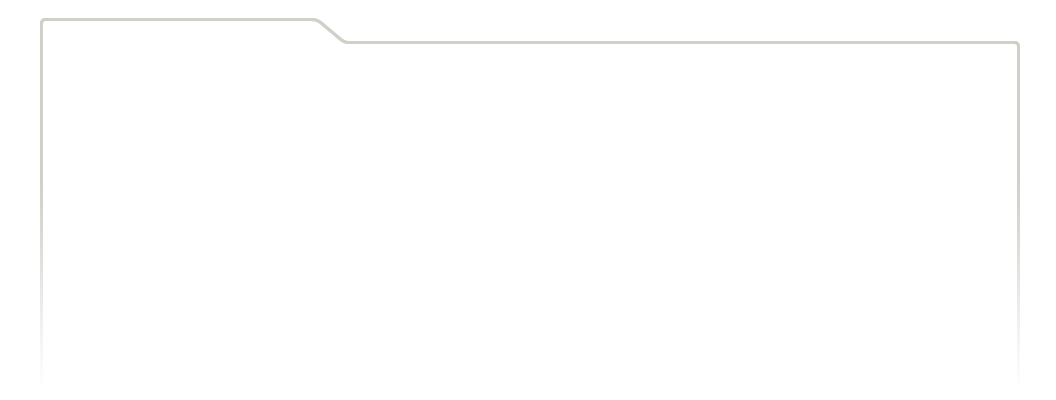
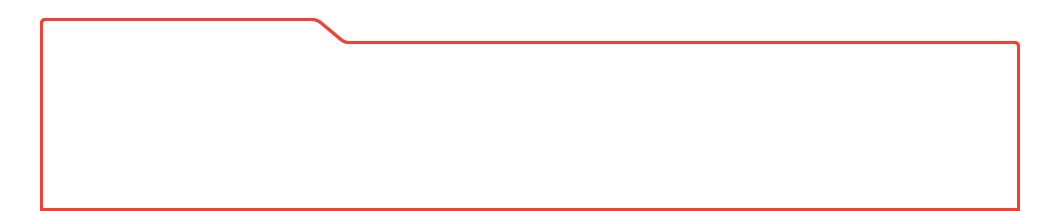
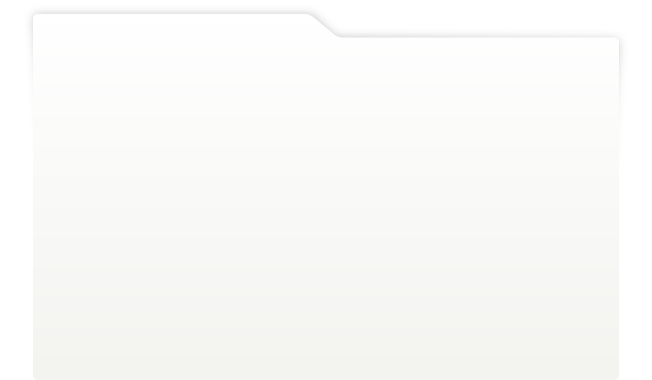
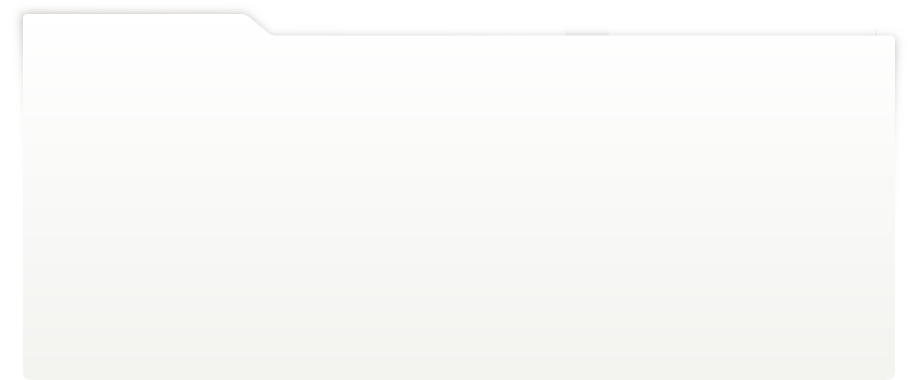
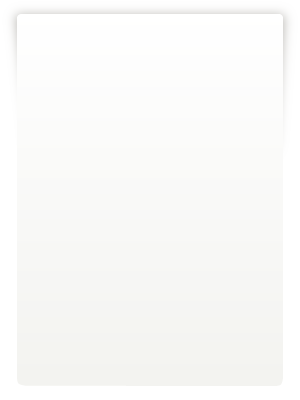
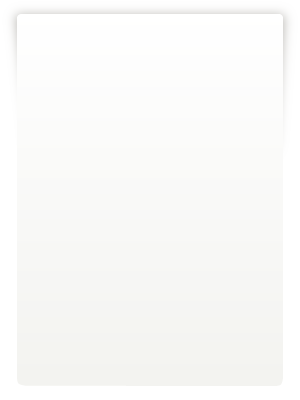
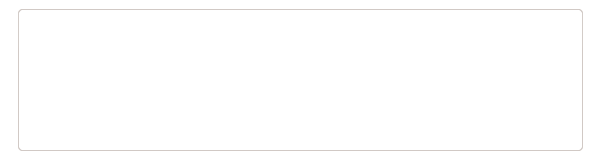
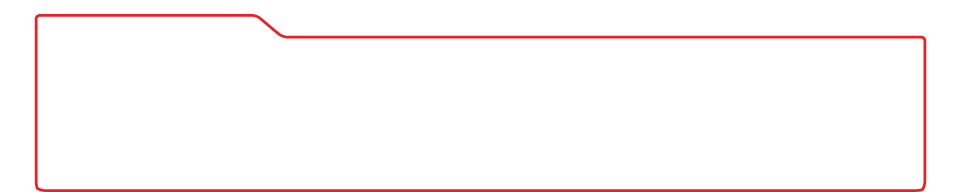
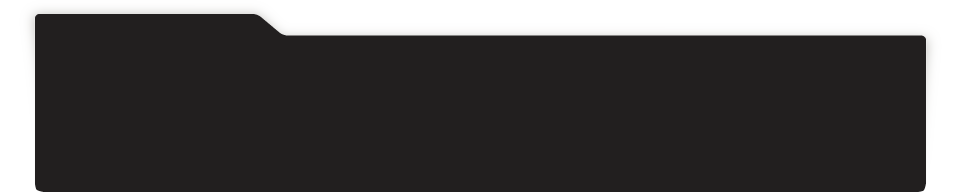
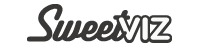
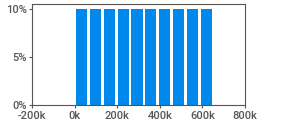
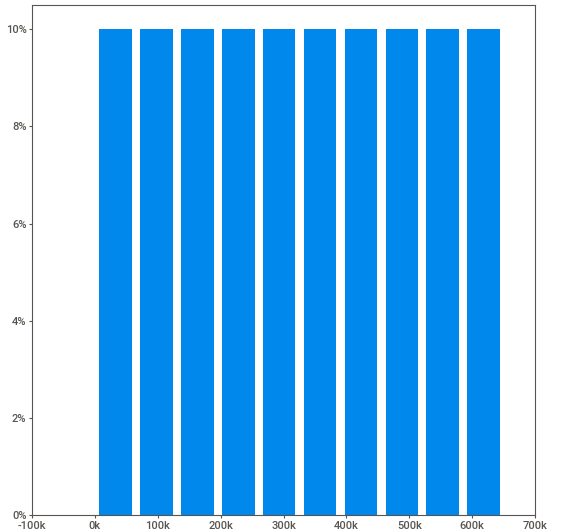
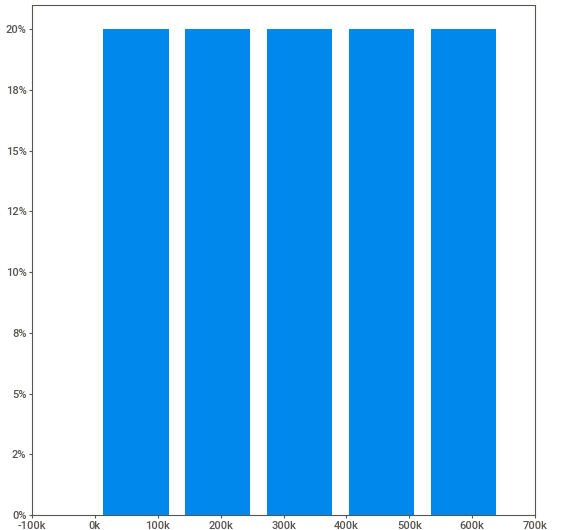
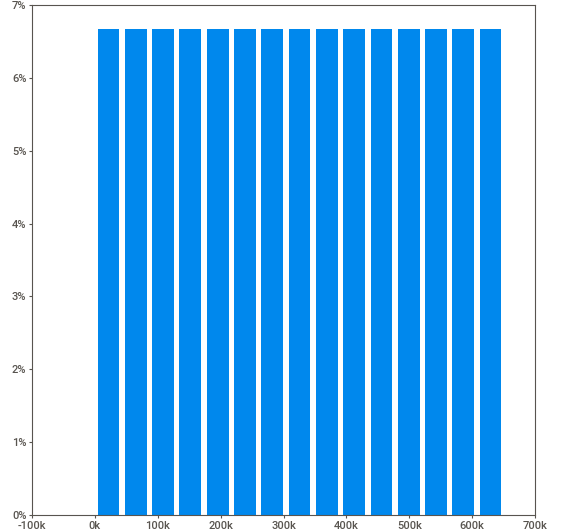
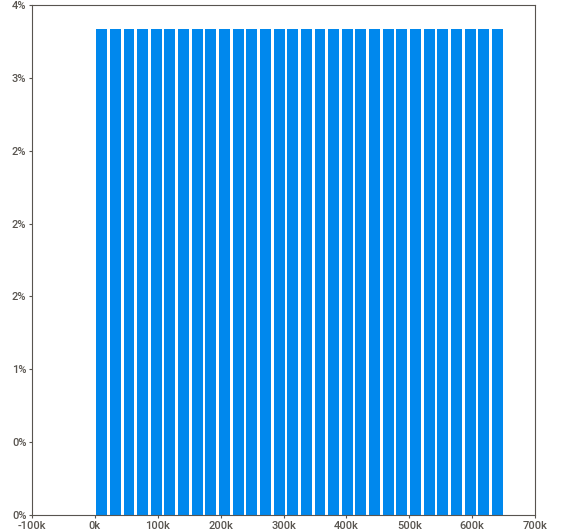
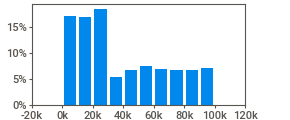
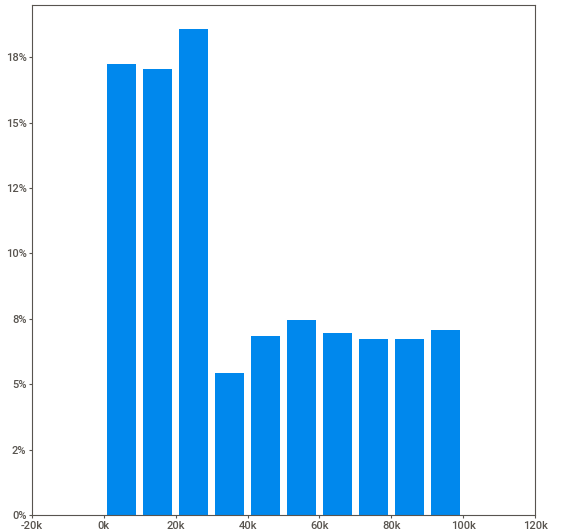
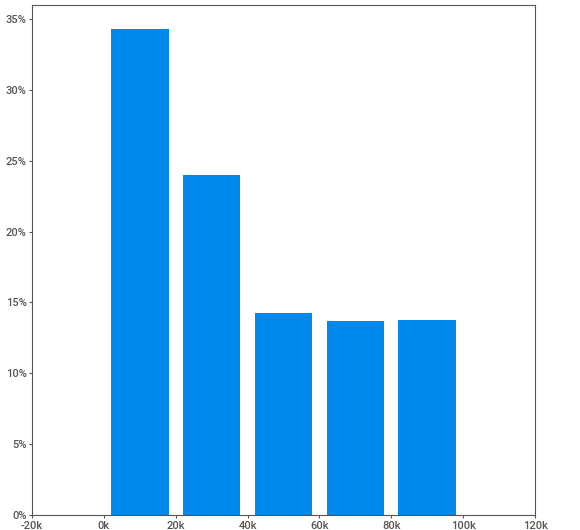
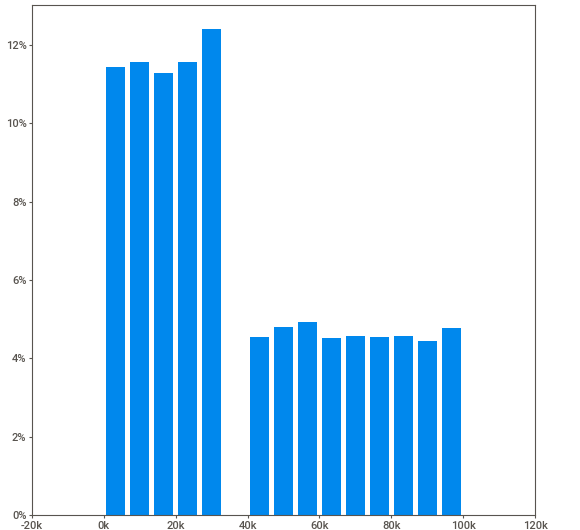
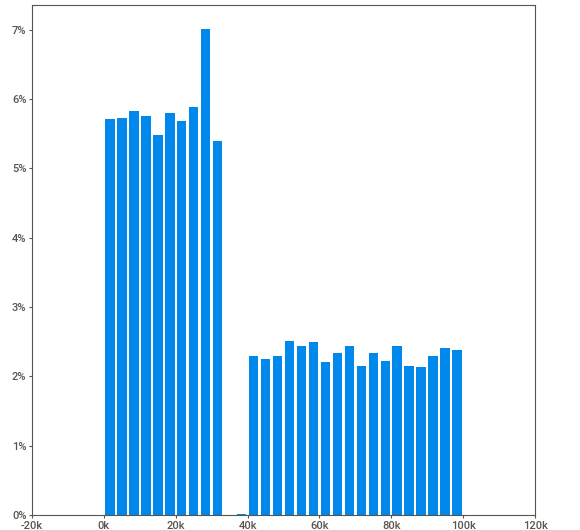
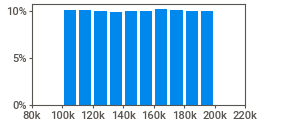
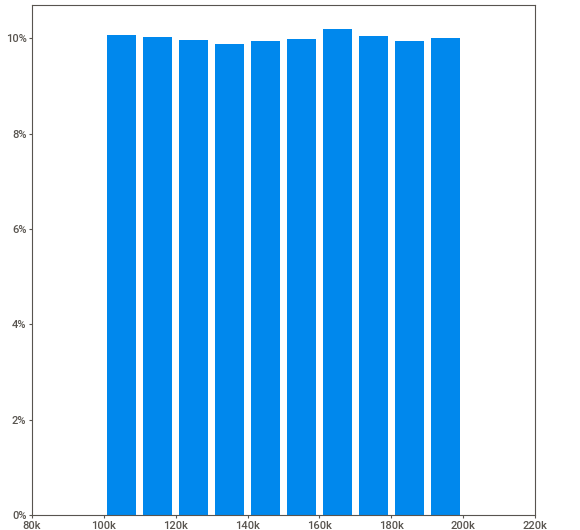
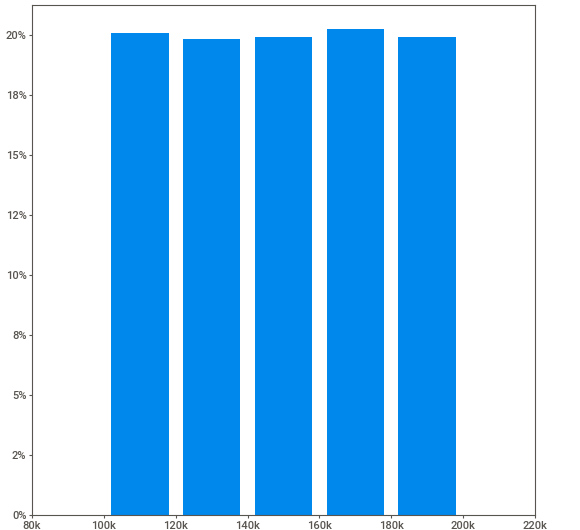
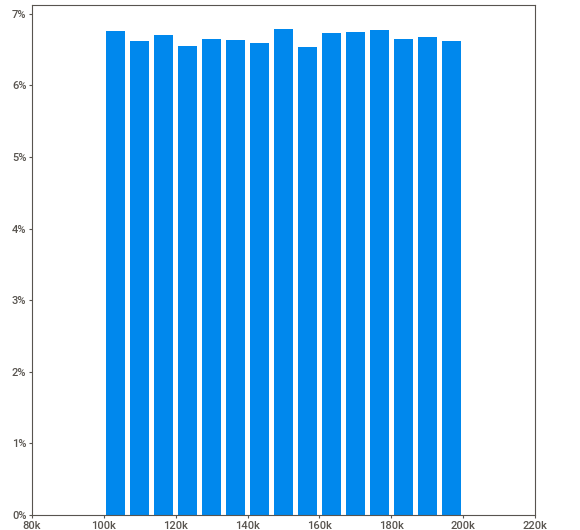
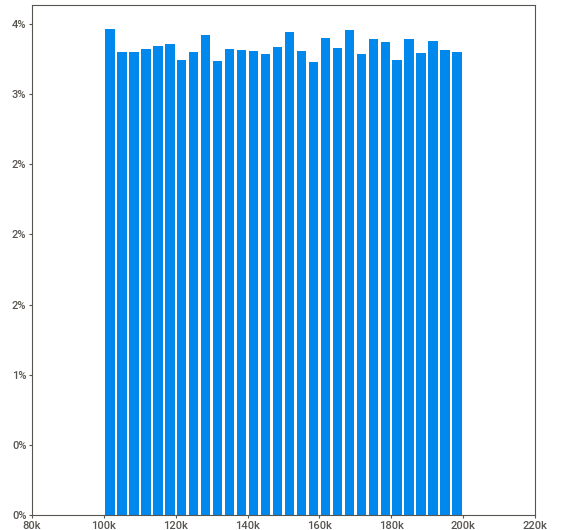
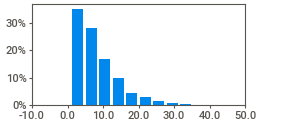
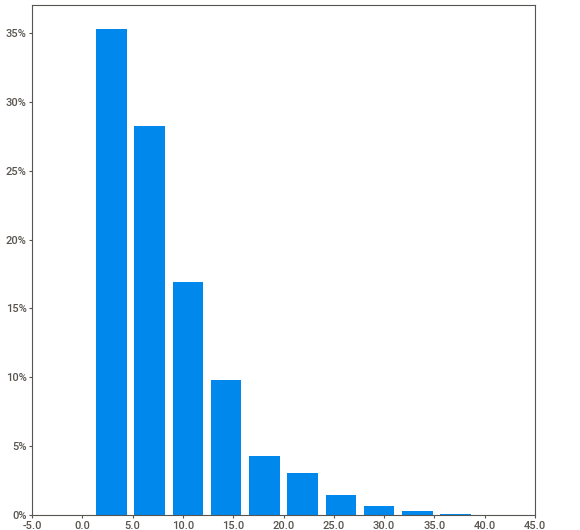
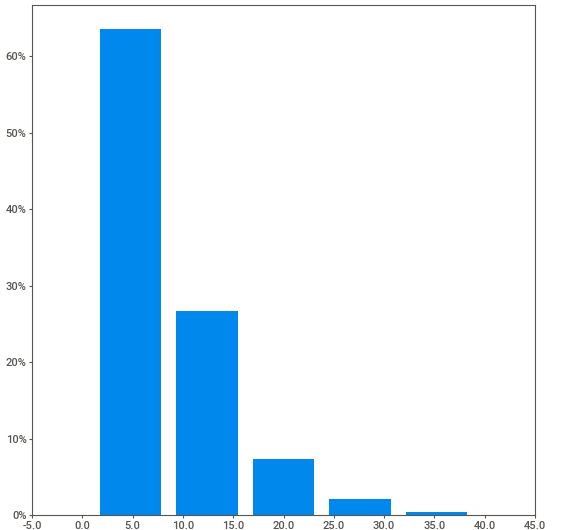
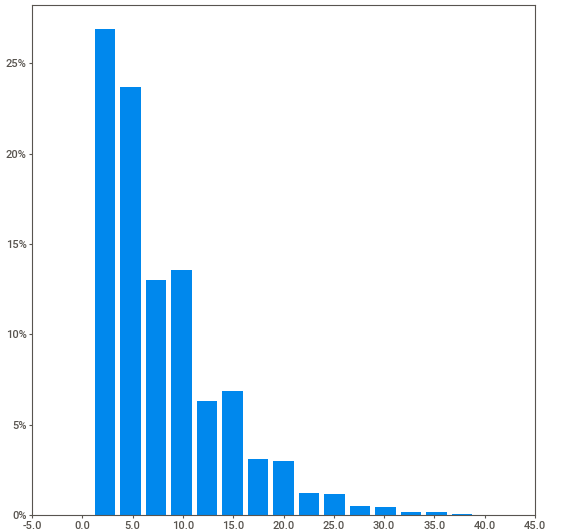
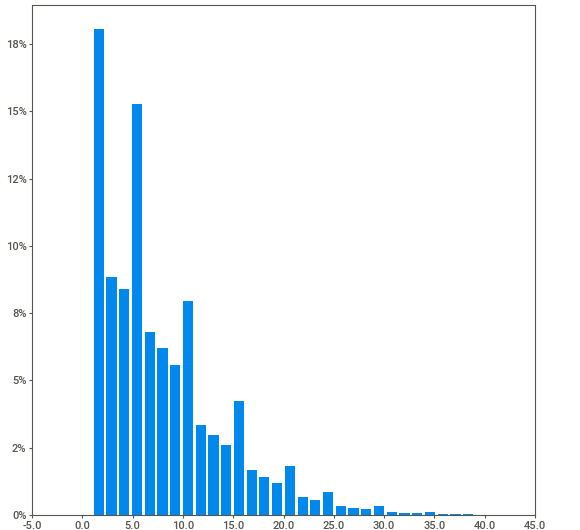
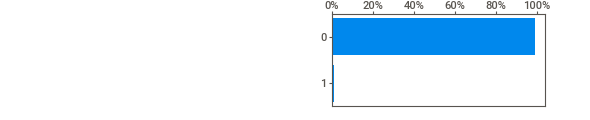
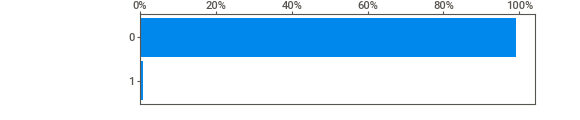
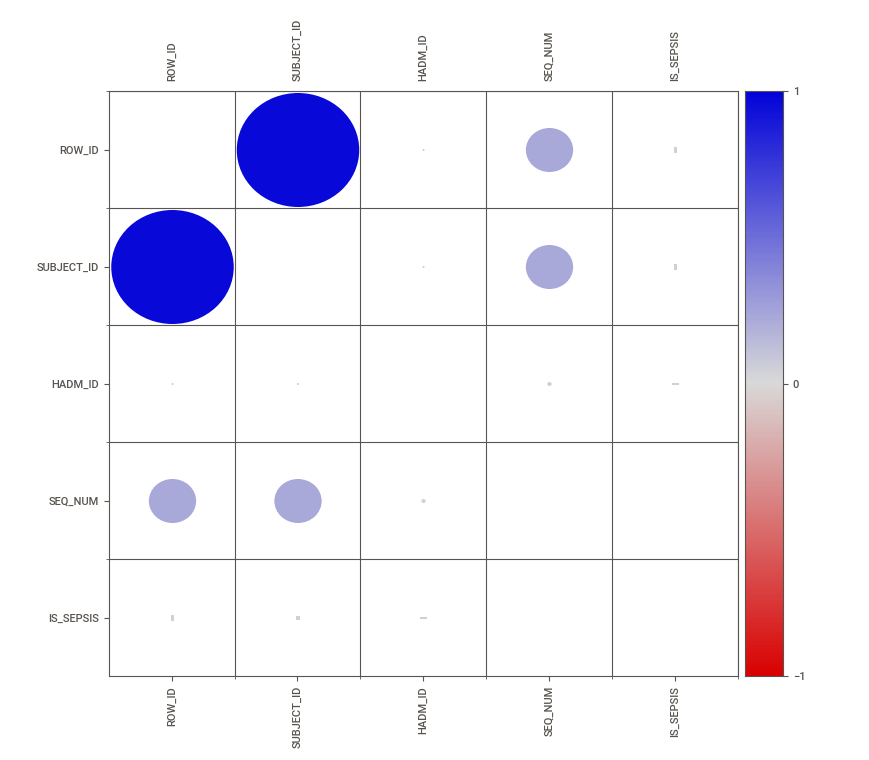
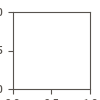

In [23]:
diagnoses_report=sv.analyze(df_diagnoses_icd_full)
diagnoses_report.show_notebook()

The summary of "Diagnoses" dataset shows that:
1. There are 58,976 unique HADM_IDs.
2. ICD9_CODE column has only 47 missing values and 6,984 unique ICD09 codes.
3. IS_SEPSIS column has no missing values. There are 645,638 patients are  Non-Sepsis and 5,409 number of Sepsis patients. 

#### 3. Microbiology events dataset

                                             |          | [  0%]   00:00 -> (? left)


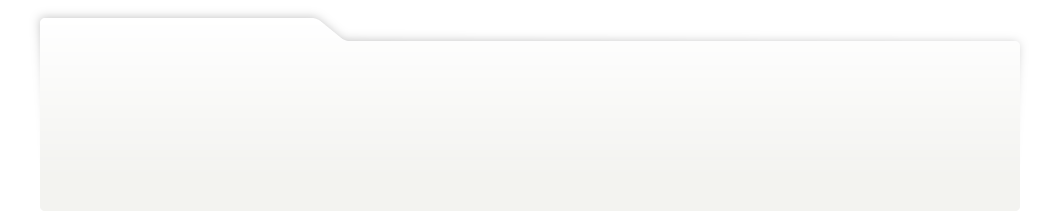
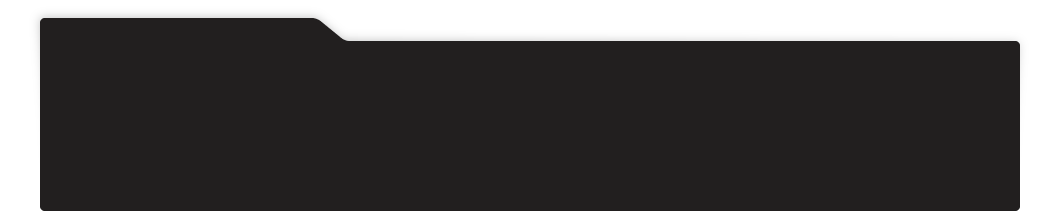
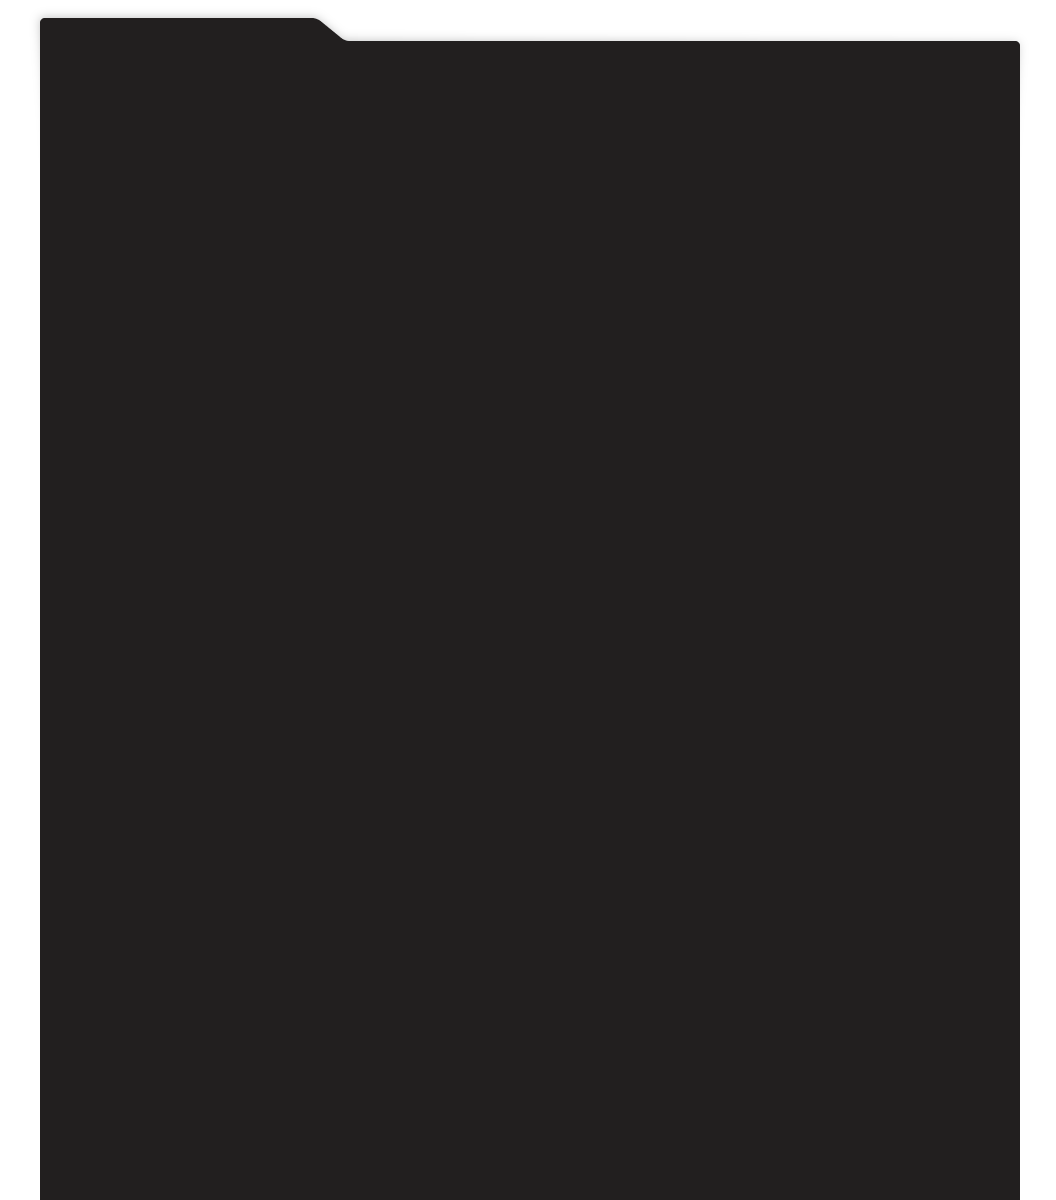
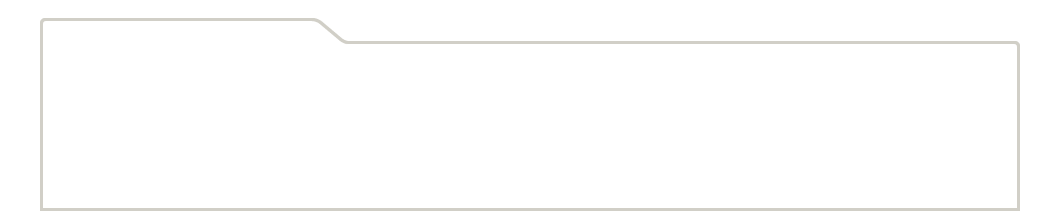
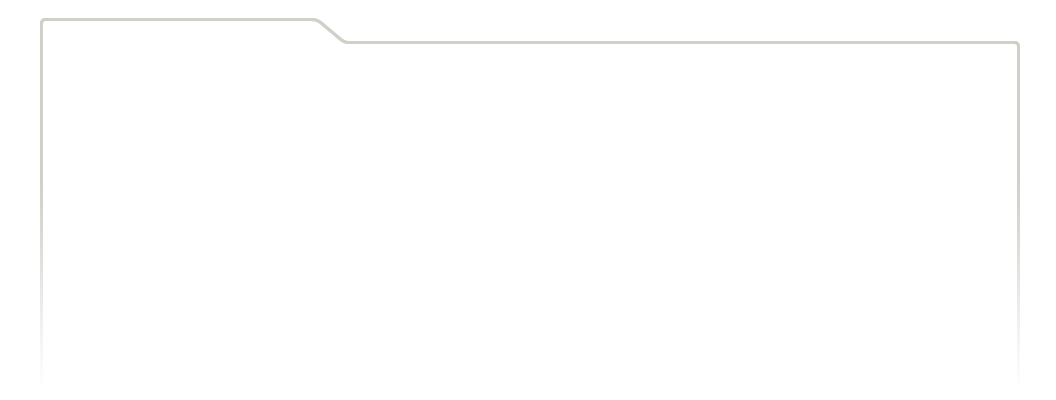
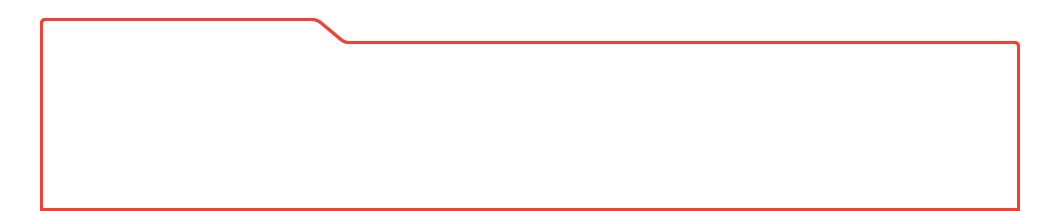
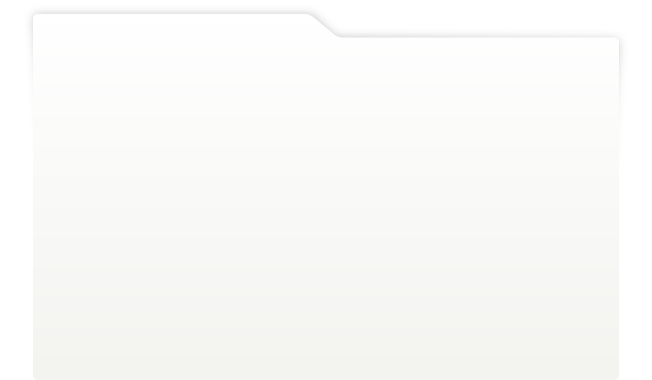
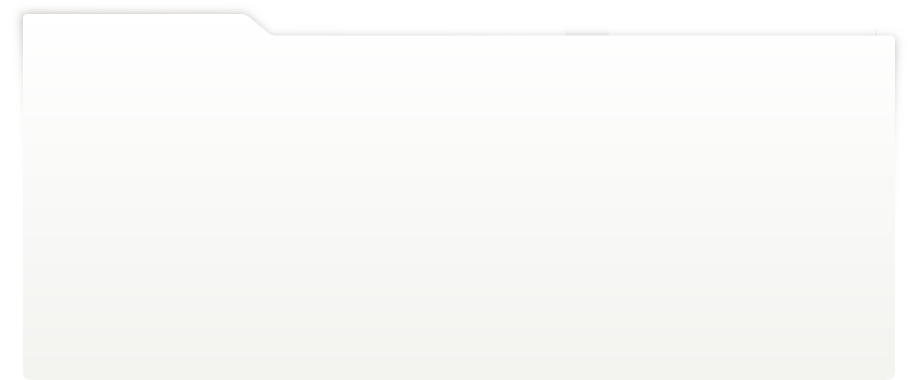
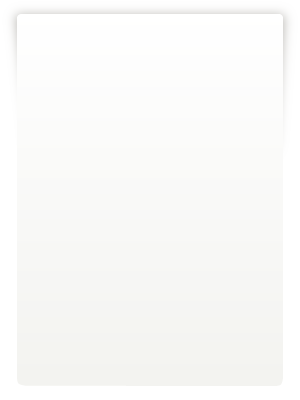
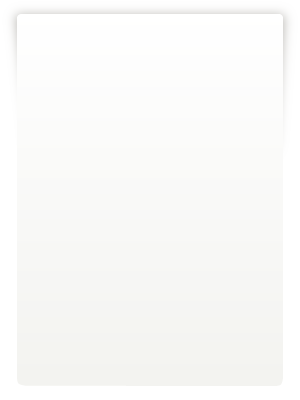
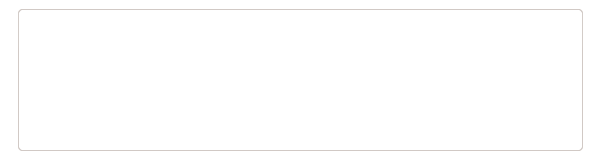
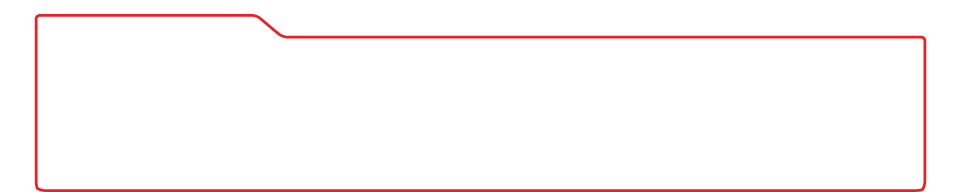
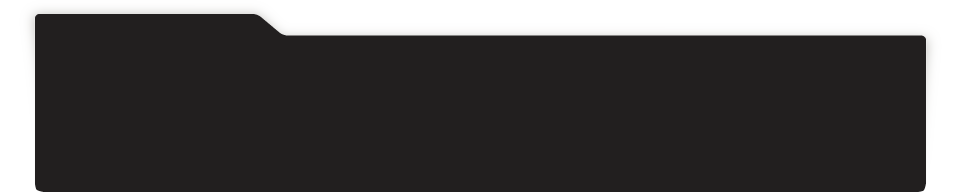
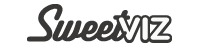
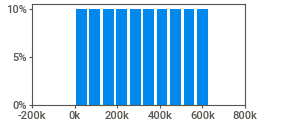
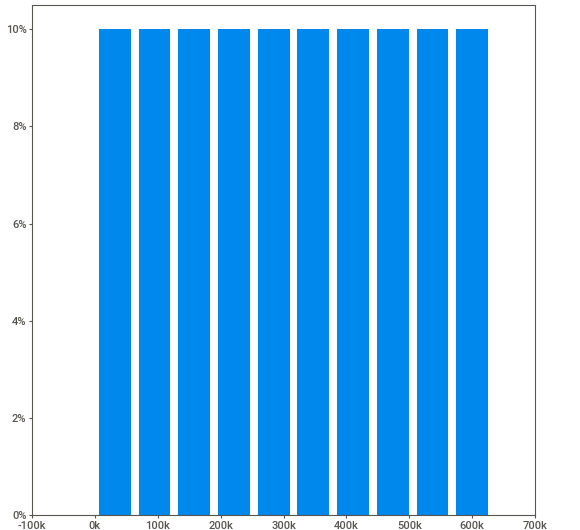
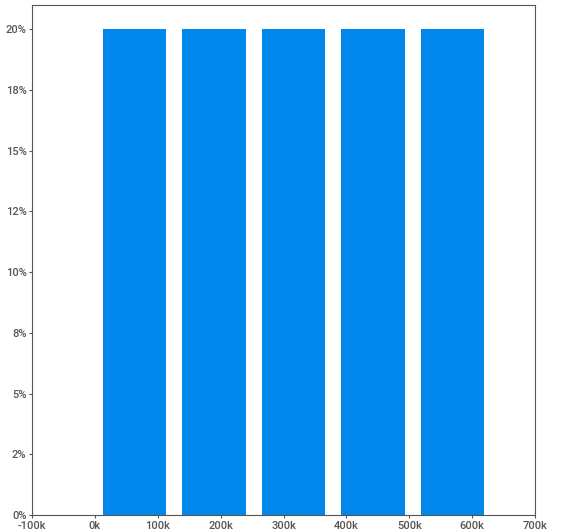
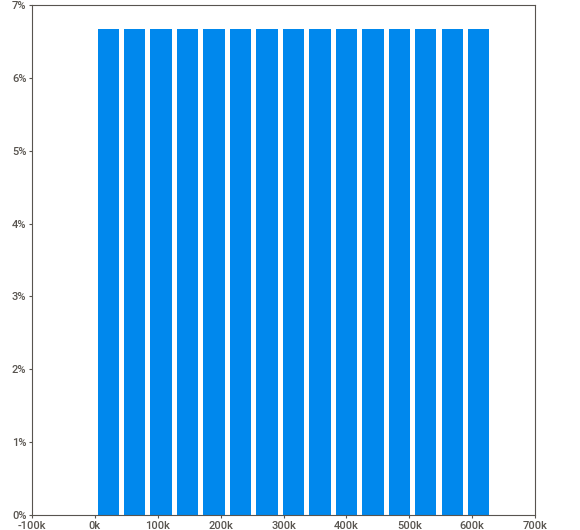
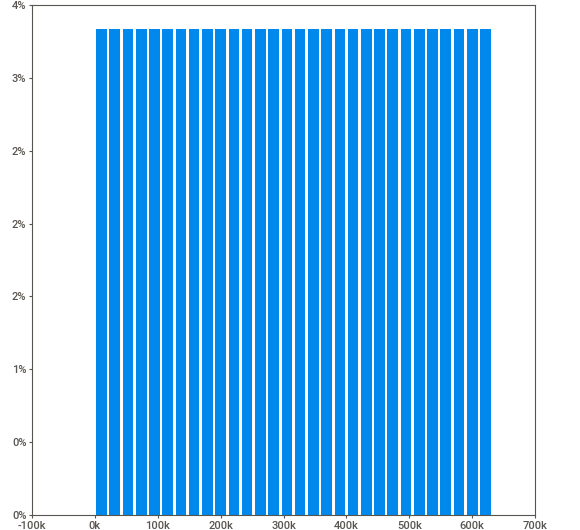
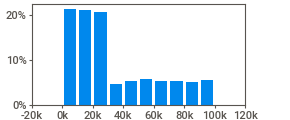
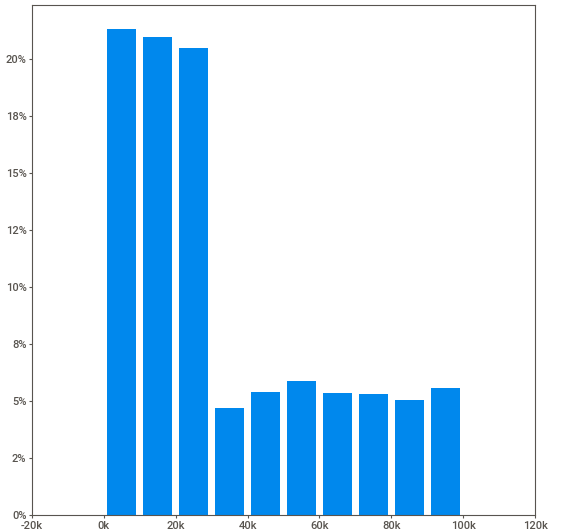
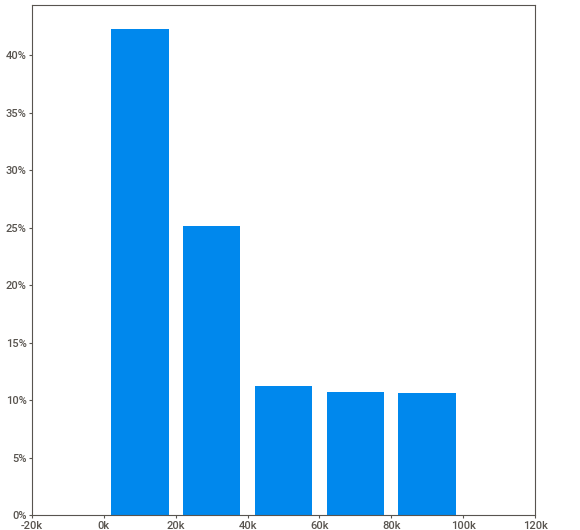
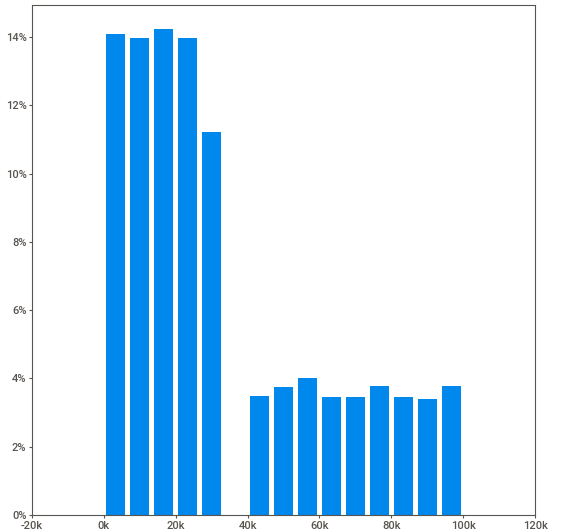
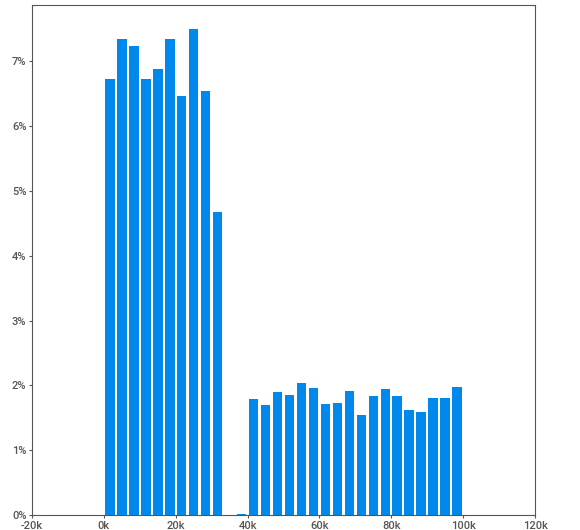
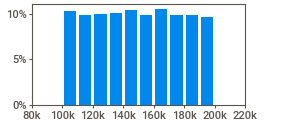
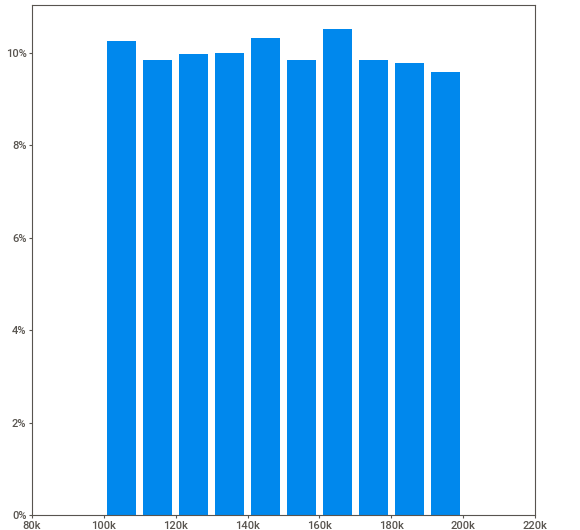
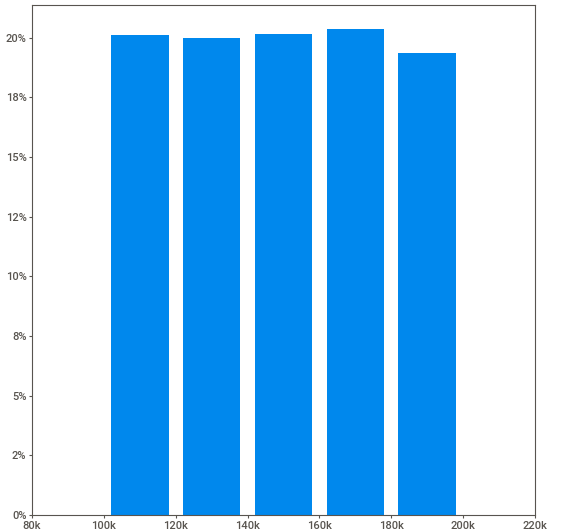
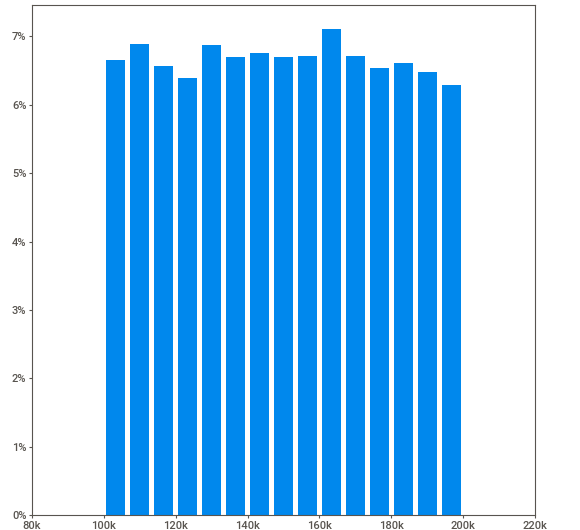
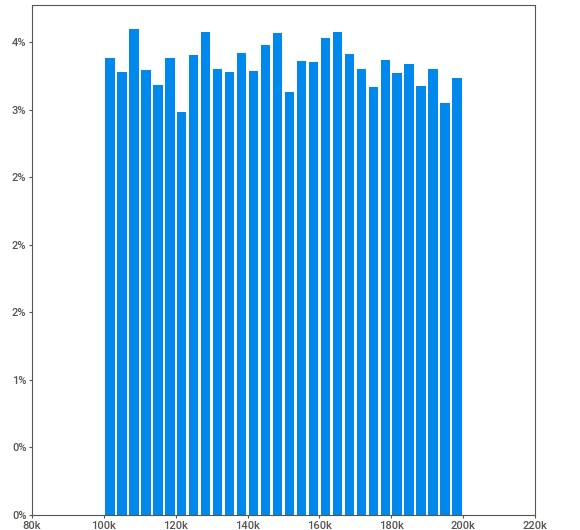
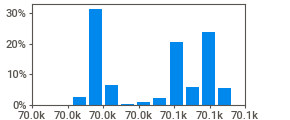
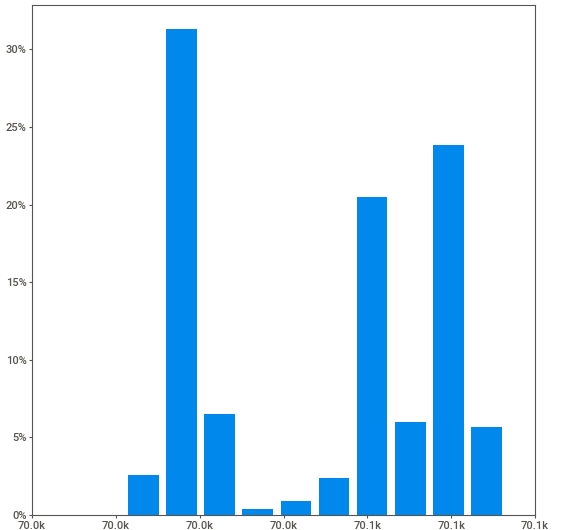
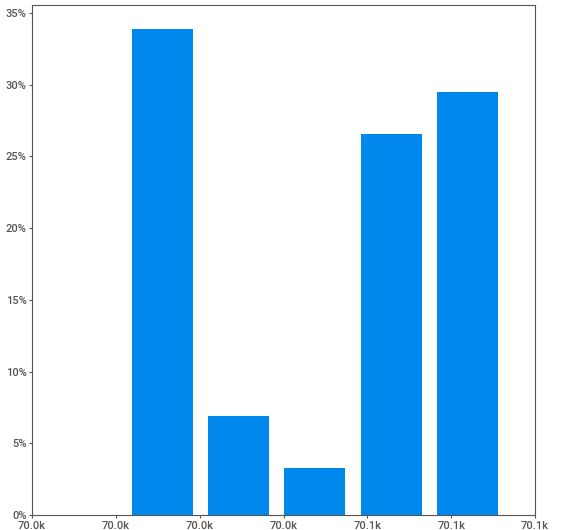
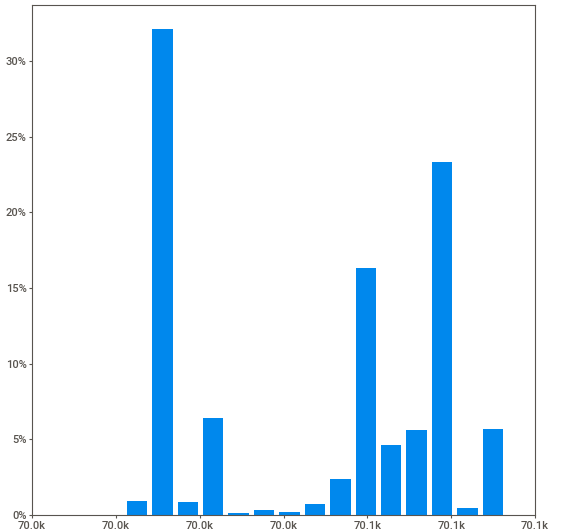
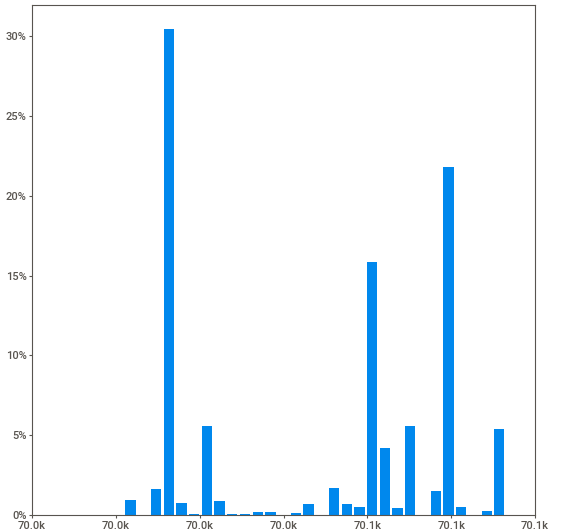
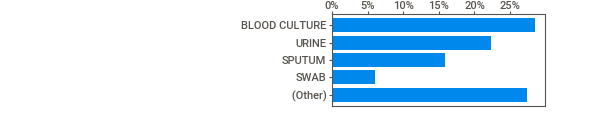
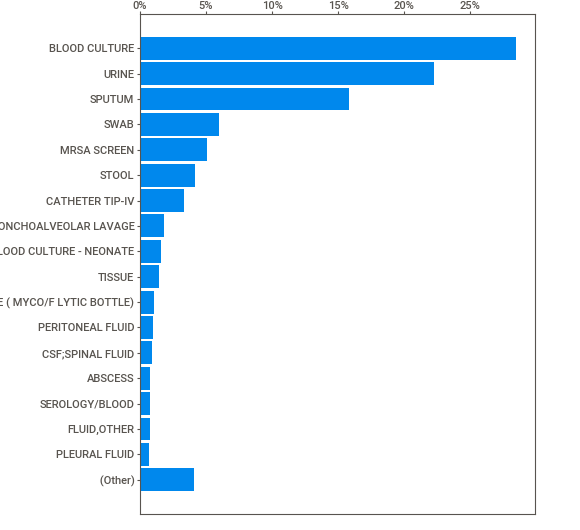
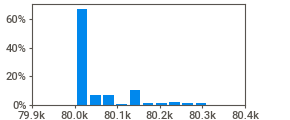
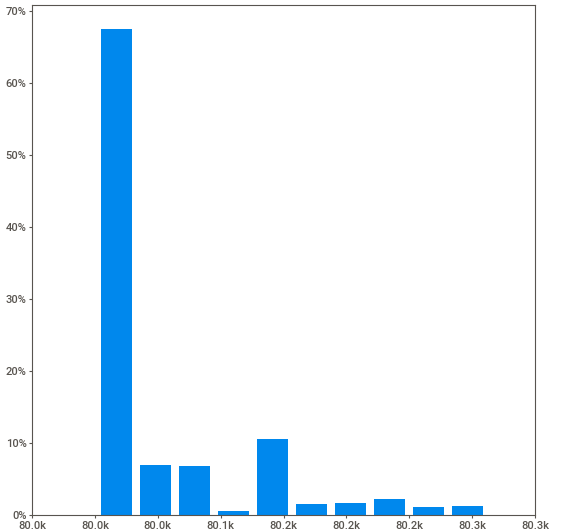
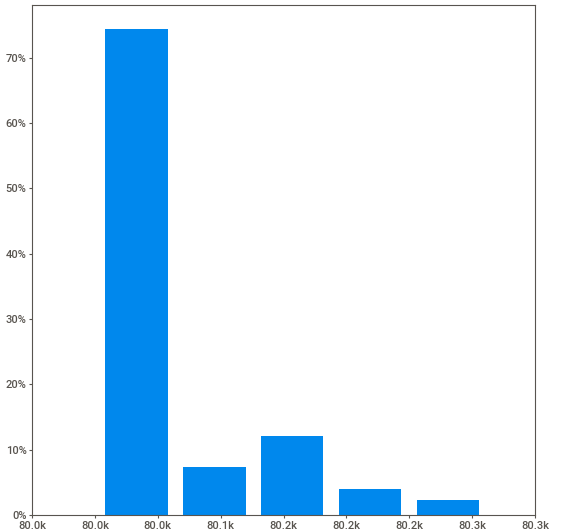
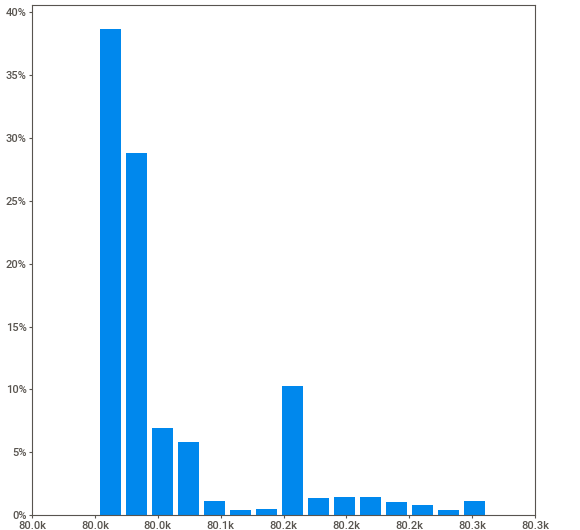
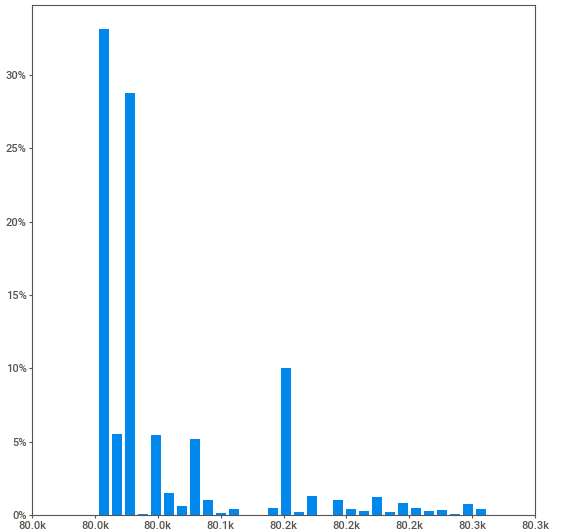
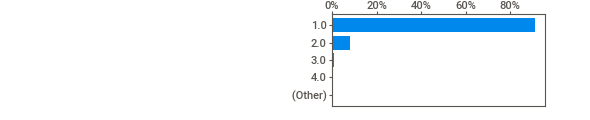
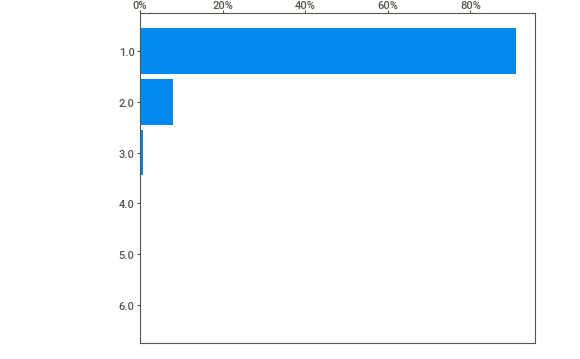
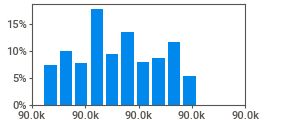
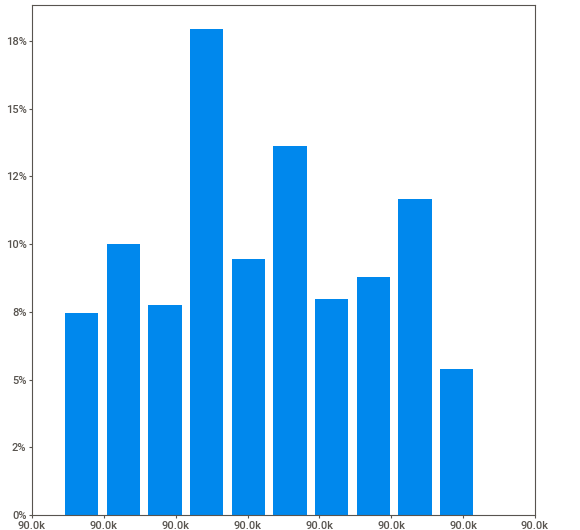
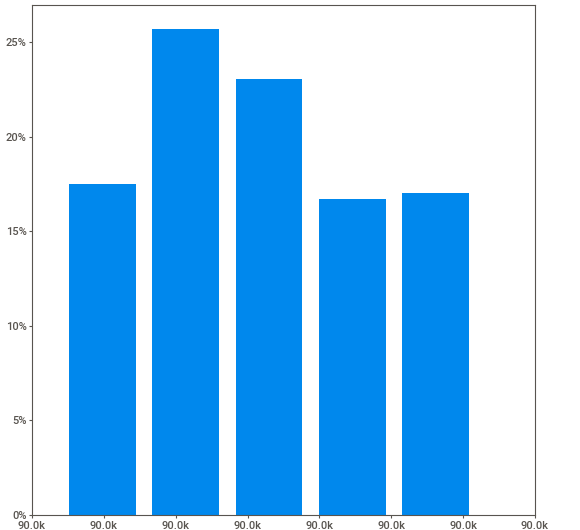
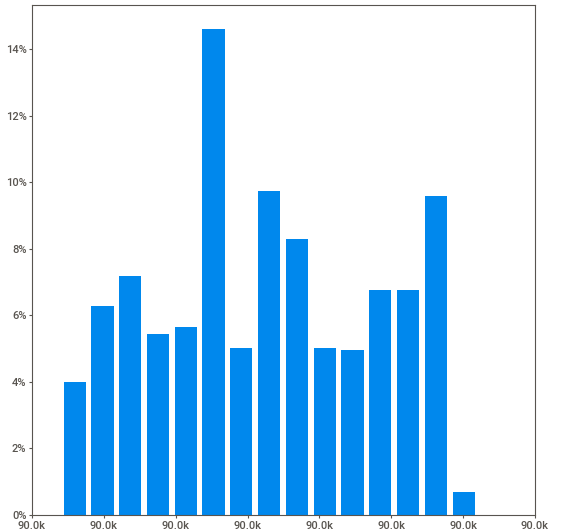
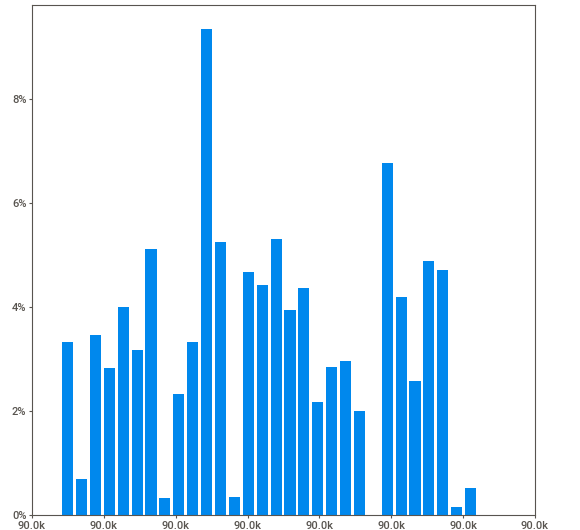
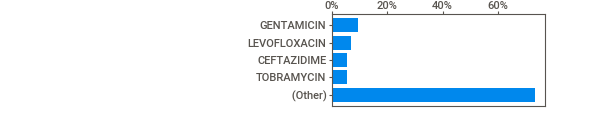
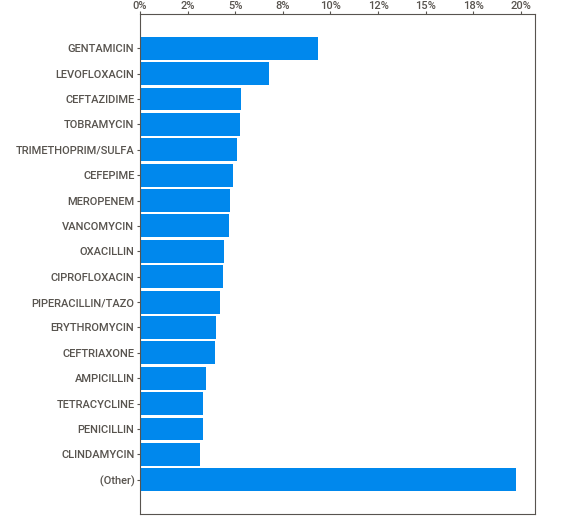
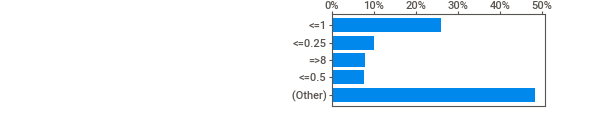
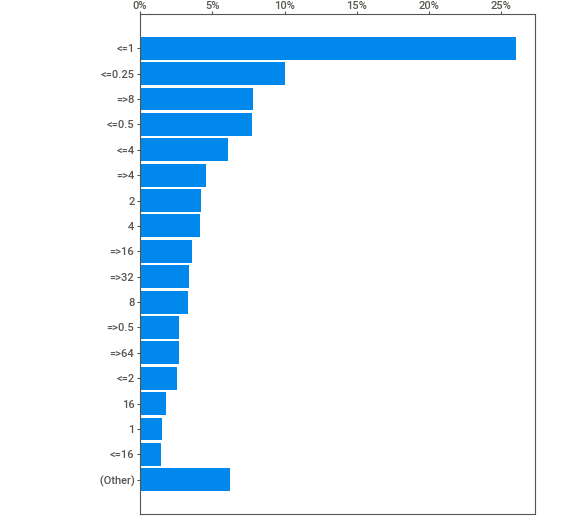
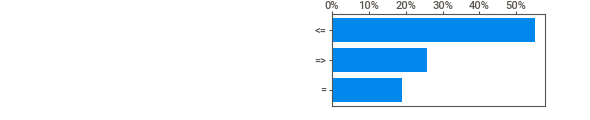
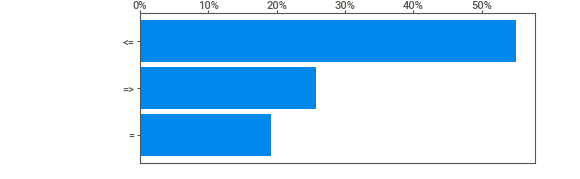
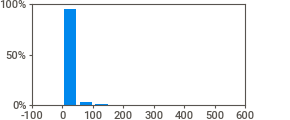
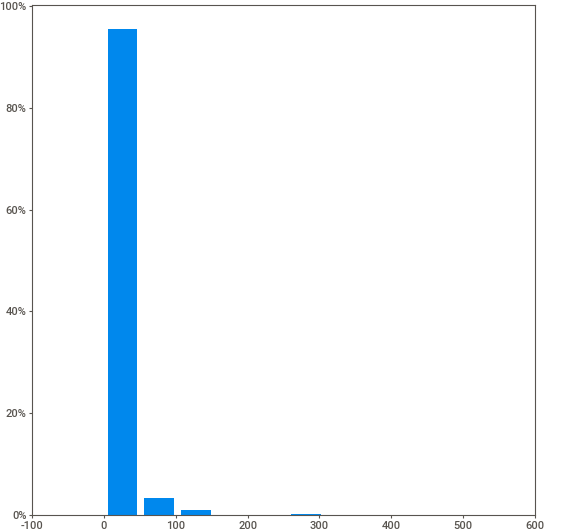
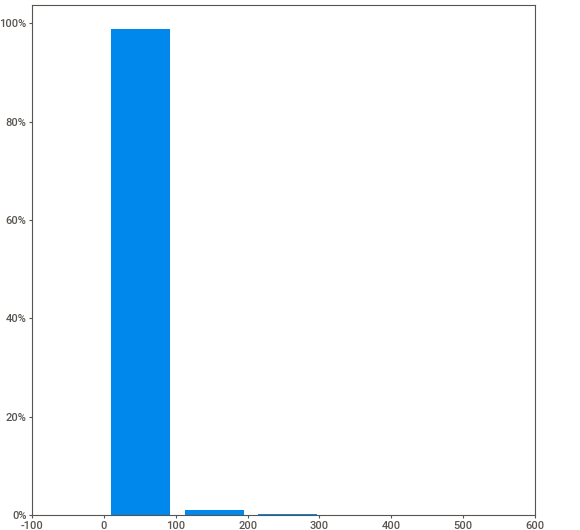
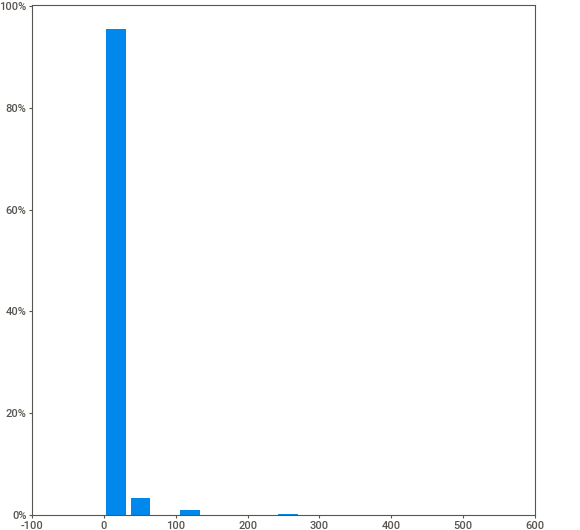
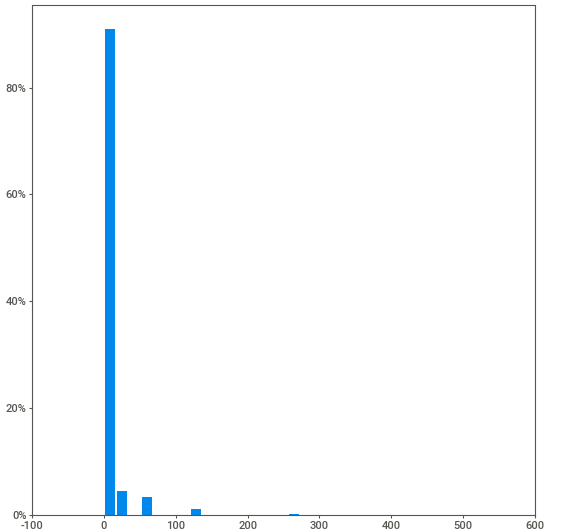
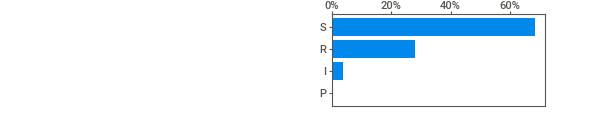
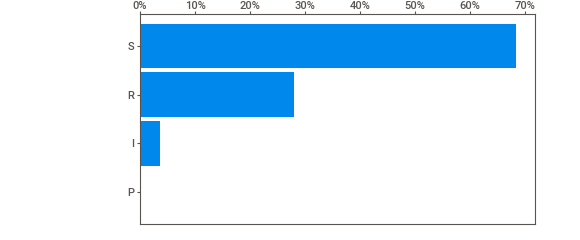
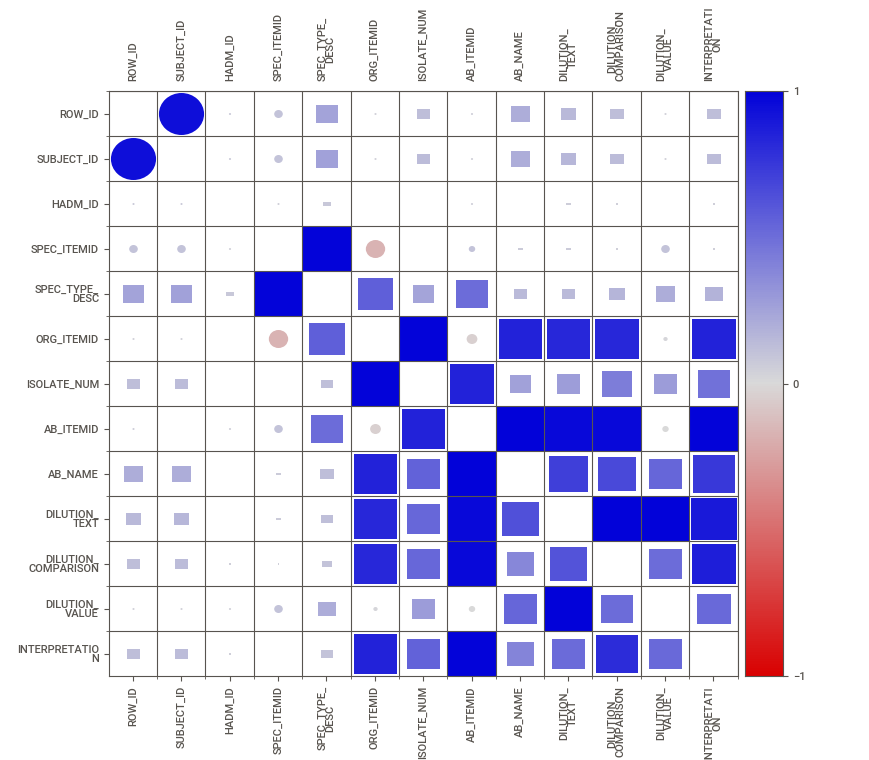
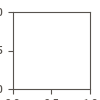

In [27]:
microbioevents_report=sv.analyze(df_microbiologyevents_full)
microbioevents_report.show_notebook()

The summary of Microbiology events dataset shows:
1. 48% of the Organisms ITEMID values are missing.
2. There is 87 unique Special Types where BLOOD CULTURE and URINE types are the 2 most common types. 


#### 4. Patients dataset

                                             |          | [  0%]   00:00 -> (? left)


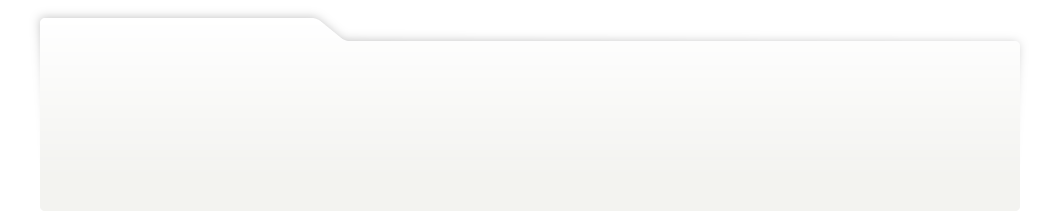
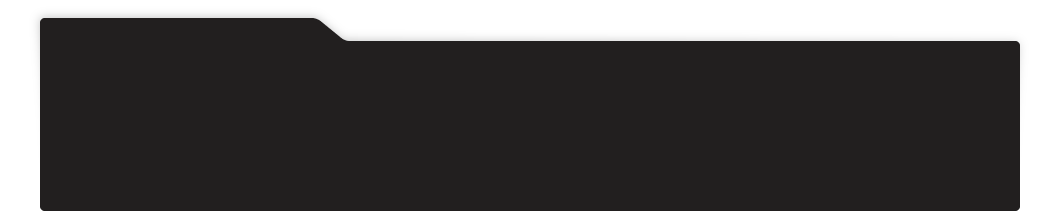
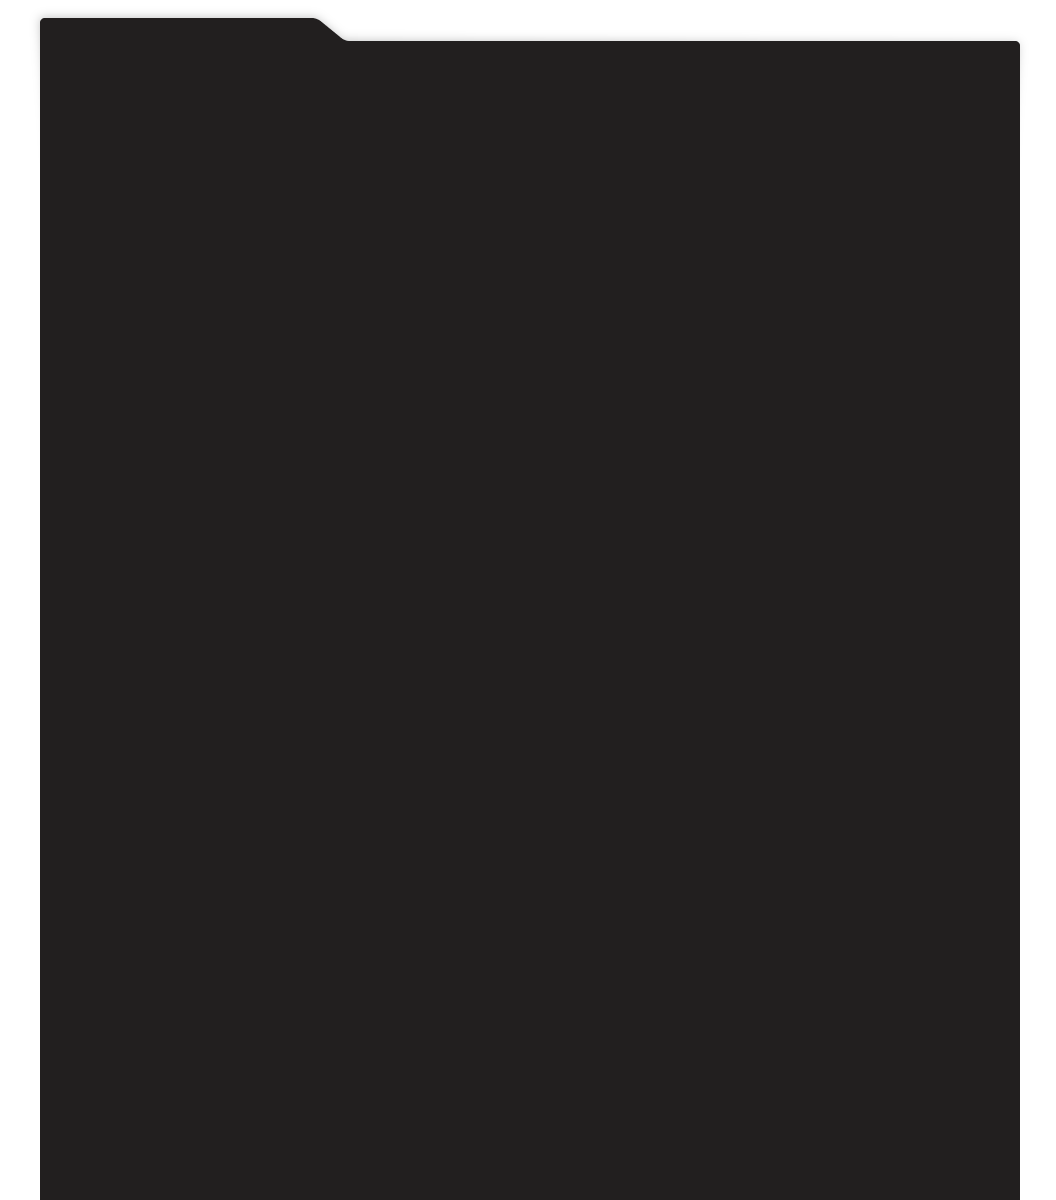
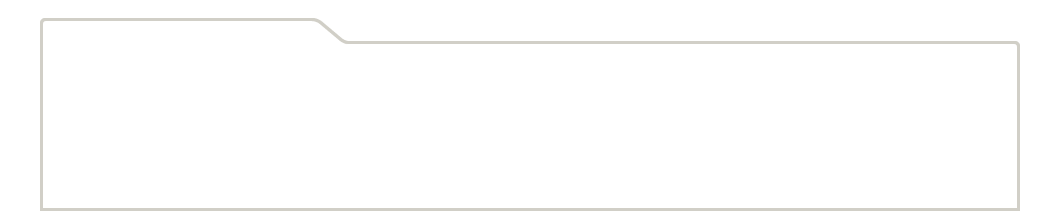
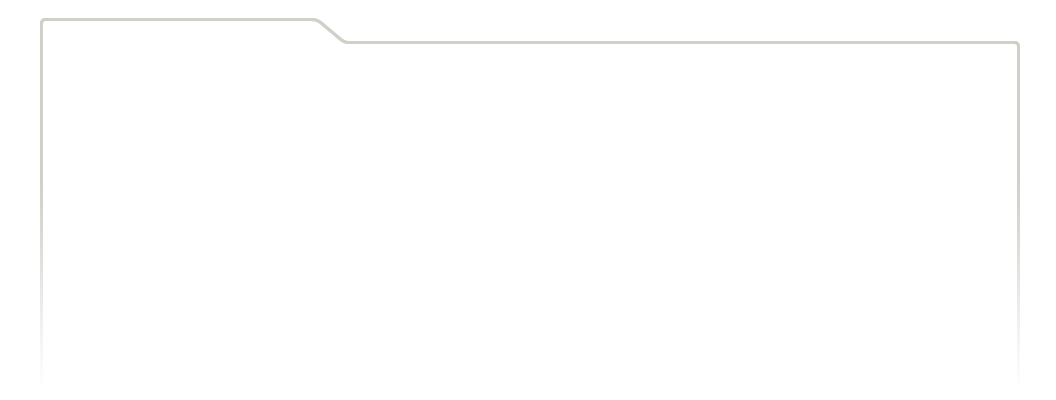
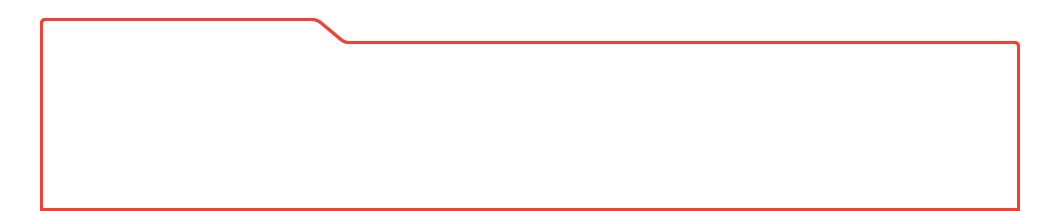
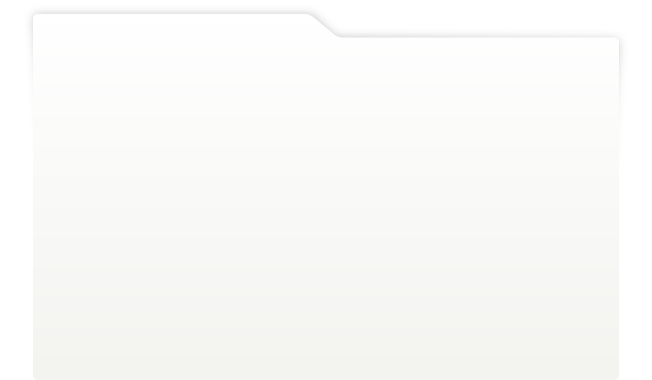
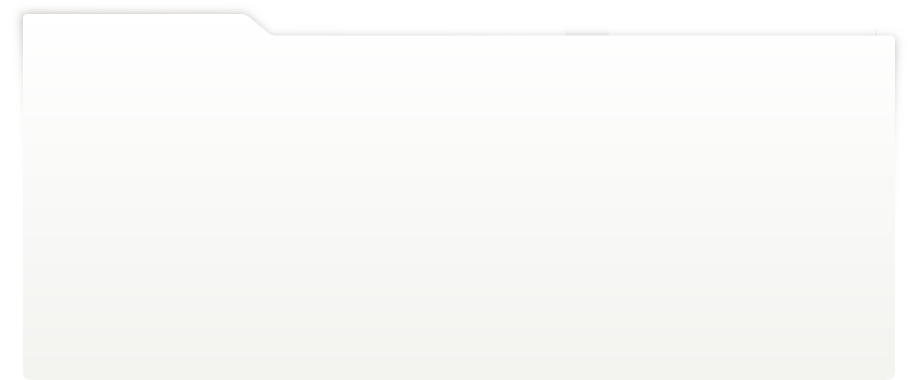
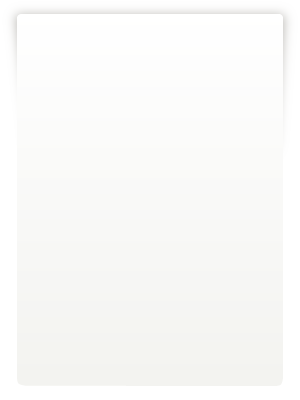
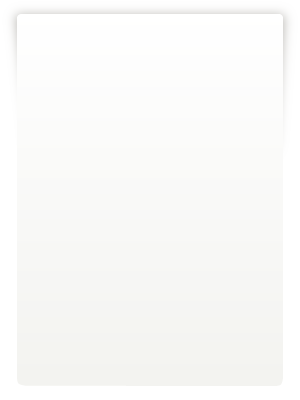
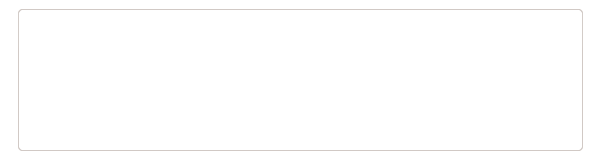
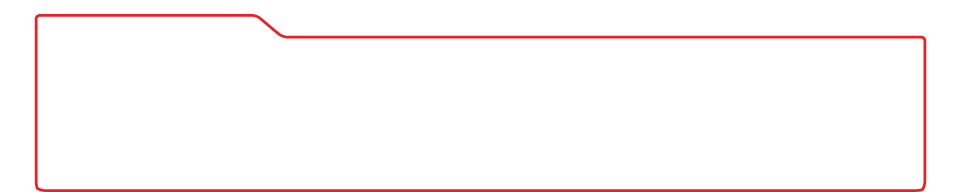
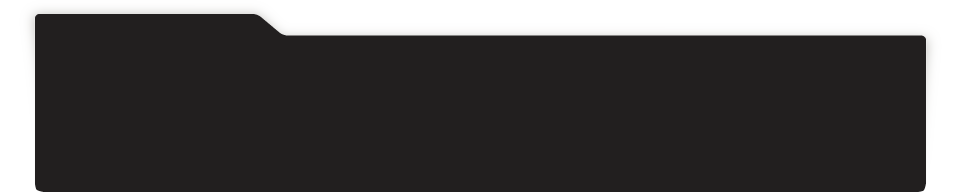
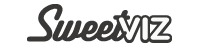
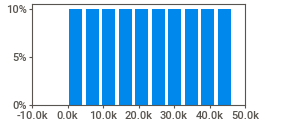
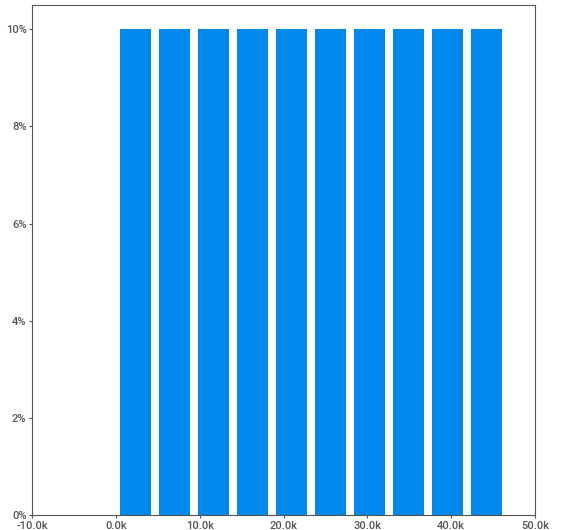
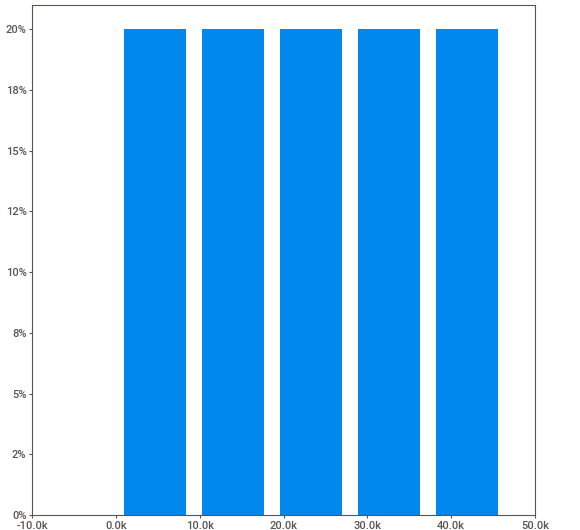
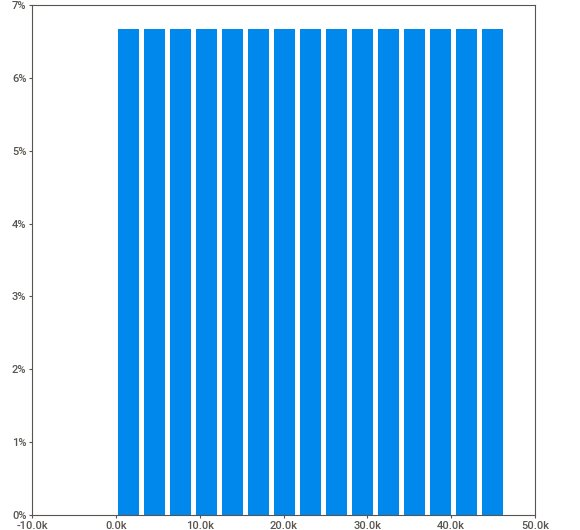
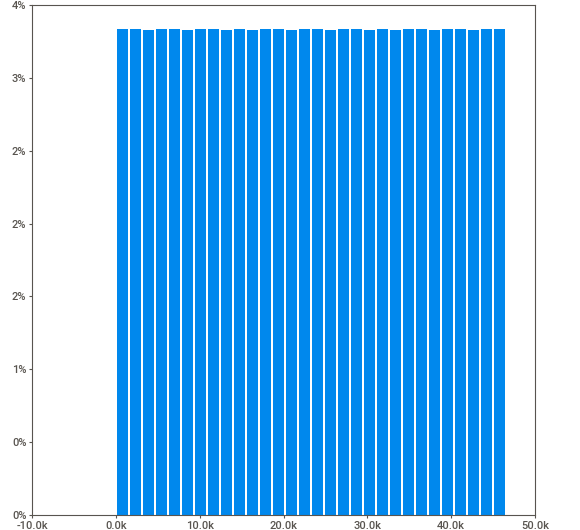
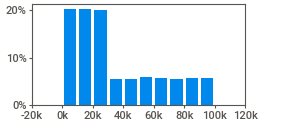
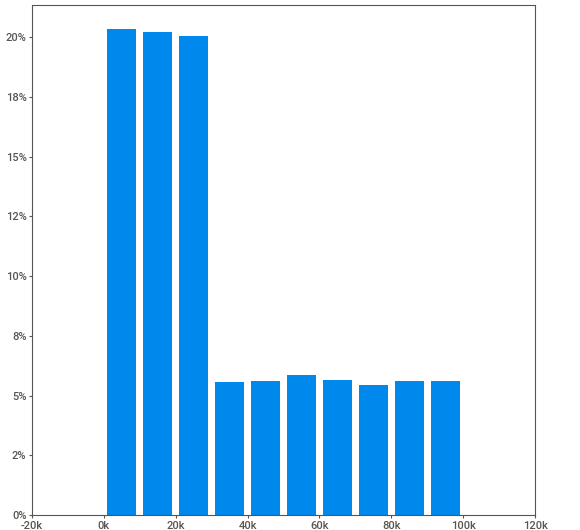
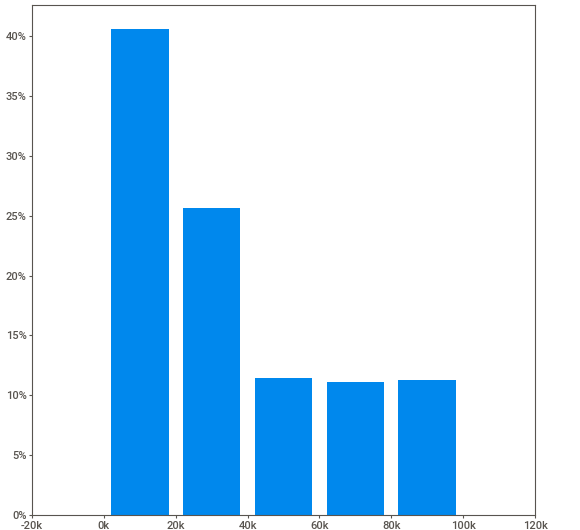
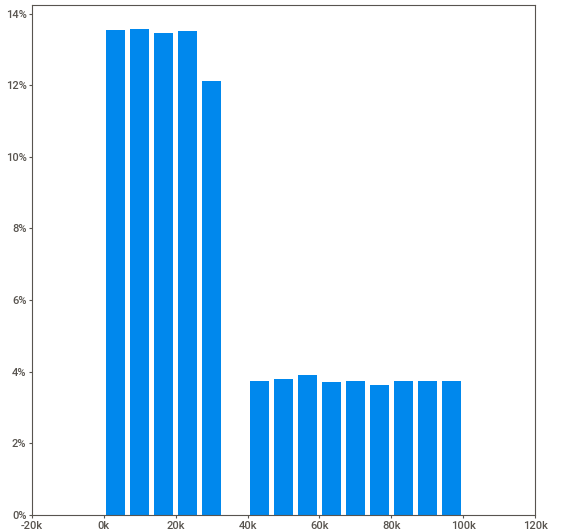
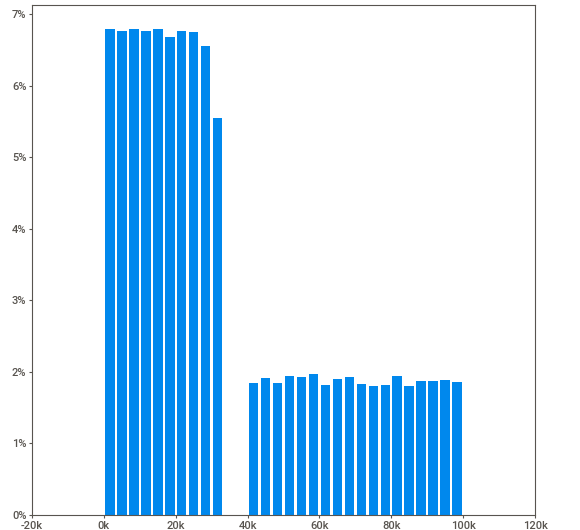
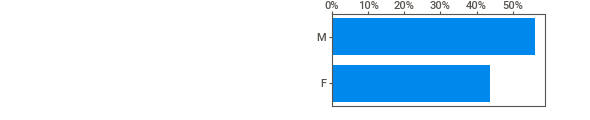
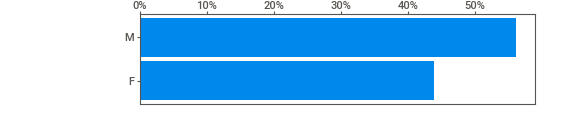
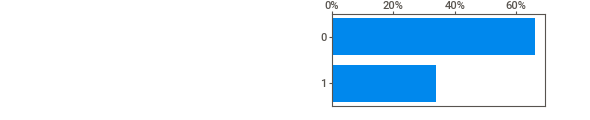
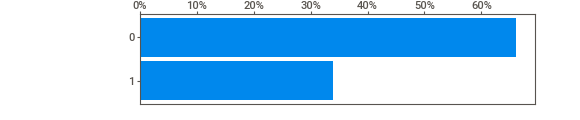
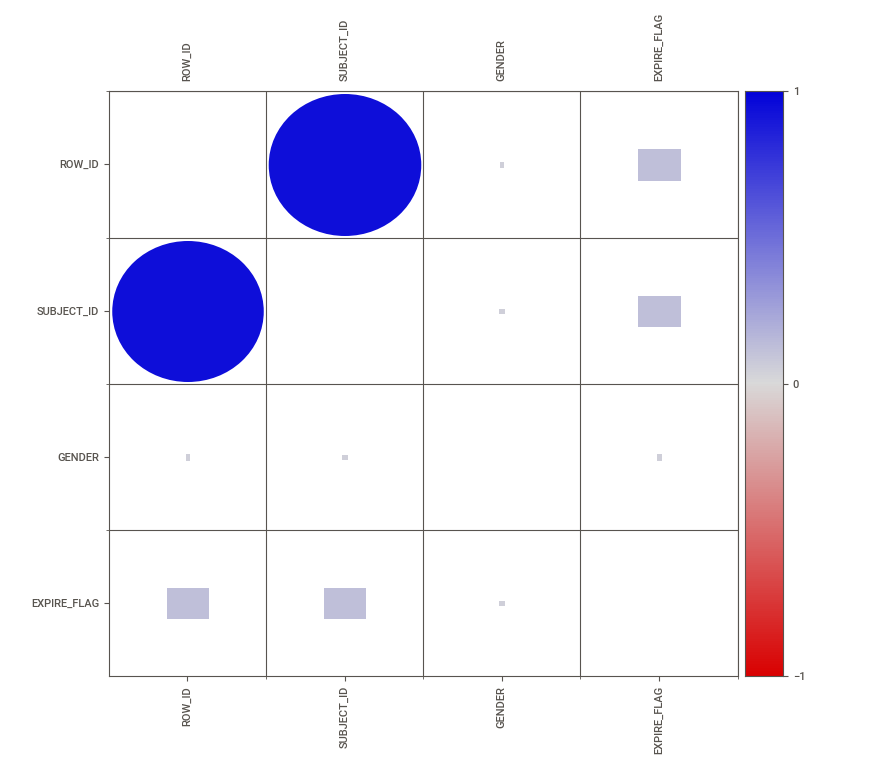
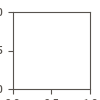

In [28]:
patients_report=sv.analyze(df_patients_full)
patients_report.show_notebook()

The summary of Patients dataset shows:
1. There are 46,520 patients where 56% of them are Male and 44% are Female.
2. 34% of the patients were died.


#### 5. Admissions dataset

                                             |          | [  0%]   00:00 -> (? left)


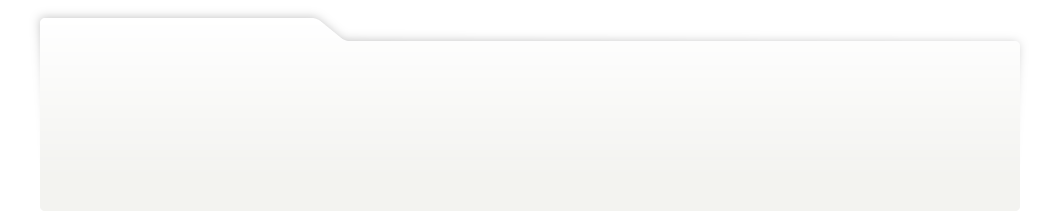
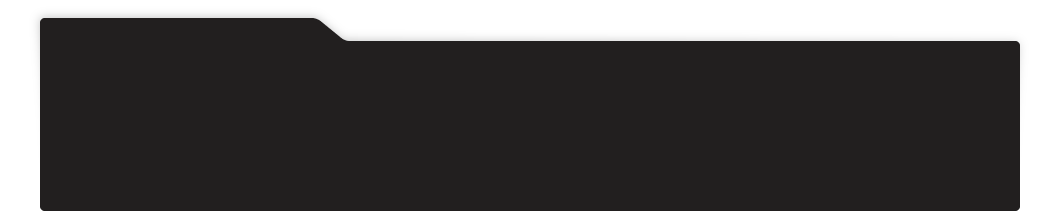
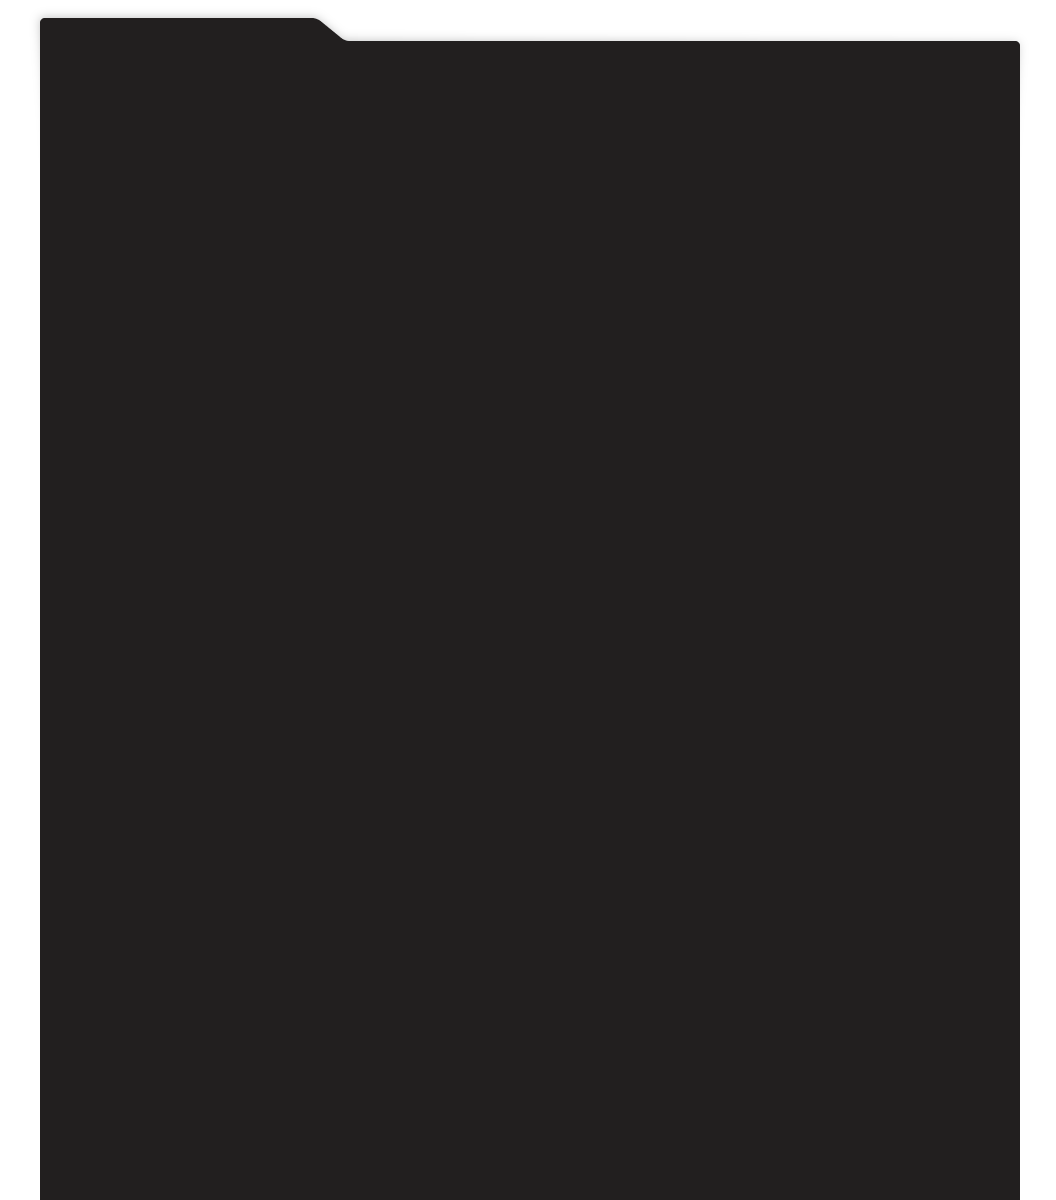
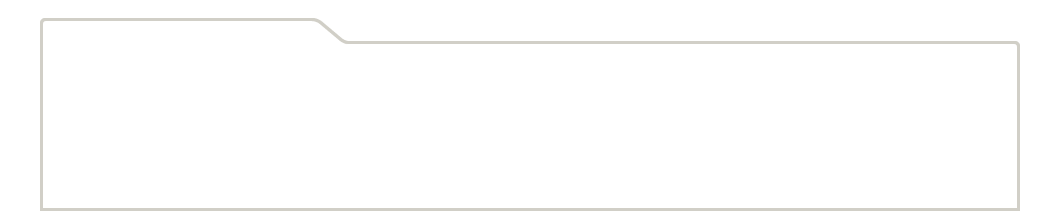
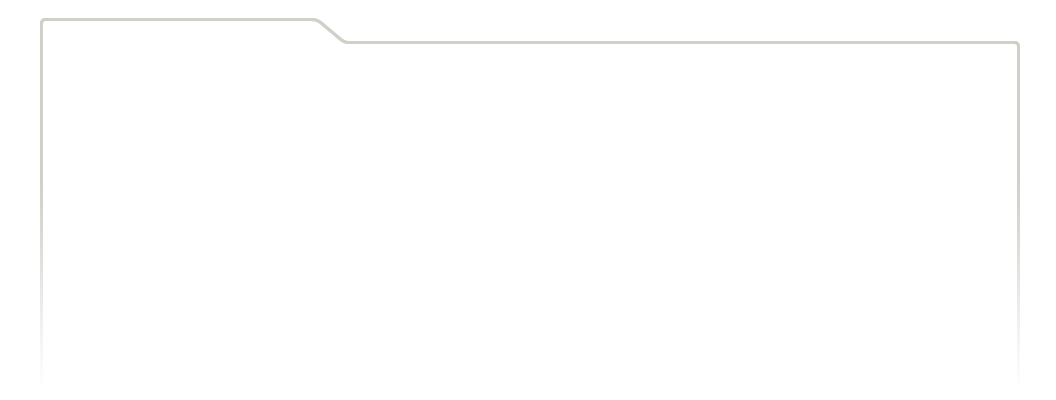
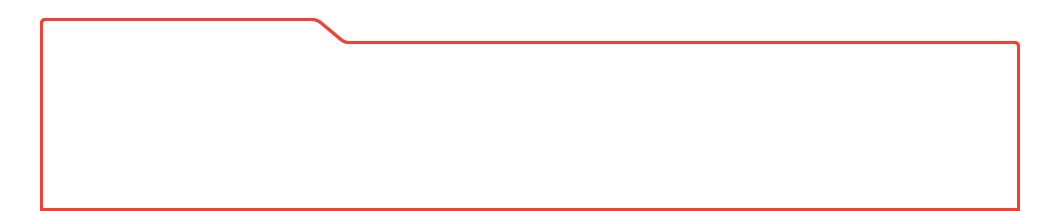
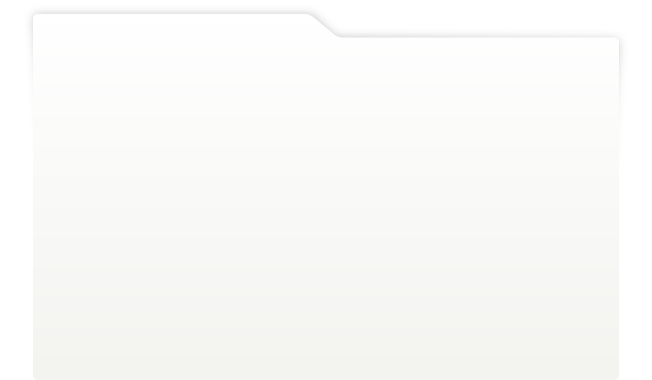
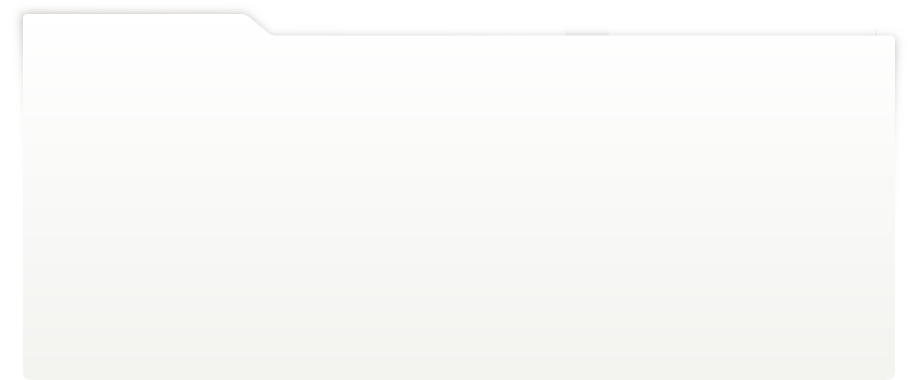
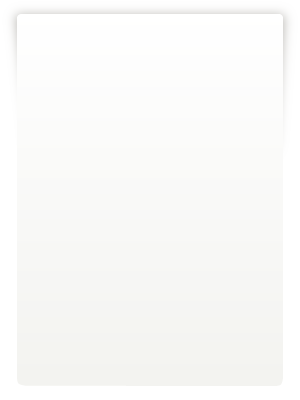
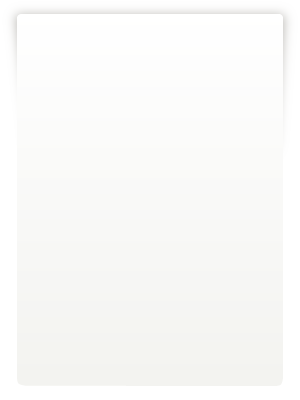
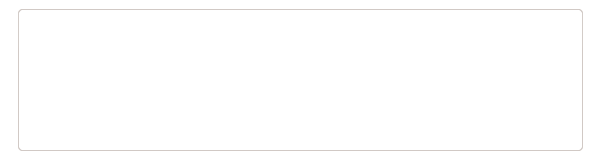
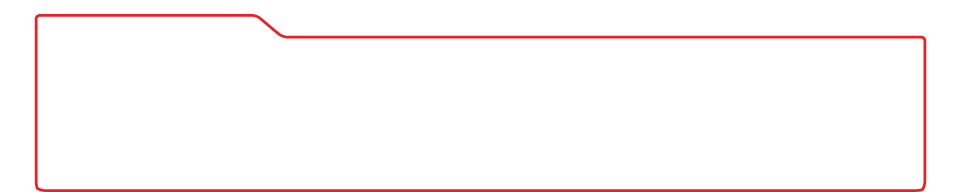
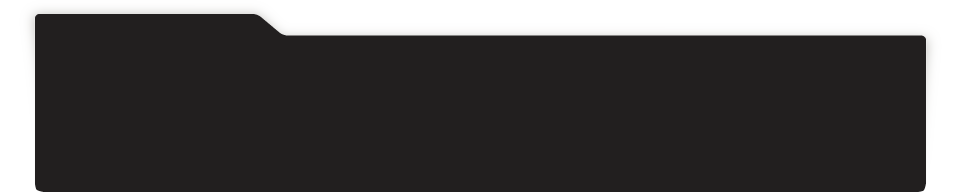
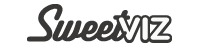
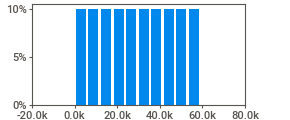
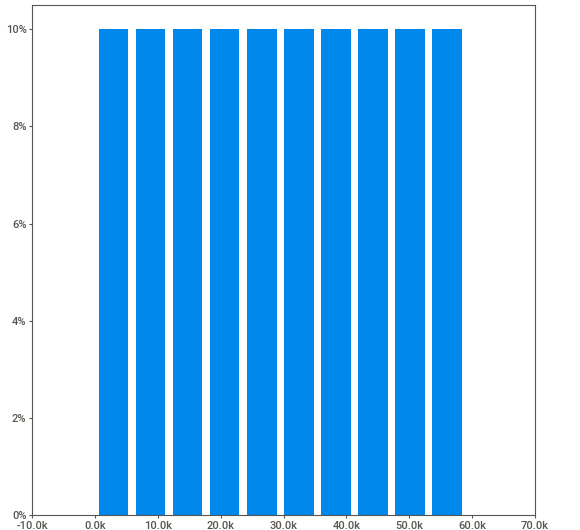
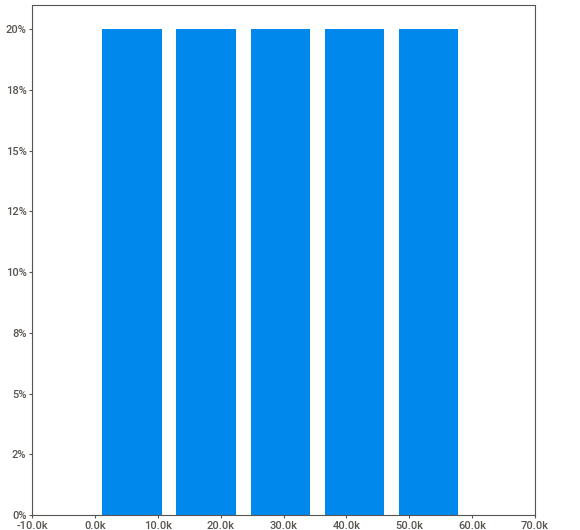
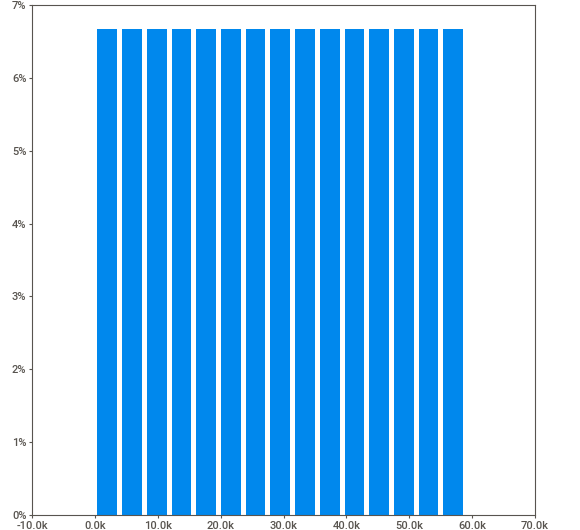
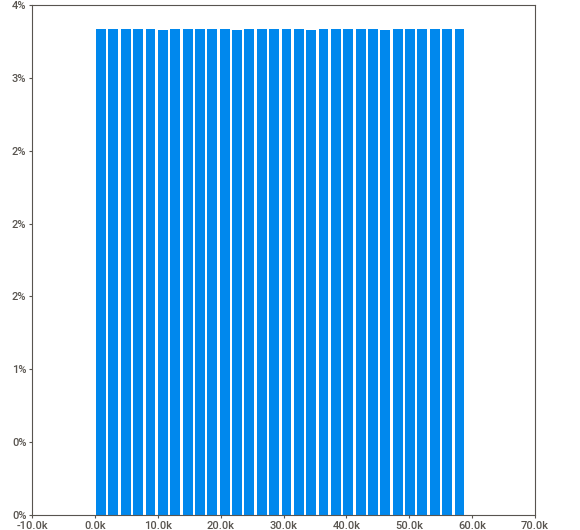
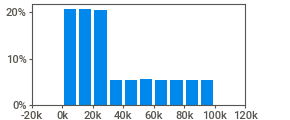
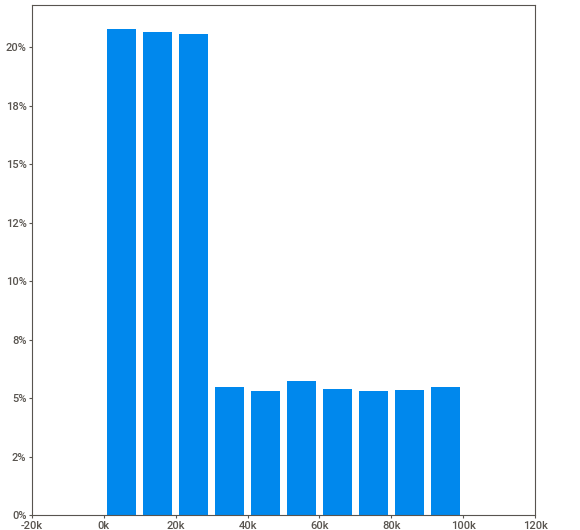
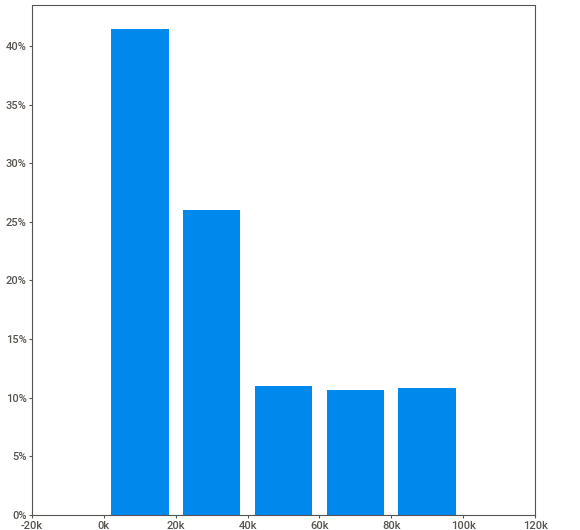
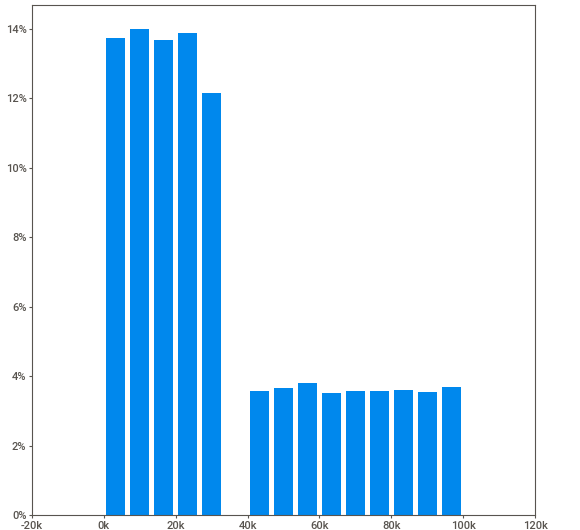
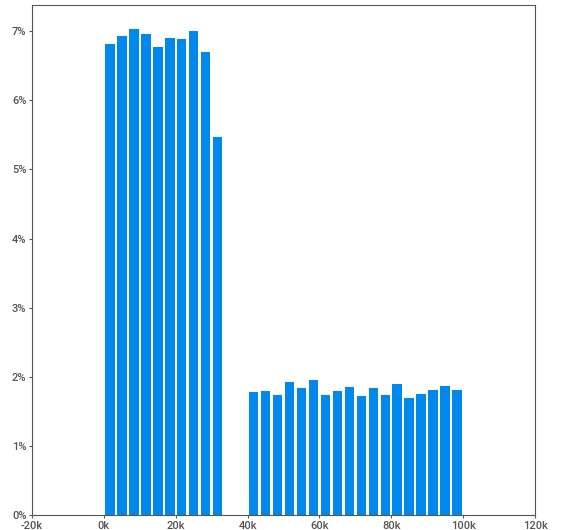
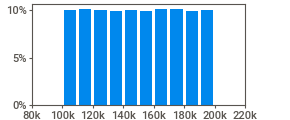
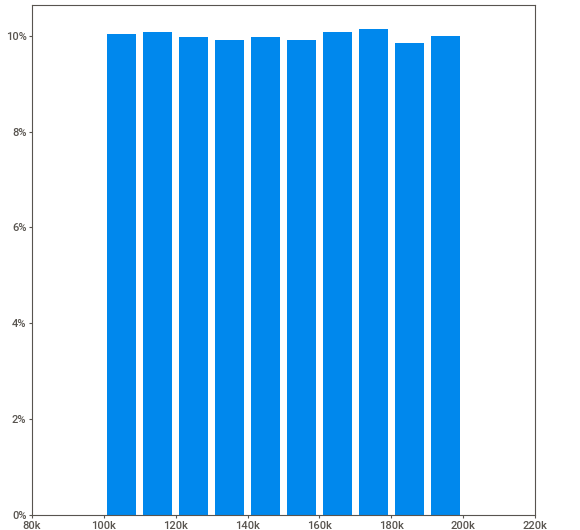
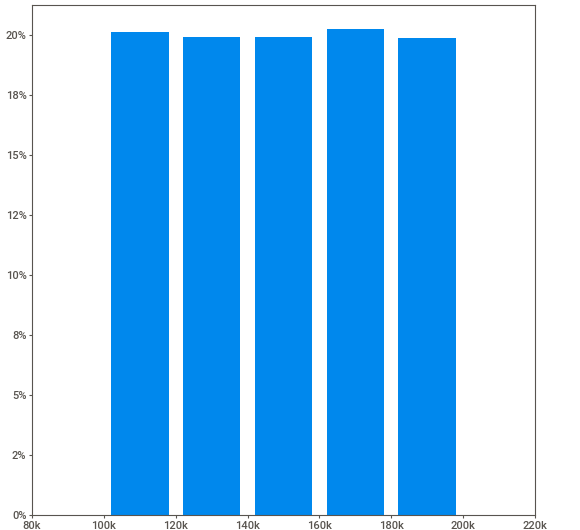
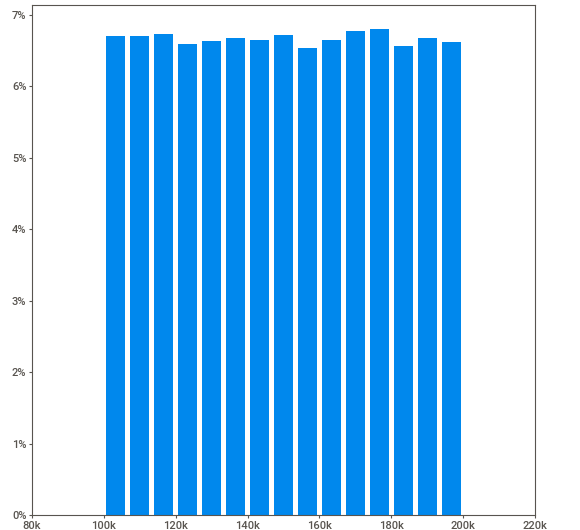
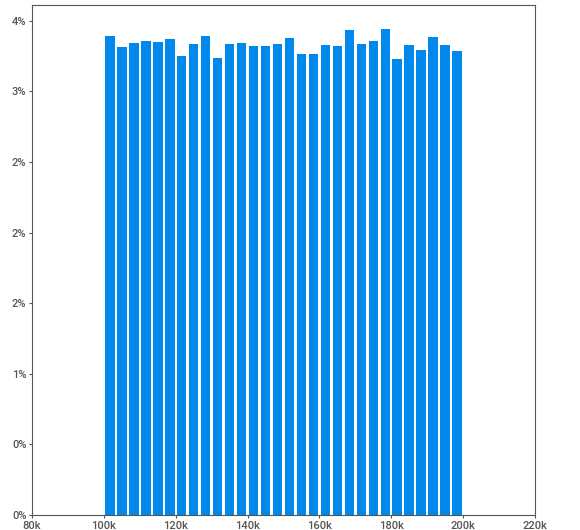
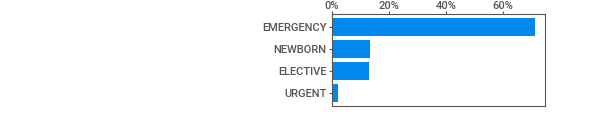
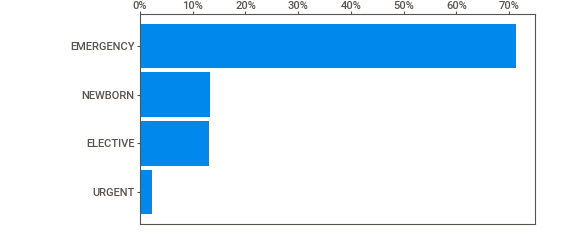
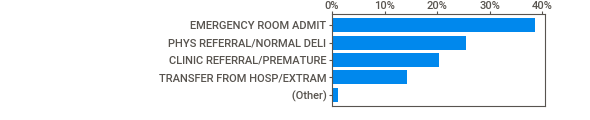
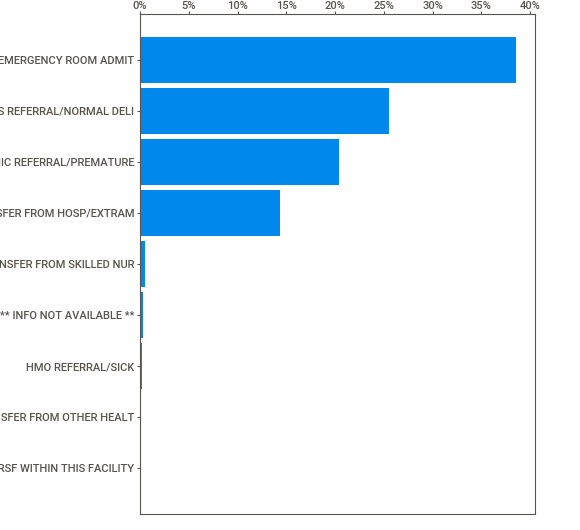
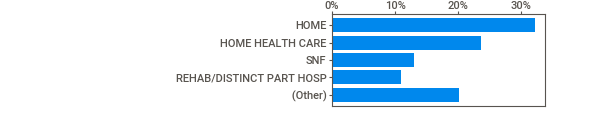
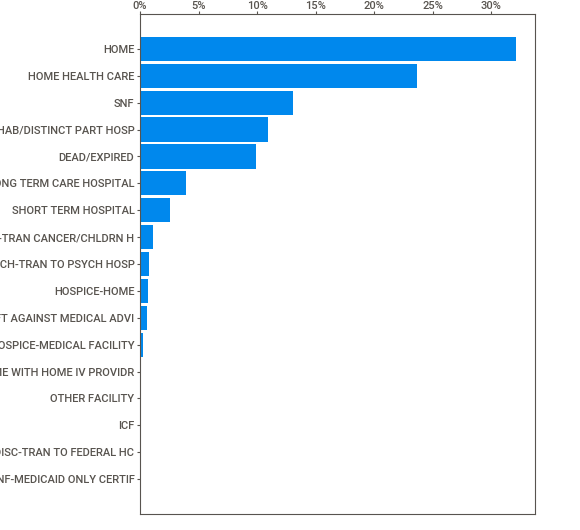
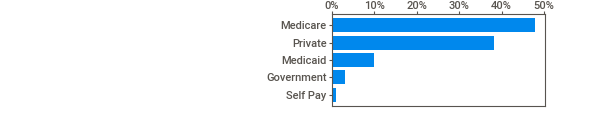
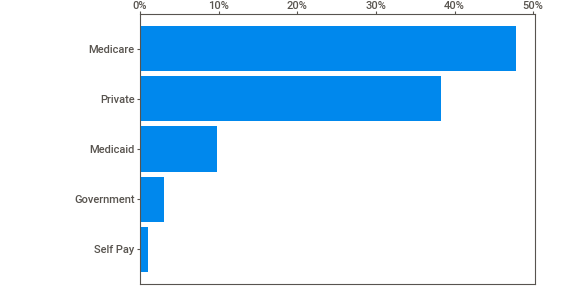
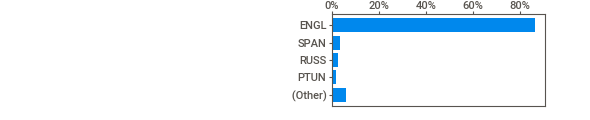
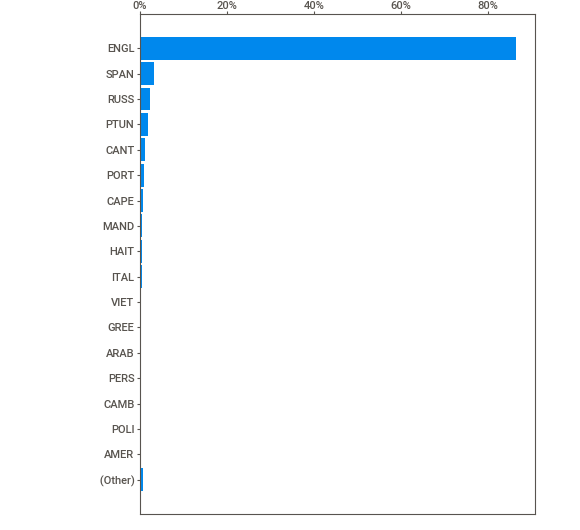
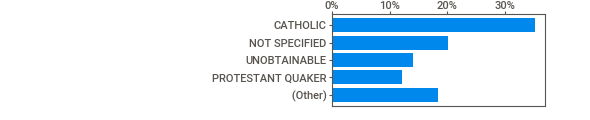
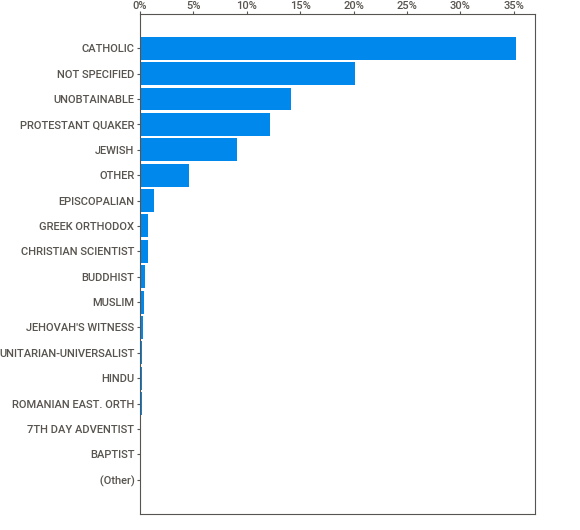
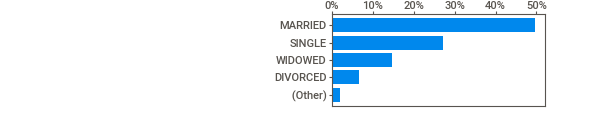
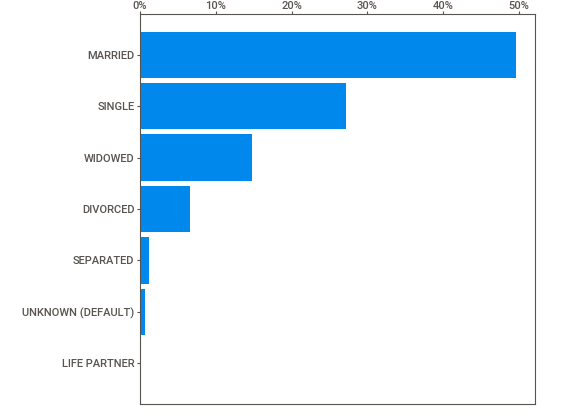
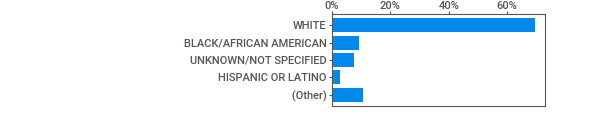
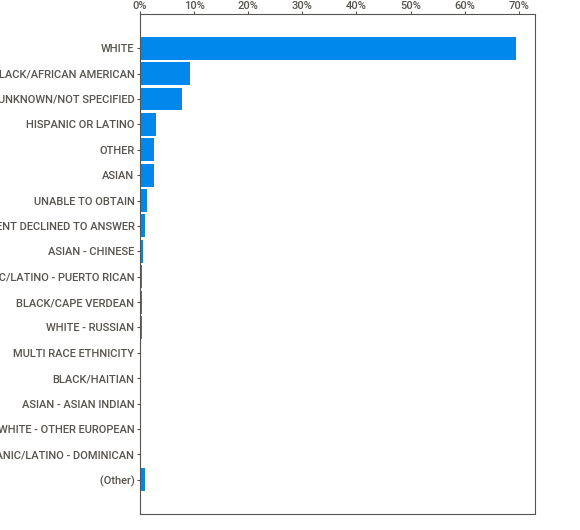
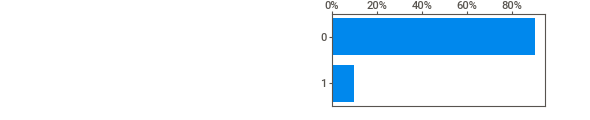
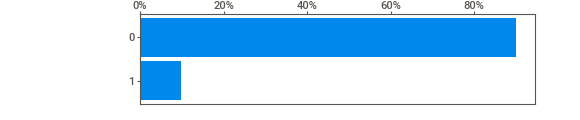
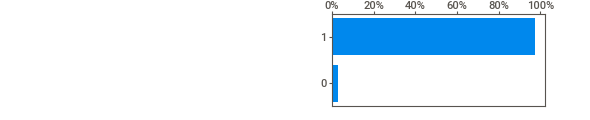
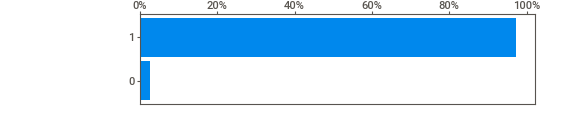
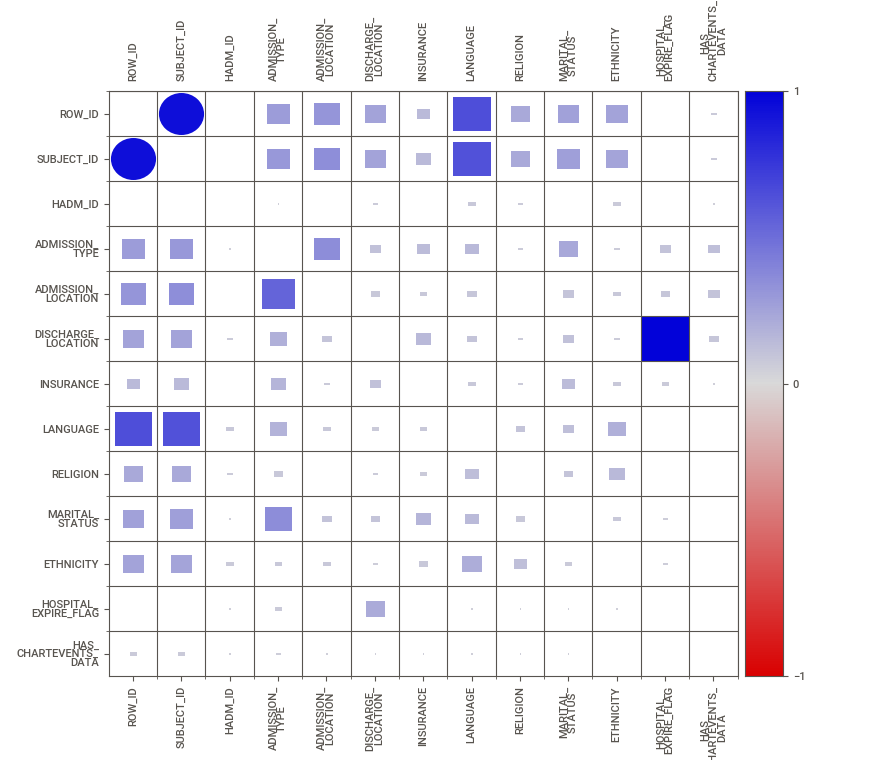
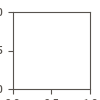

In [29]:
admissions_report=sv.analyze(df_admissions_full)
admissions_report.show_notebook()

The summary of Admissions dataset shows:
1. Total number of admissions is 58,976 with no missing values.
2. 71% of patients were admitted by Emergency, 13% of patients were Newborn and 13% of them had Elective admission. Only 2% of patients had Urgent admission.
3. 2% of admitted patients has Sepsis diagnosis.

#### 6. Demographic dataset

                                             |          | [  0%]   00:00 -> (? left)


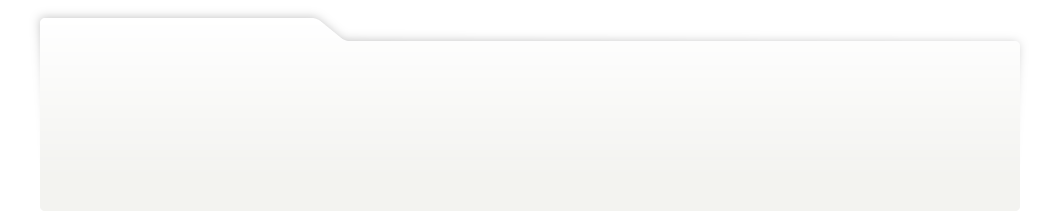
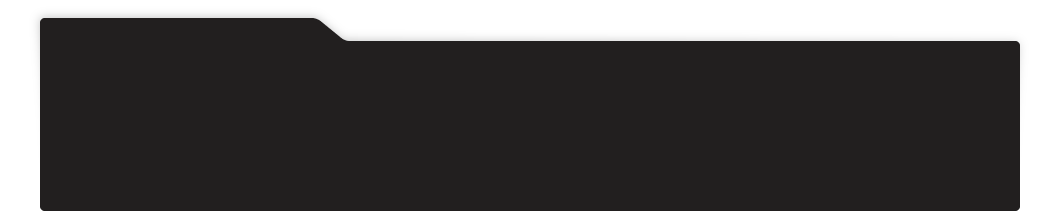
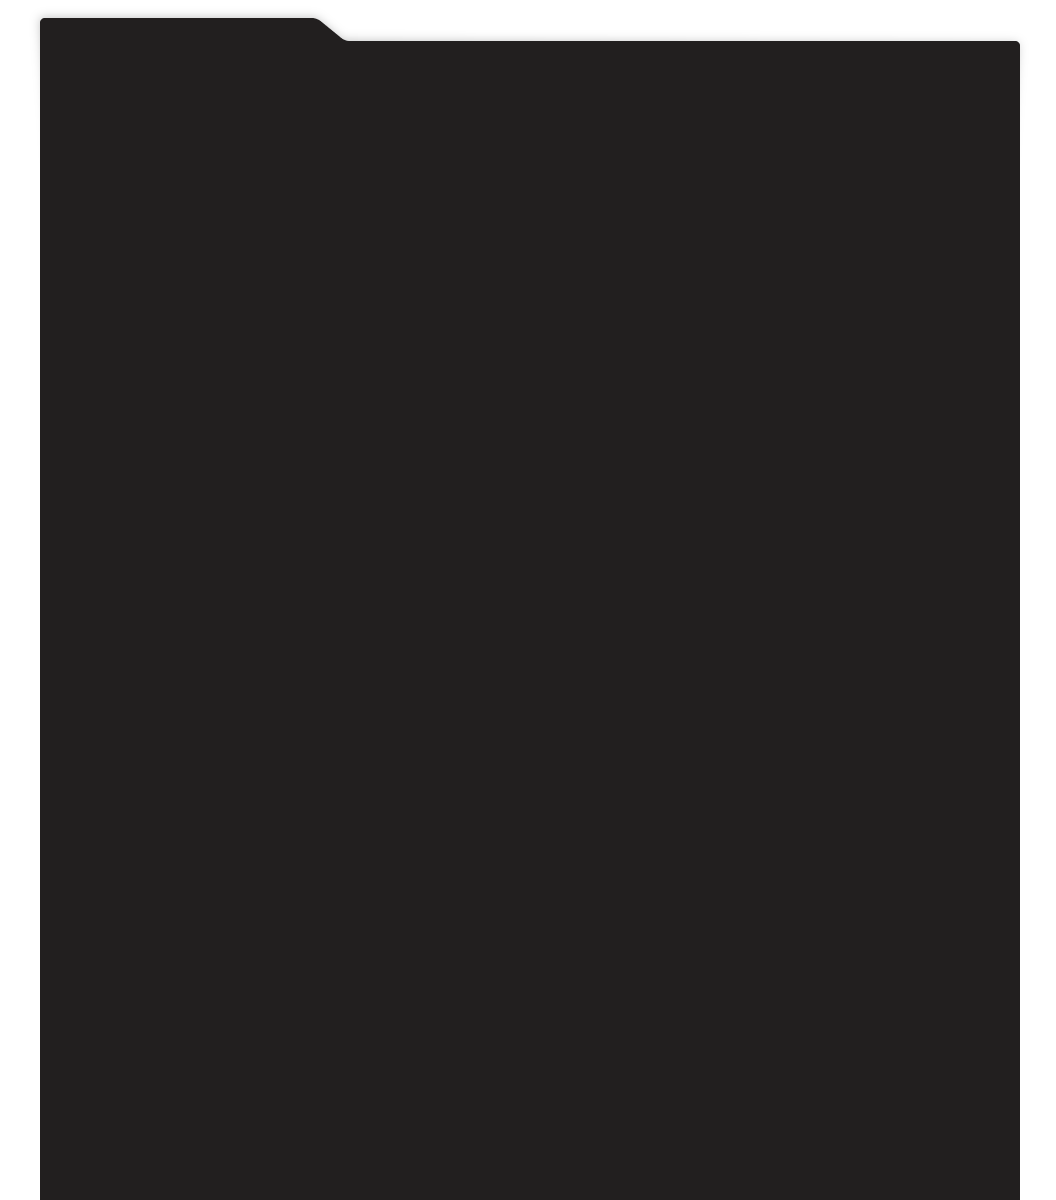
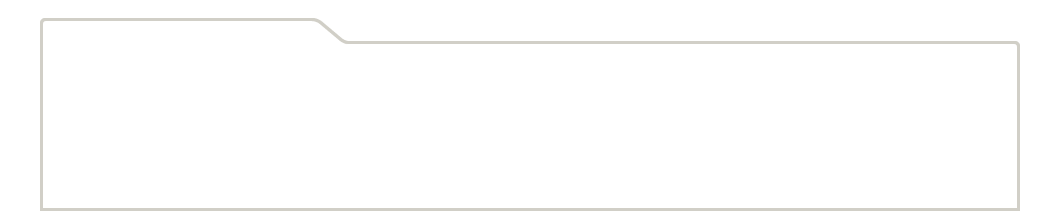
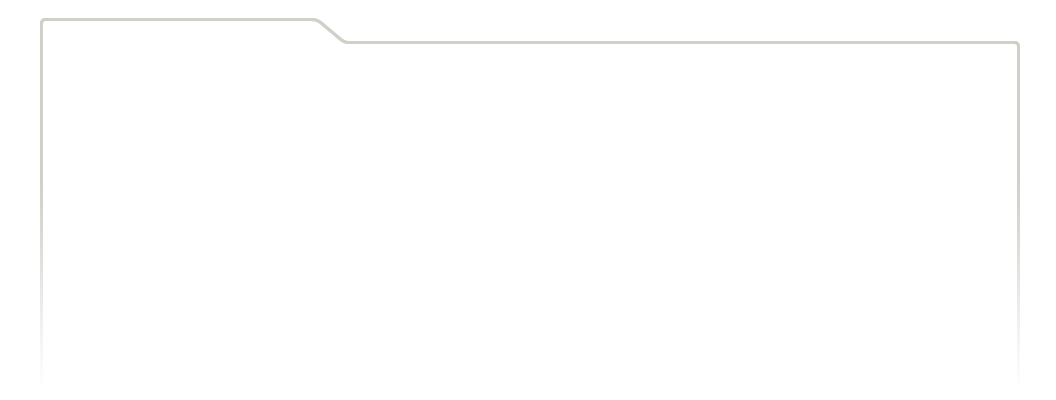
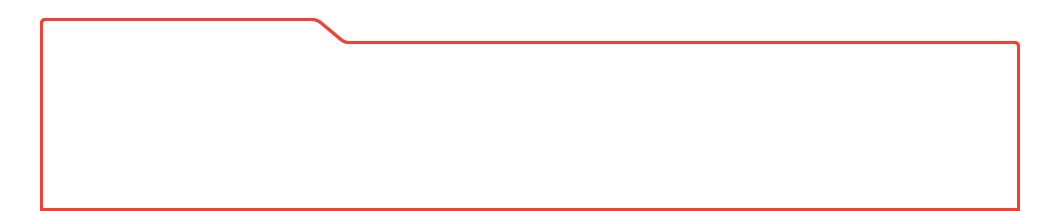
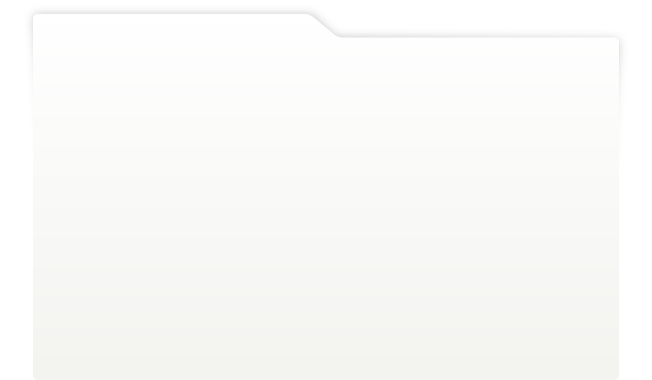
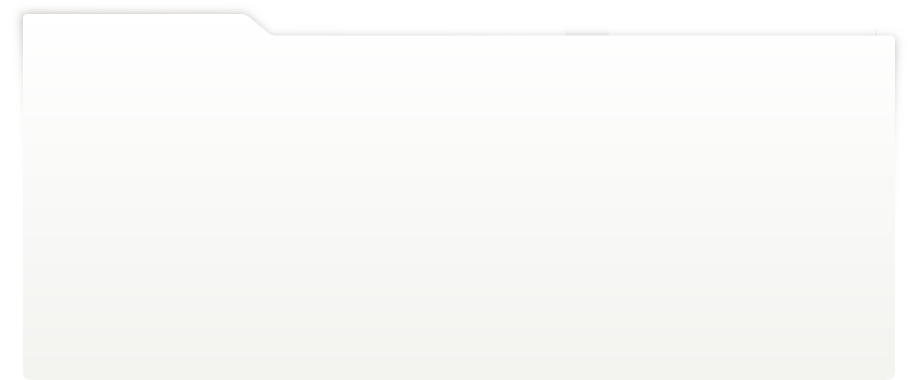
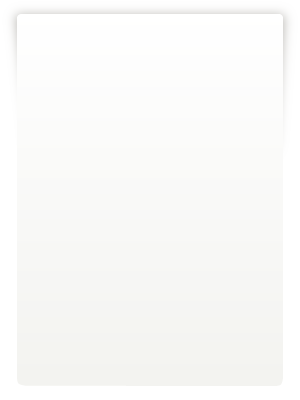
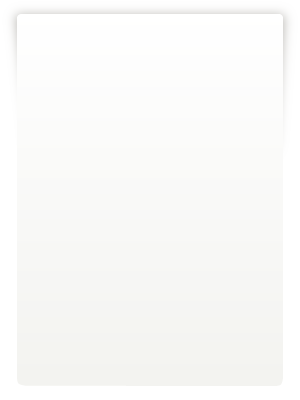
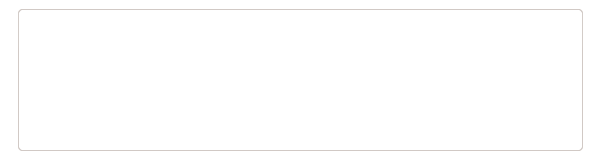
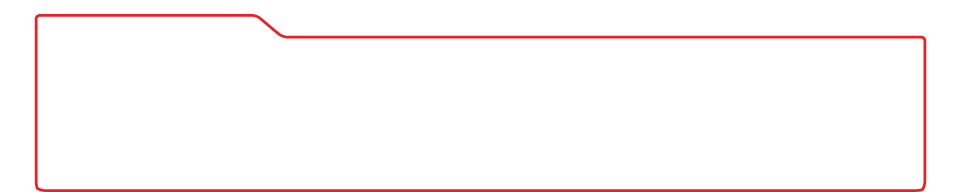
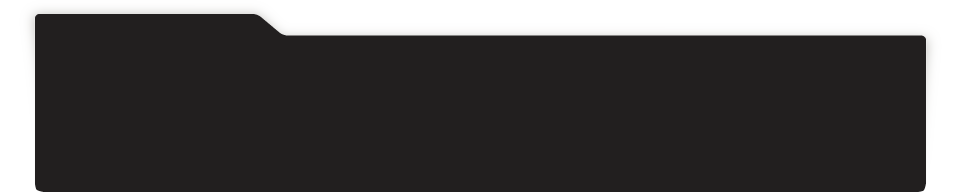
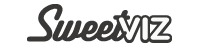
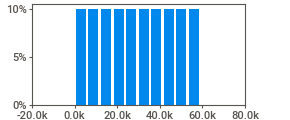
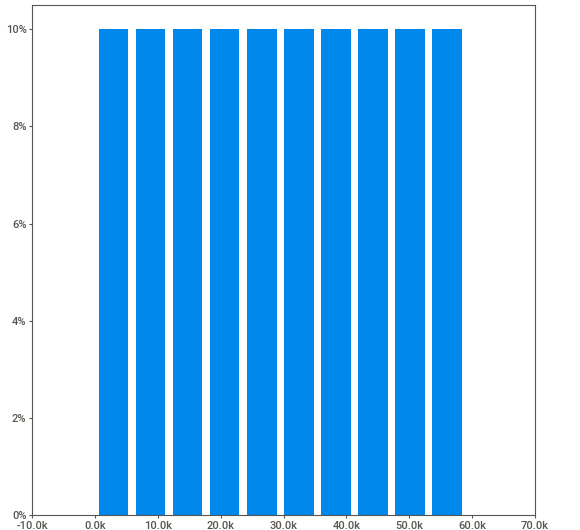
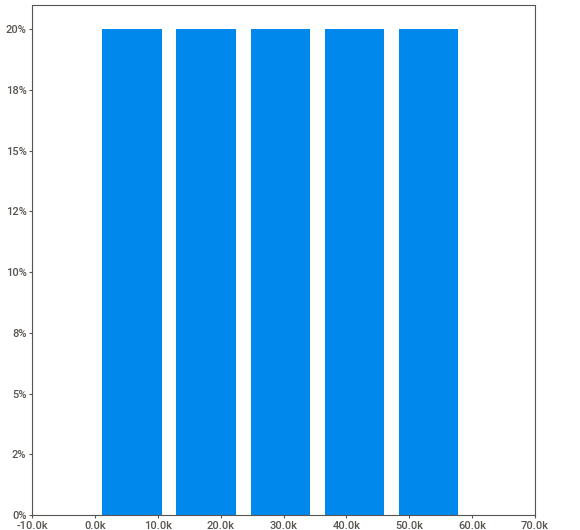
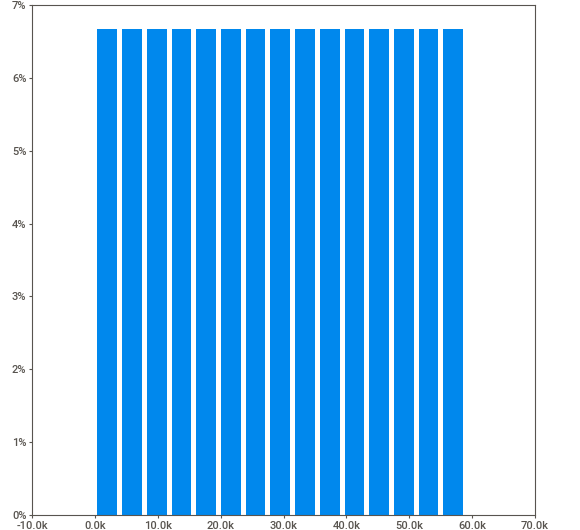
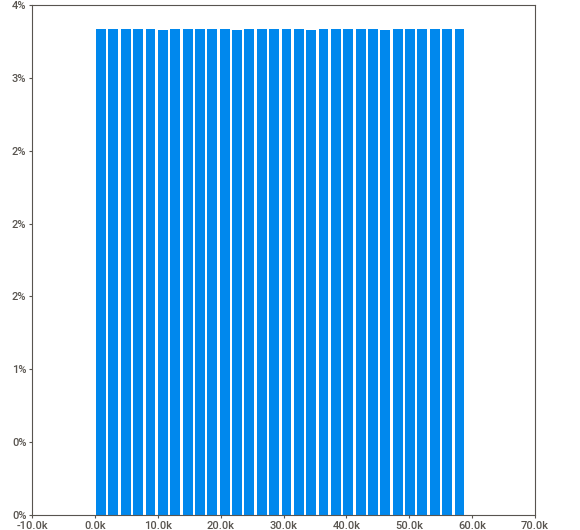
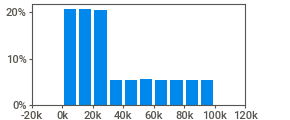
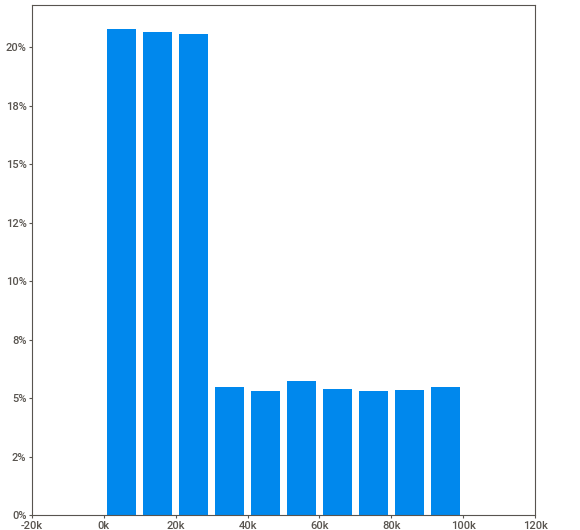
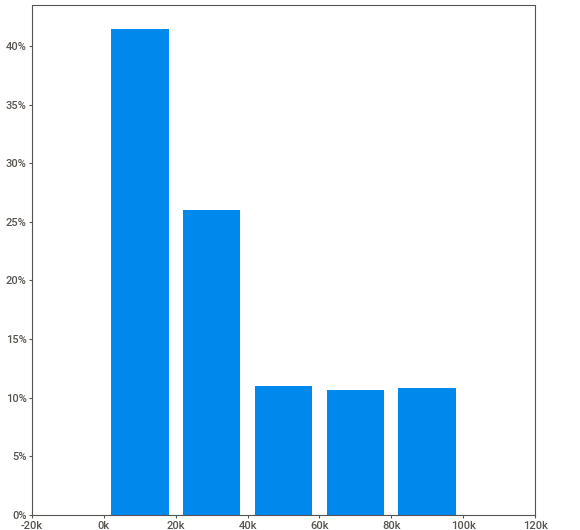
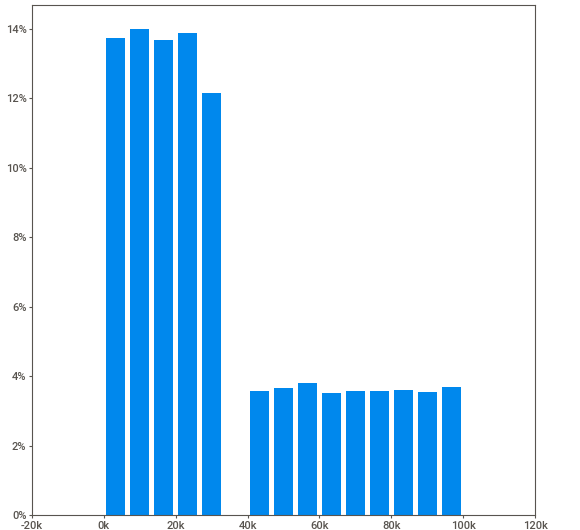
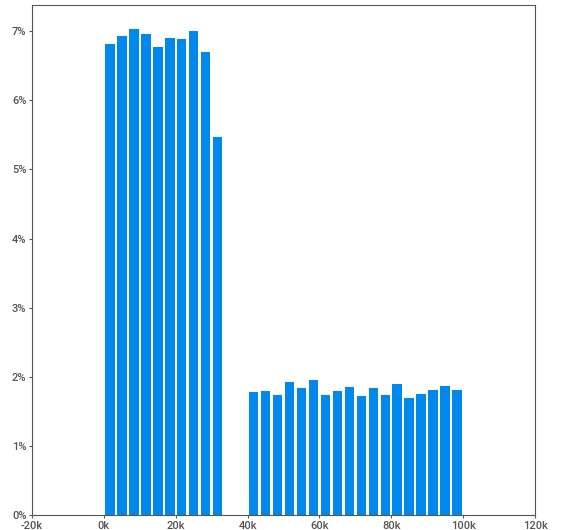
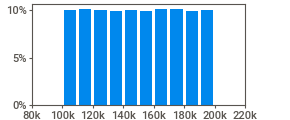
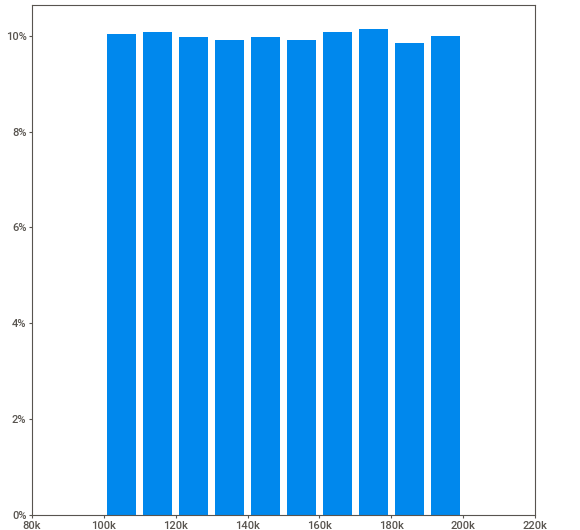
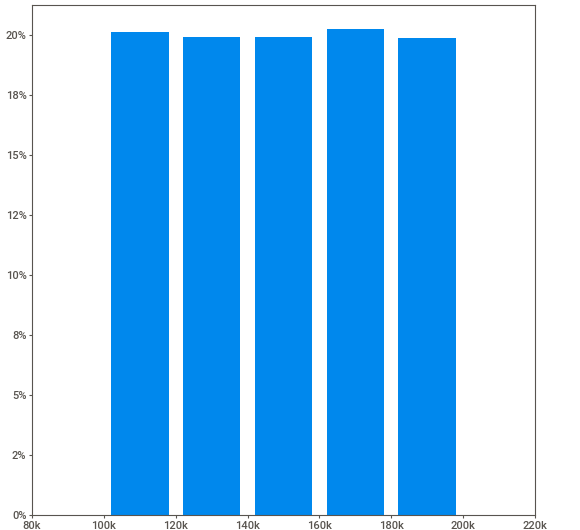
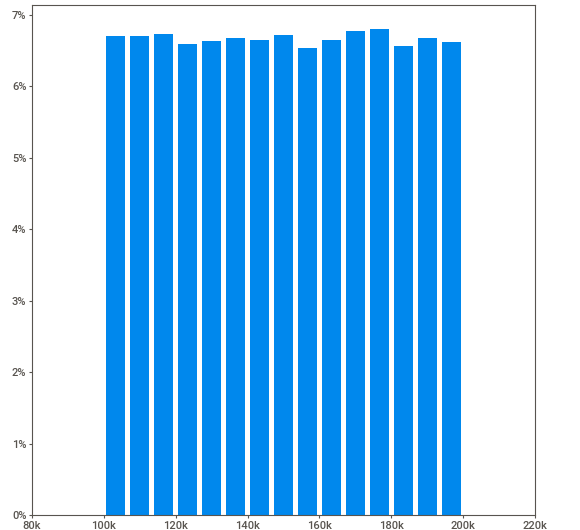
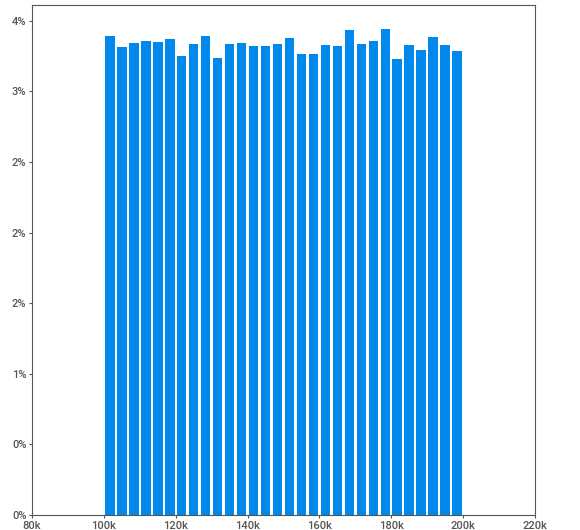
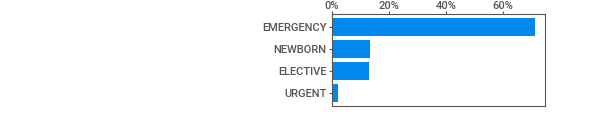
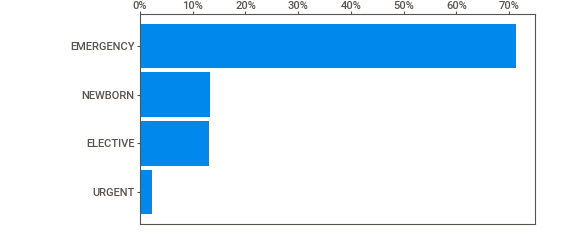
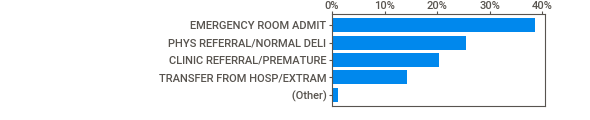
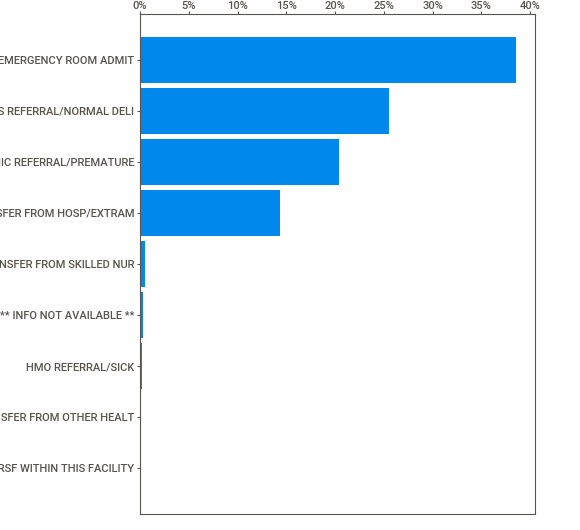
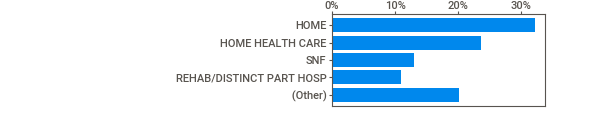
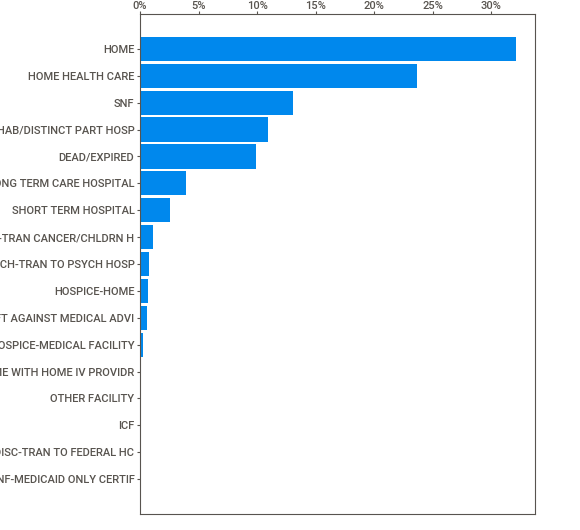
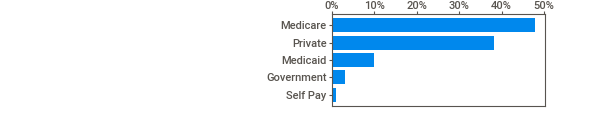
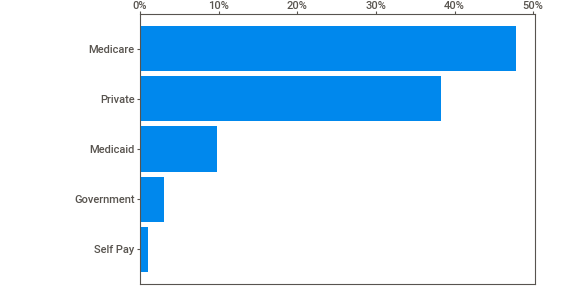
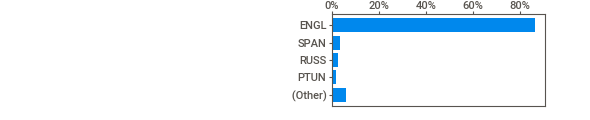
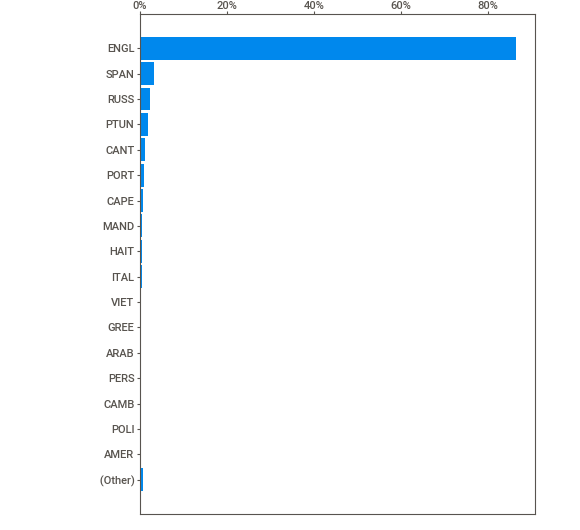
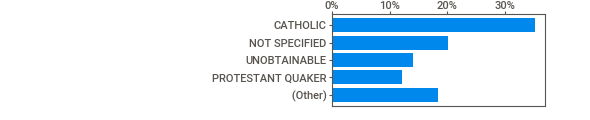
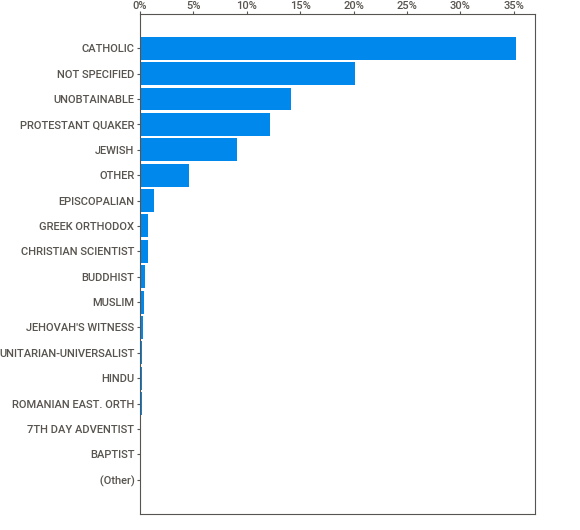
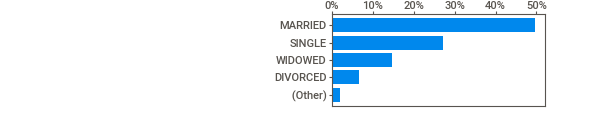
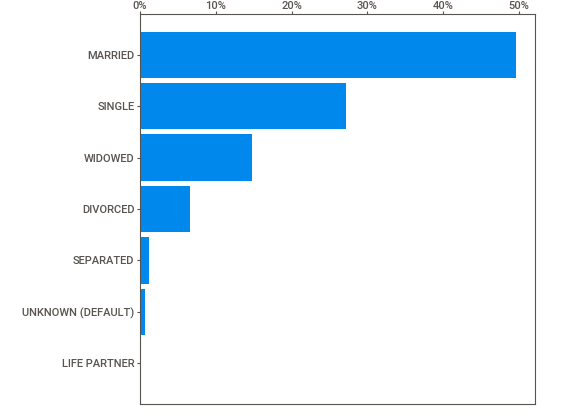
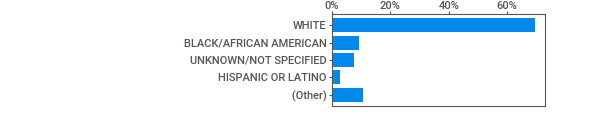
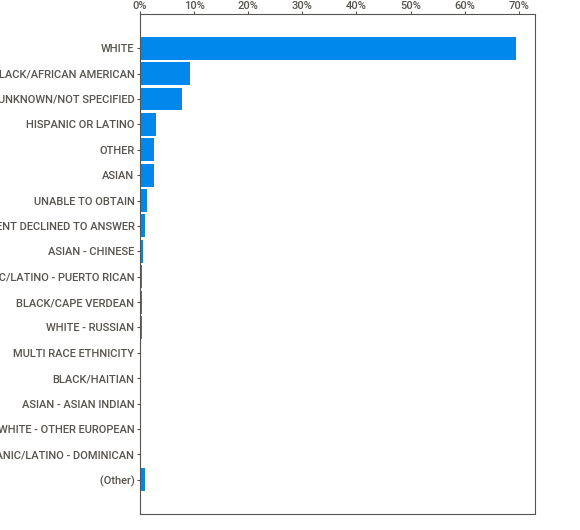
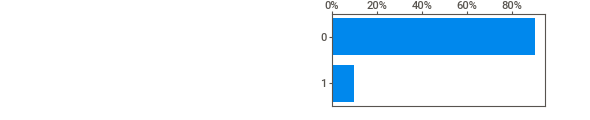
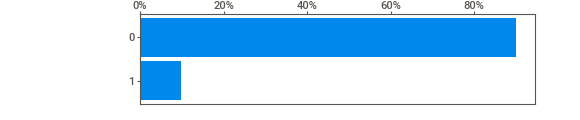
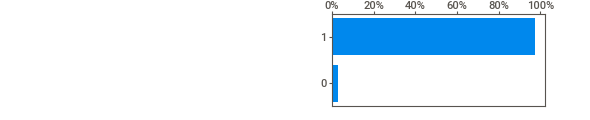
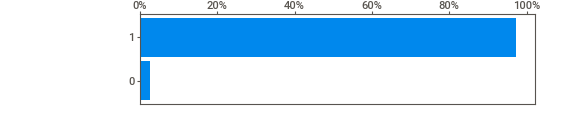
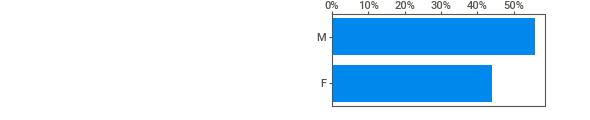
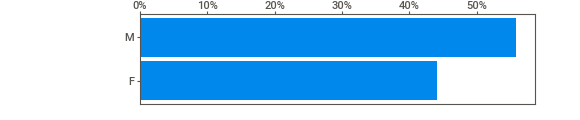
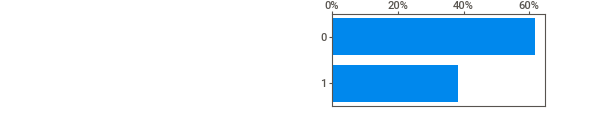
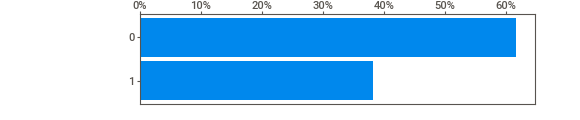
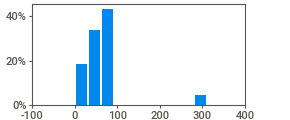
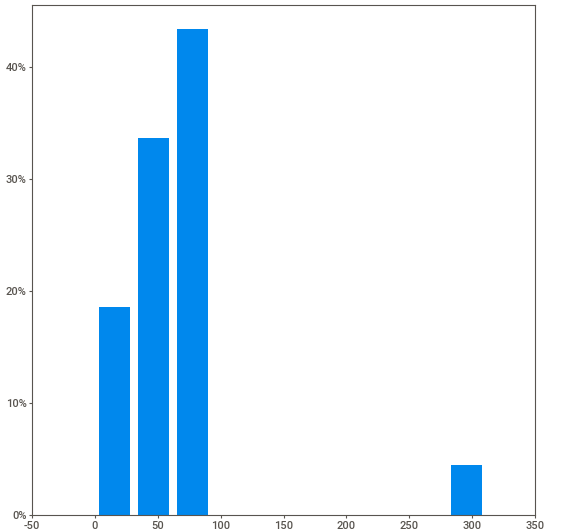
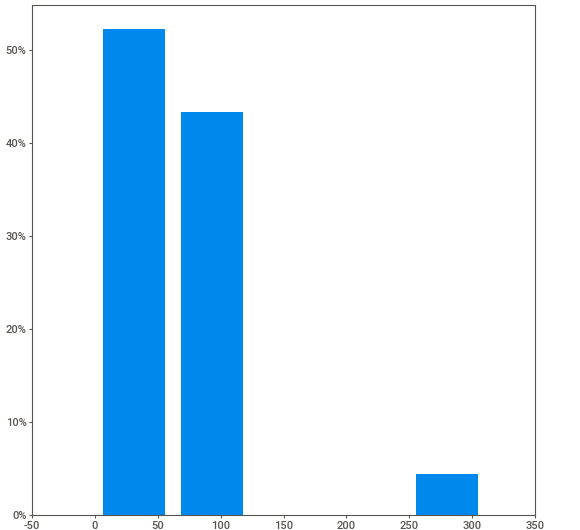
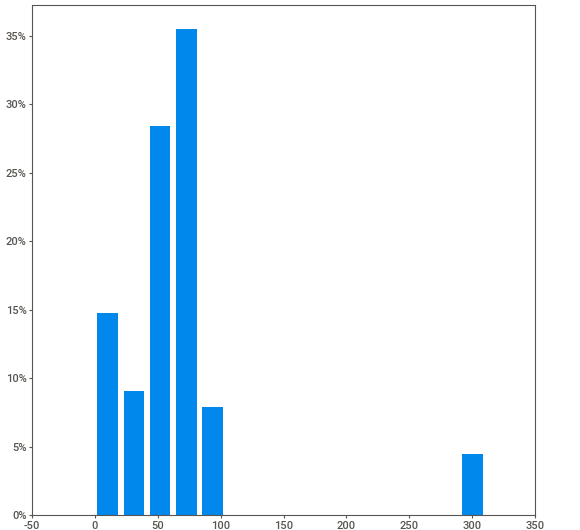
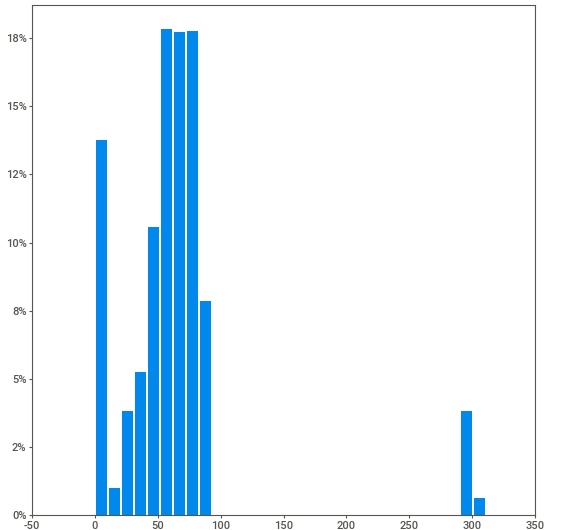
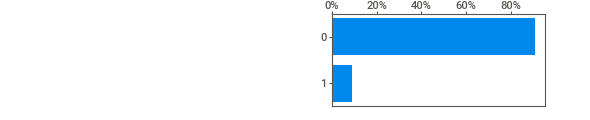
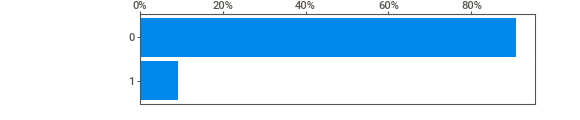
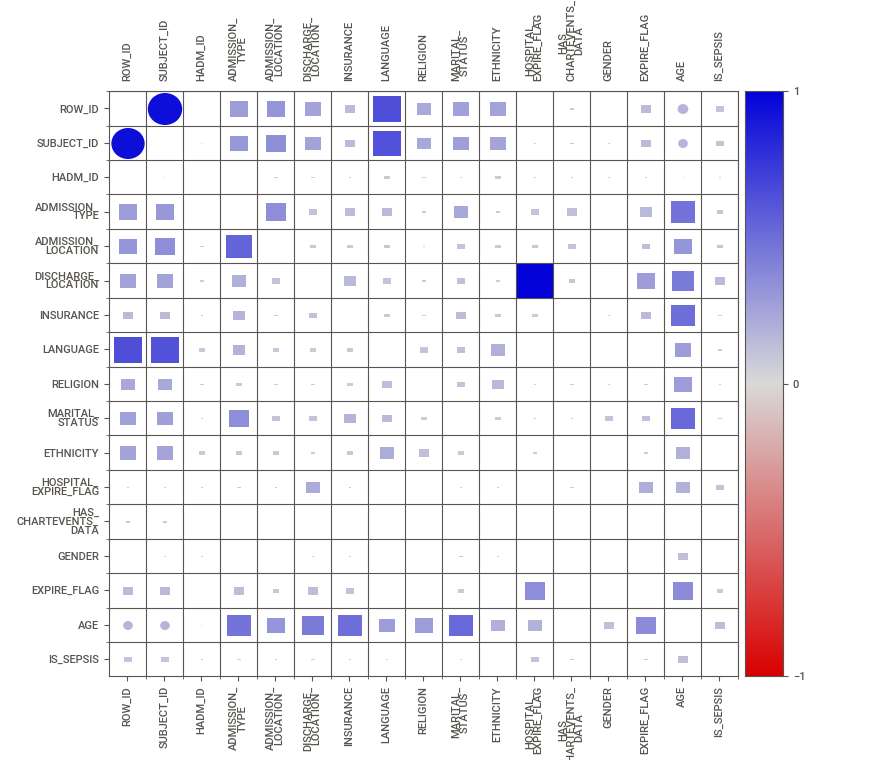
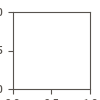

In [25]:
demographic_report=sv.analyze(df_demographic_full)
demographic_report.show_notebook()